In [2]:
# Import library
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import Data
df_sales = pd.read_csv('SalesTransaction.csv')

# Cek sampel data
df_sales.sample(2)

TransactionNo       Date ProductNo                   ProductName  \
169030        569228  10/2/2019     20836  French Paisley Cushion Cover   
262396        561218  7/25/2019     21248   Door Hanger Mum + Dads Room   

        Price  Quantity  CustomerNo         Country  
169030  11.12         6     15547.0  United Kingdom  
262396  13.62         1     15218.0  United Kingdom

# Data Cleansing
Eksekusi 2 code dibawah ini

In [5]:
# 1. Ubah kolom Date menjadi tipe datetime
df_sales['Date']= pd.to_datetime(df_sales['Date'])

# 2. Buang semua transaksi yang memiliki quantity negative atau yang TransactionNo diawali dengan C
df_sales = df_sales[df_sales['TransactionNo'].str[0]!='C']

In [6]:
# cek missing values
df_sales.isna().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       1
Country          0
dtype: int64

---
Terdapat Nan pada CustomerNo sebanyak 1, sedangkan variabel lain tidak missing pada baris yang sama. dalam hal ini missing value untuk sementara dibiarkan saja akan dihandling sesuai kebutuhan nantinya

---

# Top Contributing products

Pada retail store, ada banyak jenis barang yang dijual.
Memahami karakteristik penjualan di setiap barang sangatlah penting.  
Barang-barang dengan minat tinggi dari customer menjadi kunci bisnis untuk meraih untung.
Barang-barang dengan minat rendah dari masyarakat akan menjadi beban dari usaha apabila bisnis menyetok terlalu banyak.

Salah satu metode segmentasi yang digunakan adalah menggunakan segmentasi berdasarkan :
- Volume transaksi : Berapa banyak transaksi yang melibatkan suatu produk (Tidak mempedulikan banyaknya barang dalam 1 transaksi)
- Revenue total : Berapa dolar revenue yang dihasilkan dari penjualan produk ini.

Buatlah segmentasi produk berdasarkan volume dan revenue total dengan aturan sebagai berikut :

1. total_revenue didefinisikan sebagai perkalian harga barang dengan banyaknya pembelian
2. 20% produk dengan volume transaksi transaksi tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
3. 20% produk dengan total revenue tertinggi masuk kategori "Popular". 20 - 80% Masuk kategori "Normal" dan sisanya masuk ke kategori "Low"
4. Berdasarkan penggabungan segmentasi no.2 dan no.3, apabila suatu produk Popular dari segi volume transaksi dan total revenue, maka segmentasi final dari produk tersebut adalah "Super Popular". Apabila salah satu atribut populer sementara atribut lainnya normal, maka segmentasi finalnya adalah "Popular". Apabila kedua atributnya "Low", maka segmentasi finalnya adalah "Low". Semua kombinasi lain selain yang disebutkan masuk ke kategori "Normal"

## Pertanyaan
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?
2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di July 2019
3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

In [8]:
# Membuat kolom baru Revenue Total (Qty*Price)
df_sales = df_sales.copy()
df_sales['revenue_total'] = df_sales['Price'] * df_sales['Quantity']

# Menambahkan kolom 'Month' dan 'Year' untuk memudahkan pengelompokan
df_sales['Month'] = df_sales['Date'].dt.month
df_sales['Year'] = df_sales['Date'].dt.year

In [9]:
# VOLUME TRANSAKSI SELAMA TAHUN 2019

# Inisialisasi list kosong untuk menyimpan hasil akhir
volume_transaksi = []

# Iterasi untuk setiap bulan
for month in range(1, 13):
    # Filter data untuk bulan dan tahun tertentu
    df_month = df_sales[(df_sales['Month'] == month) & (df_sales['Year'] == 2019)].copy() 
    
    
    # Hitung jumlah transaksi dan total revenue untuk setiap produk
    df_month_agg = df_month.groupby('ProductNo').agg({
        'TransactionNo': 'count',
        'ProductName': 'first'
    }).reset_index()
    
    df_month_agg.columns = ['ProductNo', 'total_transaksi', 'ProductName']
    
    # Mengurutkan produk berdasarkan volume transaksi
    df_month_agg = df_month_agg.sort_values(by='total_transaksi', ascending=False)
    
    # Menentukan batas untuk kategori volume transaksi
    num_products = len(df_month_agg)
    popular_threshold = int(num_products * 0.2)  # 20% teratas
    low_threshold = int(num_products * 0.8)  # 80% teratas
    
    # Mengkategorikan produk berdasarkan volume transaksi
    df_month_agg['vol_category'] = ['Popular' if i < popular_threshold
                                          else 'Low' if i >= low_threshold 
                                          else 'Normal' for i in range(len(df_month_agg))]


    # Menambahkan informasi bulan ke DataFrame
    df_month_agg['Month_Name'] = pd.to_datetime(df_month['Month'], format='%m').dt.month_name().iloc[0]
    
    # menambahkan hasil akhir untuk bulan ini ke dalam list volume transaksi
    volume_transaksi.append(df_month_agg[['ProductNo', 'ProductName', 'total_transaksi', 'vol_category' ,'Month_Name']])
    
# Gabungkan hasil dari semua bulan menjadi satu DataFrame
volume_transaksi = pd.concat(volume_transaksi, ignore_index=True)

In [10]:
# TOTAL REVENUE SELAMA TAHUN 2019

# Inisialisasi list kosong untuk menyimpan hasil akhir
results_total_revenue = []

# Iterasi untuk setiap bulan
for month in range(1, 13):
    # Filter data untuk bulan dan tahun tertentu
    df_month = df_sales[(df_sales['Month'] == month) & (df_sales['Year'] == 2019)].copy()  
    
    # Hitung jumlah transaksi dan total revenue untuk setiap produk
    df_month_agg_revenue = df_month.groupby('ProductNo').agg({
        'revenue_total': 'sum',
    }).reset_index()
    
    df_month_agg_revenue .columns = ['ProductNo',  'revenue_total']
    
    # Mengurutkan produk berdasarkan volume transaksi
    df_month_agg_revenue  =  df_month_agg_revenue .sort_values(by='revenue_total', ascending=False)
    
    # Menentukan batas untuk kategori volume transaksi
    num_products_revenue = len( df_month_agg_revenue)
    revenue_popular_threshold = int(num_products * 0.2)  # 20% teratas
    revenue_low_threshold = int(num_products * 0.8)  # 80% teratas
    
    # Mengkategorikan produk berdasarkan volume transaksi
    df_month_agg_revenue['revenue_category'] = ['Popular' if i < revenue_popular_threshold
                                          else 'Low' if i >= revenue_low_threshold
                                          else 'Normal' for i in range(len(df_month_agg_revenue))]


    # Menambahkan informasi bulan ke DataFrame
    df_month_agg_revenue ['Month_Name'] = pd.to_datetime(df_month['Month'], format='%m').dt.month_name().iloc[0]
    
    # Menamba hasil akhir untuk bulan ini ke dalam list final_results
    results_total_revenue.append( df_month_agg_revenue [['ProductNo','revenue_total', 'revenue_category' ,'Month_Name']])
    
# Gabungkan hasil dari semua bulan menjadi satu DataFrame
final_results_revenue = pd.concat(results_total_revenue, ignore_index=True)

In [11]:
# Gabungkan volume_transkasi dan result_total_revenue berdasarkan ProductNo dan Month_Name
df_classify = pd.merge(volume_transaksi, final_results_revenue, on=['ProductNo', 'Month_Name'])
df_classify

## Mengklasifikasikan data produk berdasarkan kategori volume dan revenue November 2019
def classify_product(row):
    F = row['vol_category']
    M = row['revenue_category']
    
    if F == 'Popular' and M == 'Popular':
        return 'Super Popular'
    elif (F == 'Popular' and M == 'Normal') or (F =='Normal' and M =='Popular'):
        return 'Popular'
    elif F == 'Low' and M == 'Low':
        return 'Low'
    else:
        return 'Normal'

## Menambahkan kolom klasifikasi produk
df_classify['product_type'] = df_classify.apply(classify_product, axis=1)
df_classify

# Simpan Data CSV for visualization in looker
df_classify.to_csv('df_classify_sales.csv', index=False)


### Pertanyaan 1: 
1. Barang tipe apa yang masuk ke kategori super populer pada bulan November 2019?

Jumlah total barang super populer November 2019: 389


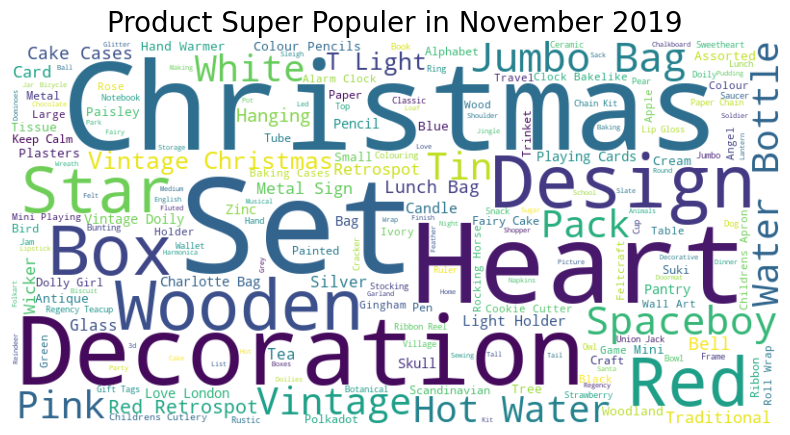

In [12]:
# Filter data untuk barang super populer di bulan November 2019
super_popular_nov19 = df_classify[(df_classify['product_type'] == 'Super Popular') & (df_classify['Month_Name'] == 'November')]

# Menampilkan daftar barang yang super populer pada November 2019
print(f"Jumlah total barang super populer November 2019: {len(super_popular_nov19)}")

# Menggabungkan semua nilai dalam kolom 'productname' menjadi satu string
text = " ".join(super_popular_nov19['ProductName'].astype(str))

# Membuat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Product Super Populer in November 2019', fontsize=20) 
plt.axis('off')
plt.show()

In [13]:
# Menampilkan daftar barang yang super populer pada november 2019
print("Daftar Barang Yang Super Populer pada November 2019:")
super_popular_nov19.sort_values(by='revenue_total')

Daftar Barang Yang Super Populer pada November 2019:


ProductNo                         ProductName  total_transaksi  \
25635     23256          Childrens Cutlery Spaceboy               55   
25382     23200                     Jumbo Bag Pears               94   
25387     22150            3 Stripey Mice Feltcraft               92   
25592     22601      Christmas Retrospot Angel Wood               61   
25536     23080            Red Metal Box Top Secret               67   
...         ...                                 ...              ...   
25220     84879       Assorted Colour Bird Ornament              212   
25207    85123A  Cream Hanging Heart T-Light Holder              269   
25203     22086      Paper Chain Kit 50'S Christmas              406   
25208     22197                      Popcorn Holder              256   
25202     23084                  Rabbit Night Light              517   

      vol_category Month_Name  revenue_total revenue_category   product_type  
25635      Popular   November        4483.51          Popular  Super Popular  
25382      Popular   November        4511.09          Popular  Super Popular  
25387      Popular   November        4538.22          Popular  Super Popular  
25592      Popular   November        4540.87          Popular  Super Popular  
25536      Popular   November        4622.44          Popular  Super Popular  
...            ...        ...            ...              ...            ...  
25220      Popular   November       56538.85          Popular  Super Popular  
25207      Popular   November       57392.52          Popular  Super Popular  
25203      Popular   November       95293.96          Popular  Super Popular  
25208      Popular   November      123424.90          Popular  Super Popular  
25202      Popular   November      159889.96          Popular  Super Popular  

[389 rows x 8 columns]

In [14]:
# menyimpan data super popular nov19
super_popular_nov19.to_csv('super_popular_19.csv', index=False)

In [15]:
super_popular_nov19.describe()

total_transaksi  revenue_total
count       389.000000     389.000000
mean        104.529563   12462.660308
std          55.046159   13199.262386
min          44.000000    4483.510000
25%          68.000000    6143.110000
50%          89.000000    8876.000000
75%         124.000000   13916.080000
max         517.000000  159889.960000

Insight:
1.  Terdapat 389 produk yang memiliki kategori super populer di tahun 2019 dengan rata-rata 12.462 dan standar variasi yang tinggi yaitu 13.1999, ini menunjukkan bahwa  adanya perbedaan besar dalam penjualan antar produk super populer

### Pertanyaan 2: 

2. Apakah barang yang populer di November 2019 sama dengan barang yang populer di July 2019


In [16]:
## Pertanyaan 2: Apakah barang yang populer di November 2019 sama dengan barang yang populer di bulan Juli
popular_nov19 = df_classify[(df_classify['product_type'] == 'Popular') & (df_classify['Month_Name'] == 'November')]
popular_jul19 = df_classify[(df_classify['product_type'] == 'Popular') & (df_classify['Month_Name'] == 'July')]

# Mencari barang-barang yang populer di bulan November dan bulan Juli 2019
common_popular = set(popular_nov19['ProductNo']).intersection(set(popular_jul19['ProductNo']))

# Menampilkan barang yang populer di kedua bulan beserta jumlah totalnya
popular_nov_jul19 = popular_nov19[popular_nov19['ProductNo'].isin(common_popular)].sort_values(by='Month_Name')
print(f"\nJumlah barang populer di bulan November 2019: {len(popular_nov19)}")
print(f"Jumlah barang populer di bulan Juli 2019: {len(popular_jul19)}")
print(f"Jumlah barang populer di bulan Juli dan November 2019: {len(popular_nov_jul19)}")
print("\nBarang yang populer di November 2019 dan Juli 2019:")

popular_nov_jul19




Jumlah barang populer di bulan November 2019: 279
Jumlah barang populer di bulan Juli 2019: 320
Jumlah barang populer di bulan Juli dan November 2019: 74

Barang yang populer di November 2019 dan Juli 2019:


ProductNo                        ProductName  total_transaksi  \
25229     21034       Rex Cash+Carry Jumbo Shopper              195   
25809     84949      Silver Hanging T-Light Holder               42   
25767     21974   Set Of 36 Paisley Flower Doilies               44   
25765     22211             Wood Stamp Set Flowers               44   
25764     21877                Home Sweet Home Mug               44   
...         ...                                ...              ...   
25648     23191       Bundle Of 3 Retro Note Books               54   
25642     20749         Assorted Colour Mini Cases               55   
25640     21559  Strawberry Lunch Box With Cutlery               55   
25610     22602  Retrospot Wooden Heart Decoration               58   
26928     16045         Popart Wooden Pencils Asst                9   

      vol_category Month_Name  revenue_total revenue_category product_type  
25229      Popular   November        3598.94           Normal      Popular  
25809       Normal   November        8318.83          Popular      Popular  
25767      Popular   November        2832.31           Normal      Popular  
25765      Popular   November        2000.82           Normal      Popular  
25764      Popular   November        4392.24           Normal      Popular  
...            ...        ...            ...              ...          ...  
25648      Popular   November        2866.81           Normal      Popular  
25642      Popular   November        3834.14           Normal      Popular  
25640      Popular   November        2896.79           Normal      Popular  
25610      Popular   November        3874.80           Normal      Popular  
26928       Normal   November        9054.00          Popular      Popular  

[74 rows x 8 columns]

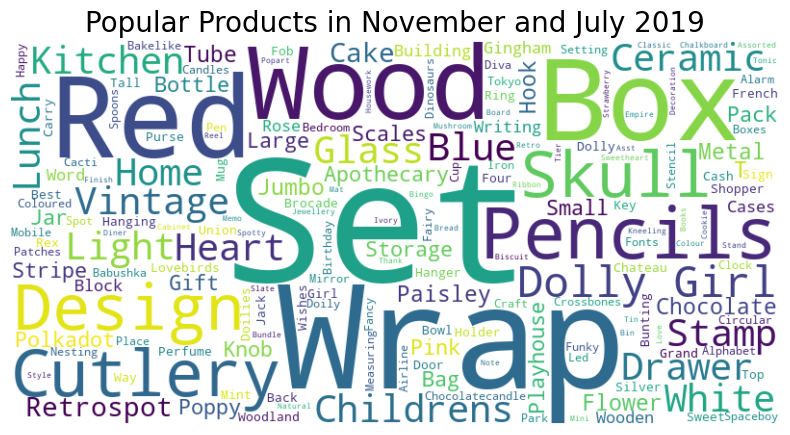

In [17]:
# Menggabungkan semua nilai dalam kolom 'ProductName' menjadi satu string
text = " ".join(popular_nov_jul19['ProductName'].astype(str))

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan Word Cloud menggunakan matplotlib dan menambahkan judul
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('Popular Products in November and July 2019', fontsize=20)  
plt.show()

In [18]:
print("summary Juli 2019:")
print(popular_jul19.describe())
print("summary November 2019:")
print(popular_nov19.describe())

summary Juli 2019:
       total_transaksi  revenue_total
count       320.000000     320.000000
mean         23.428125    3403.363937
std           9.809526    4334.746982
min           3.000000     565.000000
25%          16.750000    1646.080000
50%          24.000000    2367.800000
75%          29.000000    3398.265000
max          77.000000   52358.760000
summary November 2019:
       total_transaksi  revenue_total
count       279.000000     279.000000
mean         48.741935    4699.628853
std          19.788579    5322.765221
min           5.000000    1326.040000
25%          39.500000    2743.260000
50%          48.000000    3829.270000
75%          58.500000    5331.575000
max         195.000000   77744.920000


Insight:
1. sebanyak 74 produk yang berkategori popular baik dibulan november maupun dibulan juli terlihat bahwa variasi produk pada bulan juli lebih banyak dibandingkan bulan november namun jika dilihat dari revenue rata rata revenue dibulan November lebih tinggi dibandingkan bulan juli. Hal ini dapat memberikan gambaran jika ada perbedaan strategi, pada kedua bulan tersebut, maka perlu dilakukan evaluasi bagaimana strategi yang tepat untuk peningkatan penjualan yang diiringi peningkatakan variasi produk di periode selanjutnya 

### Pertanyaan 3:

3. Apakah barang yang masuk kategori super populer di november sama dengan barang super populer di July ?

In [19]:
## Pertanyaan 2: Apakah barang yang super populer di November 2019 sama dengan barang yang populer di bulan Juli
super_popular_nov19 = df_classify[(df_classify['product_type'] == 'Super Popular') & (df_classify['Month_Name'] == 'November')]
super_popular_jul19 = df_classify[(df_classify['product_type'] == 'Super Popular') & (df_classify['Month_Name'] == 'July')]

# Mencari barang-barang yang Super populer di bulan November dan bulan Juli 2019
common_super_popular = set(super_popular_nov19['ProductNo']).intersection(set(super_popular_jul19['ProductNo']))

# Menampilkan barang yang populer di kedua bulan beserta jumlah totalnya
super_popular_nov_jul19 = super_popular_nov19[super_popular_nov19['ProductNo'].isin(common_super_popular)]
print(f"\nJumlah barang super populer di bulan November 2019: {len(super_popular_nov19)}")
print(f"Jumlah barang super populer di bulan Juli 2019: {len(super_popular_jul19)}")
print(f"Jumlah barang super populer di bulan Juli dan November 2019: {len(super_popular_nov_jul19)}")
print("\nBarang yang super populer di November 2019 dan Juli 2019:")

super_popular_nov_jul19.sort_values(by='revenue_total')


Jumlah barang super populer di bulan November 2019: 389
Jumlah barang super populer di bulan Juli 2019: 342
Jumlah barang super populer di bulan Juli dan November 2019: 171

Barang yang super populer di November 2019 dan Juli 2019:


ProductNo                          ProductName  total_transaksi  \
25635     23256           Childrens Cutlery Spaceboy               55   
25382     23200                      Jumbo Bag Pears               94   
25394     21928  Jumbo Bag Scandinavian Blue Paisley               90   
25743     21985     Pack Of 12 Hearts Design Tissues               46   
25395     22385            Jumbo Bag Spaceboy Design               90   
...         ...                                  ...              ...   
25220     84879        Assorted Colour Bird Ornament              212   
25207    85123A   Cream Hanging Heart T-Light Holder              269   
25203     22086       Paper Chain Kit 50'S Christmas              406   
25208     22197                       Popcorn Holder              256   
25202     23084                   Rabbit Night Light              517   

      vol_category Month_Name  revenue_total revenue_category   product_type  
25635      Popular   November        4483.51          Popular  Super Popular  
25382      Popular   November        4511.09          Popular  Super Popular  
25394      Popular   November        4758.05          Popular  Super Popular  
25743      Popular   November        4780.90          Popular  Super Popular  
25395      Popular   November        4856.63          Popular  Super Popular  
...            ...        ...            ...              ...            ...  
25220      Popular   November       56538.85          Popular  Super Popular  
25207      Popular   November       57392.52          Popular  Super Popular  
25203      Popular   November       95293.96          Popular  Super Popular  
25208      Popular   November      123424.90          Popular  Super Popular  
25202      Popular   November      159889.96          Popular  Super Popular  

[171 rows x 8 columns]

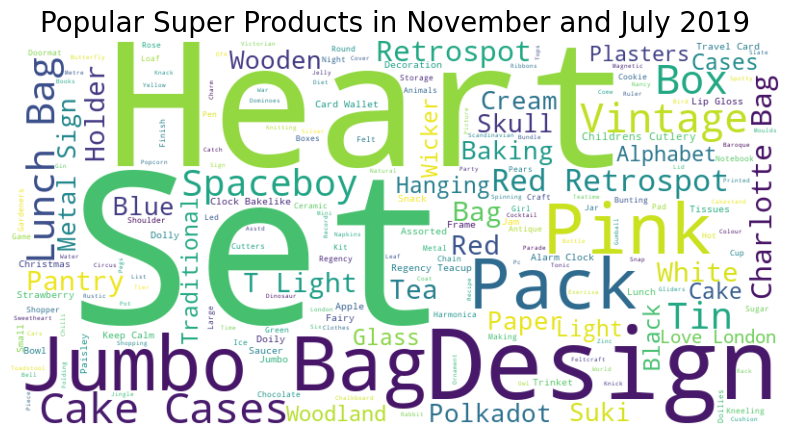

In [20]:
# Menggabungkan semua nilai dalam kolom 'ProductName' menjadi satu string
text = " ".join(super_popular_nov_jul19['ProductName'].astype(str))

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan Word Cloud menggunakan matplotlib dan menambahkan judul
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('Popular Super Products in November and July 2019', fontsize=20)  
plt.show()

In [21]:
# contoh produk super populer
df_classify[df_classify['ProductNo']=='85123A']

ProductNo                         ProductName  total_transaksi  \
0        85123A  Cream Hanging Heart T-Light Holder              178   
2508     85123A  Cream Hanging Heart T-Light Holder              146   
4838     85123A  Cream Hanging Heart T-Light Holder              194   
7271     85123A  Cream Hanging Heart T-Light Holder              182   
9660     85123A  Cream Hanging Heart T-Light Holder              231   
12048    85123A  Cream Hanging Heart T-Light Holder              149   
14606    85123A  Cream Hanging Heart T-Light Holder              175   
17222    85123A  Cream Hanging Heart T-Light Holder              152   
19752    85123A  Cream Hanging Heart T-Light Holder              183   
22426    85123A  Cream Hanging Heart T-Light Holder              171   
25207    85123A  Cream Hanging Heart T-Light Holder              269   
28079    85123A  Cream Hanging Heart T-Light Holder               71   

      vol_category Month_Name  revenue_total revenue_category   product_type  
0          Popular    January       72435.48          Popular  Super Popular  
2508       Popular   February       24500.80          Popular  Super Popular  
4838       Popular      March       26220.07          Popular  Super Popular  
7271       Popular      April       49651.78          Popular  Super Popular  
9660       Popular        May       53056.46          Popular  Super Popular  
12048      Popular       June       22038.71          Popular  Super Popular  
14606      Popular       July       39873.27          Popular  Super Popular  
17222      Popular     August       27322.14          Popular  Super Popular  
19752      Popular  September       32949.15          Popular  Super Popular  
22426      Popular    October       22408.53          Popular  Super Popular  
25207      Popular   November       57392.52          Popular  Super Popular  
28079      Popular   December        5564.09          Popular  Super Popular

In [22]:
print("summary Juli 2019:")
print(super_popular_jul19.describe())
print("summary November 2019:")
print(super_popular_nov19.describe())

summary Juli 2019:
       total_transaksi  revenue_total
count       342.000000     342.000000
mean         50.985380    7387.318012
std          30.560115    6097.376485
min          23.000000    2560.180000
25%          30.000000    3411.075000
50%          40.000000    5281.675000
75%          63.000000    9114.612500
max         187.000000   43201.890000
summary November 2019:
       total_transaksi  revenue_total
count       389.000000     389.000000
mean        104.529563   12462.660308
std          55.046159   13199.262386
min          44.000000    4483.510000
25%          68.000000    6143.110000
50%          89.000000    8876.000000
75%         124.000000   13916.080000
max         517.000000  159889.960000


In [118]:
super_popular_nov19.sort_values(by='revenue_total').tail(5)

ProductNo                         ProductName  total_transaksi  \
25220     84879       Assorted Colour Bird Ornament              212   
25207    85123A  Cream Hanging Heart T-Light Holder              269   
25203     22086      Paper Chain Kit 50'S Christmas              406   
25208     22197                      Popcorn Holder              256   
25202     23084                  Rabbit Night Light              517   

      vol_category Month_Name  revenue_total revenue_category   product_type  
25220      Popular   November       56538.85          Popular  Super Popular  
25207      Popular   November       57392.52          Popular  Super Popular  
25203      Popular   November       95293.96          Popular  Super Popular  
25208      Popular   November      123424.90          Popular  Super Popular  
25202      Popular   November      159889.96          Popular  Super Popular

Insight:
1. Arah yang sama dengan kondisi populer juga terjadi pada  kategori produk super populer dimana variasi jumlah produk bulan juli lebih banyak dibandingkan produk bulan November namun dari sisi penjualan atau revenue Bulan November menunjukkan performa penjualan yang jauh lebih tinggi. Namun lagi lagi terkait variasi revenue, juga tinggi. Hal ini menunjukkan kemungkinan ada permintaan besar di bulan November sehingga rata rata menjadi tinggi dan produk yang memberikan revenue terbesar adalah produk Rabbit Night Light, produk ini seperti dekorasi yang umumnya banyak digunakan untuk kegiatan perayaan natal.

# EKPLORASI TOP CONTRIBUTING PRODUCT (IMPROVEMENT)

In [29]:
super_popular[super_popular['ProductNo']=='85123A']

ProductNo                         ProductName  total_transaksi  \
0        85123A  Cream Hanging Heart T-Light Holder              178   
2508     85123A  Cream Hanging Heart T-Light Holder              146   
4838     85123A  Cream Hanging Heart T-Light Holder              194   
7271     85123A  Cream Hanging Heart T-Light Holder              182   
9660     85123A  Cream Hanging Heart T-Light Holder              231   
12048    85123A  Cream Hanging Heart T-Light Holder              149   
14606    85123A  Cream Hanging Heart T-Light Holder              175   
17222    85123A  Cream Hanging Heart T-Light Holder              152   
19752    85123A  Cream Hanging Heart T-Light Holder              183   
22426    85123A  Cream Hanging Heart T-Light Holder              171   
25207    85123A  Cream Hanging Heart T-Light Holder              269   
28079    85123A  Cream Hanging Heart T-Light Holder               71   

      vol_category Month_Name  revenue_total revenue_category   product_type  
0          Popular    January       72435.48          Popular  Super Popular  
2508       Popular   February       24500.80          Popular  Super Popular  
4838       Popular      March       26220.07          Popular  Super Popular  
7271       Popular      April       49651.78          Popular  Super Popular  
9660       Popular        May       53056.46          Popular  Super Popular  
12048      Popular       June       22038.71          Popular  Super Popular  
14606      Popular       July       39873.27          Popular  Super Popular  
17222      Popular     August       27322.14          Popular  Super Popular  
19752      Popular  September       32949.15          Popular  Super Popular  
22426      Popular    October       22408.53          Popular  Super Popular  
25207      Popular   November       57392.52          Popular  Super Popular  
28079      Popular   December        5564.09          Popular  Super Popular

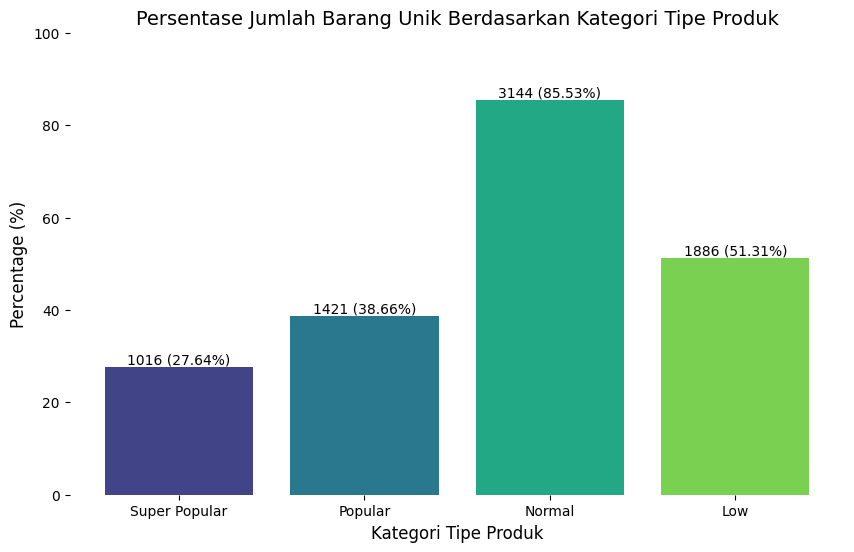

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan Jumlah barang berdasarkan product type tahun 2019
## product type
super_popular= df_classify[(df_classify['product_type'] == 'Super Popular') ]
popular= df_classify[(df_classify['product_type'] == 'Popular') ]
normal= df_classify[(df_classify['product_type'] == 'Normal') ]
low= df_classify[(df_classify['product_type'] == 'Low') ]

# Hitung jumlah barang unik berdasarkan productNo untuk setiap kategori
jml_super_popular_unique = super_popular['ProductNo'].nunique()
jml_popular_unique = popular['ProductNo'].nunique()
jml_normal_unique = normal['ProductNo'].nunique()
jml_low_unique = low['ProductNo'].nunique()

# Total pembagi
jumlah_produk_unik_2019 = df_classify['ProductNo'].nunique()

# Hitung persentase
percent_super_popular = (jml_super_popular_unique / jumlah_produk_unik_2019 ) * 100
percent_popular = (jml_popular_unique / jumlah_produk_unik_2019 ) * 100
percent_normal = (jml_normal_unique / jumlah_produk_unik_2019 ) * 100
percent_low = (jml_low_unique / jumlah_produk_unik_2019 ) * 100

# Data untuk plot
data = {
    'Product Type': ['Super Popular', 'Popular', 'Normal', 'Low'],
    'Count': [jml_super_popular_unique, jml_popular_unique, jml_normal_unique , jml_low_unique],
    'Percentage': [percent_super_popular, percent_popular, percent_normal, percent_low]
}

# Membuat DataFrame untuk plot
df_plot = pd.DataFrame(data)

# Plot grafik menggunakan matplotlib
plt.figure(figsize=(10, 6))
bars = plt.bar(df_plot['Product Type'], df_plot['Percentage'], color=sns.color_palette('viridis', len(df_plot)))

# Menambahkan label count dan persentase di atas bar
for bar in bars:
    height = bar.get_height()
    label = f"{df_plot['Count'][bars.index(bar)]} ({height:.2f}%)"
    plt.text(bar.get_x() + bar.get_width() / 2, height, label, ha='center', va='bottom')

# Menambahkan label dan judul
plt.xlabel('Kategori Tipe Produk')
plt.ylabel('Percentage (%)')
plt.title('Persentase Jumlah Barang Unik Berdasarkan Kategori Tipe Produk')
plt.ylim(0, 100)  # Set batas Y dari 0 hingga 100 persen

# Menambahkan label dan judul
plt.xlabel('Kategori Tipe Produk', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Persentase Jumlah Barang Unik Berdasarkan Kategori Tipe Produk', fontsize=14)
plt.ylim(0, 100)  # Set batas Y dari 0 hingga 100 persen

# Menghapus frame garis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan plot
plt.show()

In [24]:
# Melakuan uji ANOVA untuk mengetahui apakah ada perbedaan signifikan antara produk super populer, populer normal, dn normal
from scipy import stats

# Mengelompokkan data berdasarkan kategori produk
anova_df_classify19 = df_classify.groupby('product_type')['revenue_total'].apply(list)

# Lakukan uji ANOVA
f_statistic, p_value = stats.f_oneway(*anova_df_classify19)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 979.1298654658066
P-value: 0.0


Insight:
- berdasarkan uji hipotesis, diperoleh nilai p-value <0.05, artinya bahwa dengan tingkat signifikansi 5% terdapat perbedaan signifikan
    dalam rata-rata penjualan antara kategori produk.
- Produk dengan tipe kategori Normal adalah produk terbanyak dengan jumlah 3144 atau 85.53 persen dari total keseluruhan produk tahun 2019, hal ini dapat menunjukkan bahwa sebagian besar pelanggan memiliki total pendapatan yang seimbang dan cenderung berbelanja dalam jumlah menengah (stabil).
- selain itu kedua terbanyak adalah produk dengan kategori Low, yang  mengindikasikan adanya sekelompok pelanggan dengan total penjualan rendah yang cenderung melakukan pembelian dalam jumlah yang lebih sedikit.
- perlu dilakukan eksplorasi mengenai keempat kategori produk tersebut sehingga perusahaan dapat mengoptimalkan strategi yang tepat

Jumlah produk unik yang konsisten sebagai Popular atau Super Popular di setiap bulan: 125


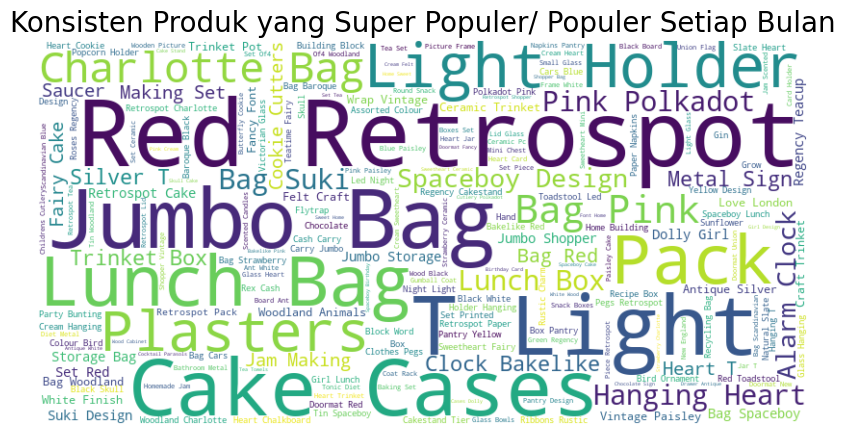

In [25]:
# Filter untuk kategori yang diinginkan
df_popular_or_super = df_classify[df_classify['product_type'].isin(['Popular', 'Super Popular'])]

# Bulan yang unik dalam dataframe
unique_months = df_classify['Month_Name'].unique()

# Fungsi untuk mendapatkan produk yang konsisten di setiap bulan
def get_consistent_products(products_df):
    consistent_products = set(products_df[products_df['Month_Name'] == unique_months[0]]['ProductNo'])
    for month in unique_months:
        products_in_month = set(products_df[products_df['Month_Name'] == month]['ProductNo'])
        consistent_products &= products_in_month
    return products_df[products_df['ProductNo'].isin(consistent_products)]

# Mendapatkan produk yang konsisten di setiap bulan untuk kategori `Popular` dan `Super Popular`
consistent_products_df = get_consistent_products(df_popular_or_super)

# Menampilkan jumlah produk unik yang konsisten setiap bulan
unique_product_count = consistent_products_df['ProductNo'].nunique()
print(f"Jumlah produk unik yang konsisten sebagai Popular atau Super Popular di setiap bulan: {unique_product_count}")

# Menggabungkan semua nilai dalam kolom 'ProductName' menjadi satu string
text = " ".join(consistent_products_df['ProductName'].astype(str))

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan Word Cloud menggunakan matplotlib dan menambahkan judul
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('Konsisten Produk yang Super Populer/ Populer Setiap Bulan', fontsize=20)  
plt.show()

In [26]:
# Filter dataframe untuk produk super populer
super_popular_products = df_classify[df_classify['product_type'] == 'Super Popular']

# Hitung berapa kali setiap produk muncul di setiap bulan untuk super popular
super_popular_counts = super_popular_products.groupby(['ProductNo', 'Month_Name']).size().reset_index(name='count')

# Hitung revenue total setiap produk di setiap bulan
product_revenue = super_popular_products.groupby(['ProductNo', 'ProductName', 'Month_Name'])['revenue_total'].sum().reset_index()

# Daftar bulan yang unik 
unique_months = df_classify['Month_Name'].unique()

# Inisialisasi set untuk menyimpan produk yang muncul di setiap bulan
consistent_products = set(super_popular_products['ProductNo'].unique())

# Iterasi melalui setiap bulan
for month in unique_months:
    # Filter data untuk bulan tertentu
    products_in_month = super_popular_counts[super_popular_counts['Month_Name'] == month]['ProductNo']
    # Update set produk konsisten dengan bulan tersebut
    consistent_products = consistent_products.intersection(set(products_in_month))
    
# Tampilkan produk yang super populer dan sama di setiap bulan
consistent_products_df = super_popular_products[super_popular_products['ProductNo'].isin(consistent_products)]

# Menghitung total revenue untuk produk yang konsisten
consistent_revenue = consistent_products_df.groupby(['ProductNo', 'ProductName'])['revenue_total'].sum().reset_index()

# Mengambil top 5 produk dengan revenue terbesar
top_5_consistent_products = consistent_revenue.sort_values(by='revenue_total', ascending=False).head(5)

print("Barang yang selalu memiliki performa 'super populer' setiap bulan:")
consistent_revenue


Barang yang selalu memiliki performa 'super populer' setiap bulan:


ProductNo                          ProductName  revenue_total
0      20712           Jumbo Bag Woodland Animals       58983.40
1      20719               Woodland Charlotte Bag      136612.99
2      20723             Strawberry Charlotte Bag      103705.10
3      20724          Red Retrospot Charlotte Bag      186029.04
4      20725              Lunch Bag Red Retrospot      114400.65
5      20727                Lunch Bag Black Skull       71167.80
6      20914  Set/5 Red Retrospot Lid Glass Bowls       74741.66
7      20972    Pink Cream Felt Craft Trinket Box       79008.17
8      21080   Set/20 Red Retrospot Paper Napkins      134916.30
9      21175        Gin And Tonic Diet Metal Sign      144526.72
10     21212      Pack Of 72 Retrospot Cake Cases      346656.85
11     21232       Strawberry Ceramic Trinket Pot      115396.60
12     21731        Red Toadstool Led Night Light      141417.10
13     21790                   Vintage Snap Cards      145389.72
14     21931               Jumbo Storage Bag Suki      159975.62
15     21977   Pack Of 60 Pink Paisley Cake Cases      246047.71
16     22029               Spaceboy Birthday Card       81196.25
17     22077               6 Ribbons Rustic Charm       99543.40
18     22138         Baking Set 9 Piece Retrospot       70751.70
19     22139      Retrospot Tea Set Ceramic 11 Pc       64778.86
20     22178      Victorian Glass Hanging T-Light      258551.57
21     22189              Cream Heart Card Holder       76442.45
22     22197                       Popcorn Holder      556672.75
23     22326   Round Snack Boxes Set Of4 Woodland      101437.27
24     22355            Charlotte Bag Suki Design      181310.71
25     22356          Charlotte Bag Pink Polkadot       99683.92
26     22382            Lunch Bag Spaceboy Design       60324.42
27     22386              Jumbo Bag Pink Polkadot      128746.55
28     22411    Jumbo Shopper Vintage Red Paisley      143272.59
29     22423             Regency Cakestand 3 Tier      257364.46
30     22457       Natural Slate Heart Chalkboard      106003.02
31     22467                    Gumball Coat Rack       90269.60
32     22551             Plasters In Tin Spaceboy       87888.09
33     22554     Plasters In Tin Woodland Animals       85665.06
34     22556        Plasters In Tin Circus Parade       65423.95
35     22558       Clothes Pegs Retrospot Pack 24       86500.57
36     22616            Pack Of 12 London Tissues      242636.23
37     22629                   Spaceboy Lunch Box      156931.52
38     22630                 Dolly Girl Lunch Box      134103.51
39     22666      Recipe Box Pantry Yellow Design      100475.36
40     22697      Green Regency Teacup And Saucer       88202.58
41     22699      Roses Regency Teacup And Saucer      120883.48
42     22727             Alarm Clock Bakelike Red       94241.65
43     22951      60 Cake Cases Dolly Girl Design       73523.16
44     22960             Jam Making Set With Jars      112604.06
45     22961               Jam Making Set Printed      166292.24
46     22969         Homemade Jam Scented Candles      131483.40
47     47566                        Party Bunting      282929.05
48     82482    Wooden Picture Frame White Finish      106322.35
49     82484    Wood Black Board Ant White Finish       72491.64
50     84692          Box Of 24 Cocktail Parasols       74635.55
51     84879        Assorted Colour Bird Ornament      392931.44
52     84946         Antique Silver T-Light Glass      192436.55
53     84978     Hanging Heart Jar T-Light Holder      139318.87
54     84992       72 Sweetheart Fairy Cake Cases      125832.85
55    84997D      Childrens Cutlery Polkadot Pink       69692.22
56    85099B              Jumbo Bag Red Retrospot      284112.08
57    85099C        Jumbo Bag Baroque Black White       80215.58
58    85099F                 Jumbo Bag Strawberry      102772.44
59    85123A   Cream Hanging Heart T-Light Holder      433413.00

In [27]:
print("\nBarang yang selalu memiliki performa top 5 'super populer' berdasarkan revenue setiap bulan:")
print(top_5_consistent_products)


Barang yang selalu memiliki performa top 5 'super populer' berdasarkan revenue setiap bulan:
   ProductNo                         ProductName  revenue_total
22     22197                      Popcorn Holder      556672.75
59    85123A  Cream Hanging Heart T-Light Holder      433413.00
51     84879       Assorted Colour Bird Ornament      392931.44
10     21212     Pack Of 72 Retrospot Cake Cases      346656.85
56    85099B             Jumbo Bag Red Retrospot      284112.08


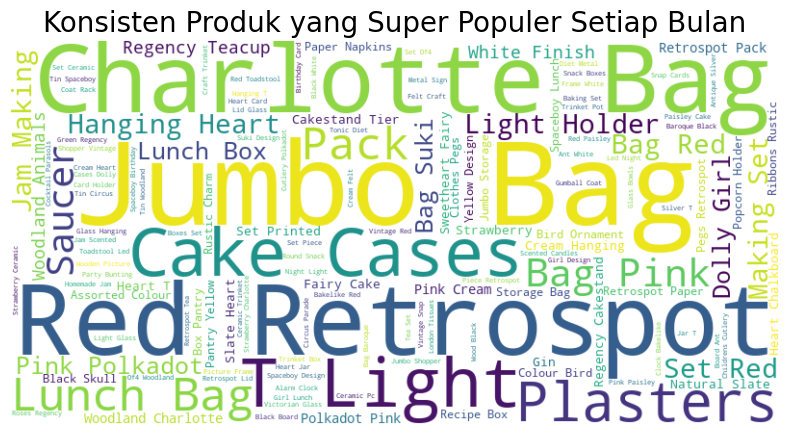

In [28]:
# Menggabungkan semua nilai dalam kolom 'ProductName' menjadi satu string
text = " ".join(consistent_products_df['ProductName'].astype(str))

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan Word Cloud menggunakan matplotlib dan menambahkan judul
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('Konsisten Produk yang Super Populer Setiap Bulan', fontsize=20)  
plt.show()

Barang yang selalu memiliki performa 'low' selama 9 bulan lebih:
                           ProductName
2214  Silver Hoop Earrings With Flower
2257    Drop Diamante Earrings Crystal
4489       Ruby Glass Cluster Bracelet
4505        Blue Murano Twist Bracelet
4562     Classic Diamante Earrings Jet
4759                Mrs Robot Soft Toy

Jumlah barang performa low selama 9 bulan lebih tahun 2019: 6


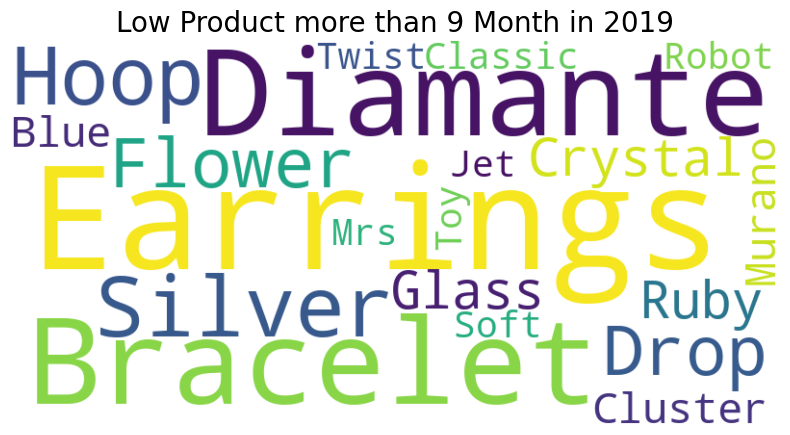

In [29]:
# MENAMPILKAN PRODUK YANG LOW 9 BULAN LEBIH Tahun 2019

# Filter dataframe untuk hanya produk dengan performa "low"
low_performance_products = df_classify[df_classify['product_type'] == 'Low']

# Dapatkan daftar bulan yang unik dalam dataframe
unique_months = df_classify['Month_Name'].unique()

# Hitung jumlah bulan yang unik
total_months = len(unique_months)

# Hitung berapa kali setiap produk muncul di setiap bulan dengan performa "low"
product_counts = low_performance_products.groupby('ProductNo').size().reset_index(name='month_count')

# Filter produk yang muncul di setiap bulan dengan performa "low" selama 6 bulan terakhir
consistent_low_products = product_counts[product_counts['month_count'] >= 9]['ProductNo']

# Tampilkan produk yang selalu memiliki performa "low" di setiap bulan
consistent_low_products_df = low_performance_products[low_performance_products['ProductNo'].isin(consistent_low_products)][['ProductName']].drop_duplicates()

print("Barang yang selalu memiliki performa 'low' selama 9 bulan lebih:")
print(consistent_low_products_df)

# Menampilkan jumlah barang super populer setiap bulan tahun 2019
print(f"\nJumlah barang performa low selama 9 bulan lebih tahun 2019: {len(consistent_low_products_df)}")

# Menggabungkan semua nilai dalam kolom 'ProductName' menjadi satu string
text = " ".join(consistent_low_products_df['ProductName'].astype(str))

# Membuat Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan Word Cloud menggunakan matplotlib dan menambahkan judul
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('Low Product more than 9 Month in 2019', fontsize=20)  
plt.show()

In [126]:
# contoh nya
df_classify[df_classify['ProductNo']=='22197']

ProductNo     ProductName  total_transaksi vol_category Month_Name  \
25        22197  Popcorn Holder               74      Popular    January   
2526      22197  Popcorn Holder               76      Popular   February   
4866      22197  Popcorn Holder               92      Popular      March   
7302      22197  Popcorn Holder               74      Popular      April   
9686      22197  Popcorn Holder              107      Popular        May   
12070     22197  Popcorn Holder              102      Popular       June   
14635     22197  Popcorn Holder               96      Popular       July   
17252     22197  Popcorn Holder               81      Popular     August   
19768     22197  Popcorn Holder              127      Popular  September   
22432     22197  Popcorn Holder              149      Popular    October   
25208     22197  Popcorn Holder              256      Popular   November   
28081     22197  Popcorn Holder               68      Popular   December   

       revenue_total revenue_category   product_type  
25          20230.20          Popular  Super Popular  
2526        29510.04          Popular  Super Popular  
4866        31841.37          Popular  Super Popular  
7302        20691.56          Popular  Super Popular  
9686        75492.88          Popular  Super Popular  
12070       23224.20          Popular  Super Popular  
14635       20808.24          Popular  Super Popular  
17252       59809.64          Popular  Super Popular  
19768       46709.49          Popular  Super Popular  
22432       65487.78          Popular  Super Popular  
25208      123424.90          Popular  Super Popular  
28081       39442.45          Popular  Super Popular

In [30]:
#  6 Produk Low
consistent_low_products_df = low_performance_products[low_performance_products['ProductNo'].isin(consistent_low_products)][['ProductNo', 'ProductName','revenue_total']].drop_duplicates()
consistent_low_products_revenue = consistent_low_products_df.groupby([ 'ProductName'])['revenue_total'].sum().reset_index()

In [31]:
top_products_earrings_bracelet.reset_index('ProductName', inplace=True)
consistent_low_products_revenue.reset_index('ProductName', inplace=True)

NameError: name 'top_products_earrings_bracelet' is not defined

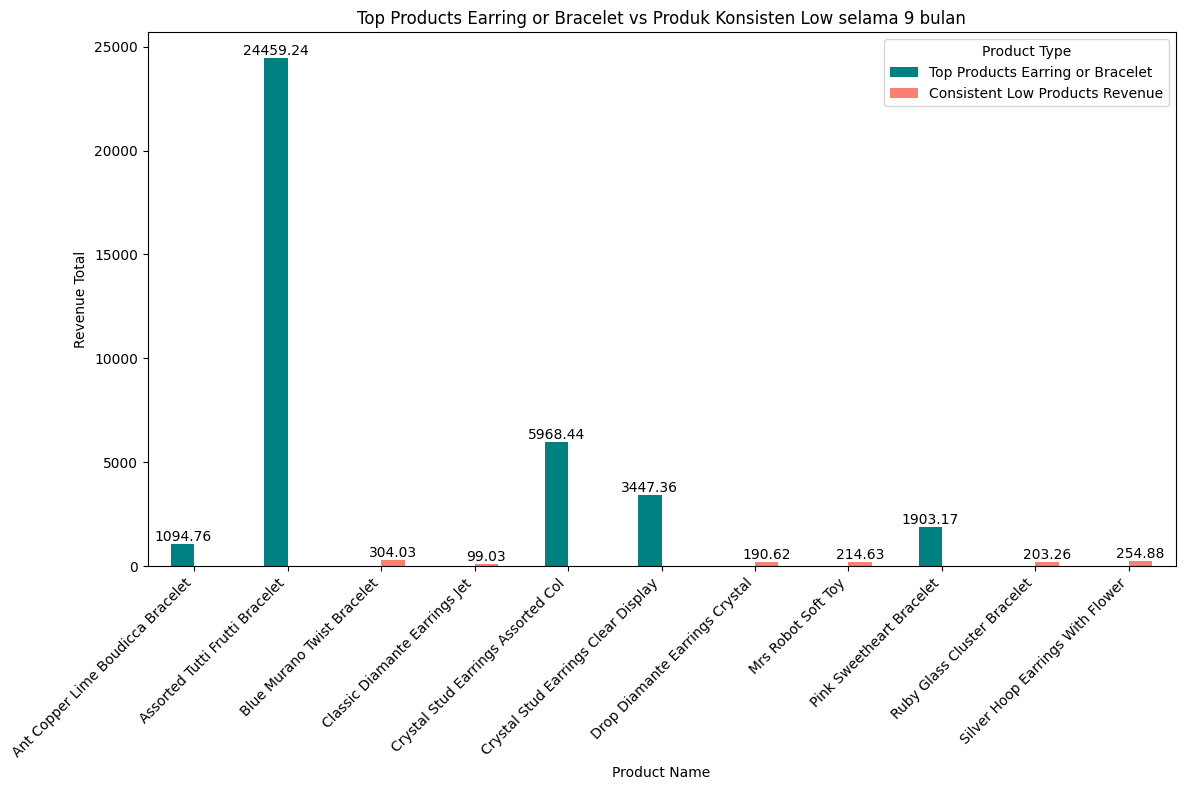

In [32]:
# Filter produk yang mengandung kata 'Earrings' atau 'Bracelet'
filtered_products = df_classify[
    df_classify['ProductName'].str.contains('Earrings|Bracelet', case=False, na=False)
]

# Agregasi revenue_total berdasarkan produk yang unik
unique_products_revenue = filtered_products.groupby('ProductName')['revenue_total'].sum().reset_index()

# Urutkan berdasarkan revenue_total dari yang terbesar dan ambil top 5
top_products_earrings_bracelet = unique_products_revenue.sort_values(by='revenue_total', ascending=False).head(5)

# Set index untuk penggabungan
top_products_earrings_bracelet.set_index('ProductName', inplace=True)
consistent_low_products_revenue.set_index('ProductName', inplace=True)

# Gabungkan data dengan reindexing
all_products = pd.Index(top_products_earrings_bracelet .index).union(consistent_low_products_revenue.index)
combined_df = pd.DataFrame(index=all_products)
combined_df = combined_df.join(top_products_earrings_bracelet, how='left').fillna(0)
combined_df = combined_df.join(consistent_low_products_revenue, how='left', lsuffix='_top', rsuffix='_low').fillna(0)

# Rename kolom
combined_df.columns = ['Top Products Earring or Bracelet', 'Consistent Low Products Revenue']

# Plot Bar Chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Bar Chart
combined_df[['Top Products Earring or Bracelet', 'Consistent Low Products Revenue']].plot(kind='bar', ax=ax, color=['teal', 'salmon'])

# Menambahkan label
ax.set_xlabel('Product Name')
ax.set_ylabel('Revenue Total')
ax.set_title('Top Products Earring or Bracelet vs Produk Konsisten Low selama 9 bulan')
ax.legend(title='Product Type')


# Menambahkan anotasi pada setiap bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Menampilkan anotasi hanya jika nilai lebih besar dari nol
        x = p.get_x() + p.get_width() / 2
        y = height
        value = f'{height:.2f}'
        ax.text(x, y, value, ha='center', va='bottom', color='black', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


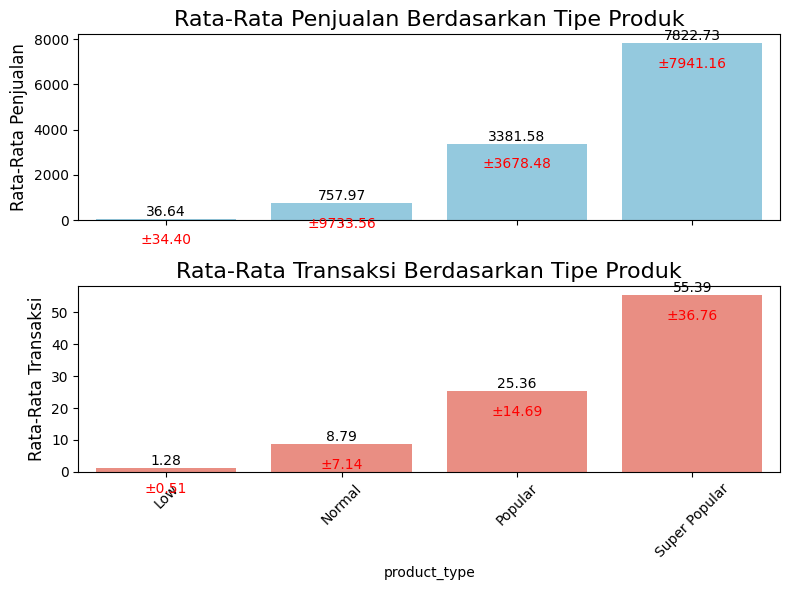

In [33]:
# Menghitung rata-rata dan standar deviasi berdasarkan product_type
summary = df_classify.groupby('product_type').agg(
    avg_revenue_total=('revenue_total', 'mean'),
    std_revenue_total=('revenue_total', 'std'),
    avg_total_transaksi=('total_transaksi', 'mean'),
    std_total_transaksi=('total_transaksi', 'std')
).reset_index()

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Bar plot untuk revenue_total
sns.barplot(x='product_type', y='avg_revenue_total', data=summary, ax=ax[0], color='skyblue')
ax[0].set_title('Rata-Rata Penjualan Berdasarkan Tipe Produk', fontsize=16)
ax[0].set_ylabel('Rata-Rata Penjualan', fontsize=12)

# Menambahkan angka dan deviasi standar di atas bar
for p in ax[0].patches:
    height = p.get_height()
    product_type = p.get_x() + p.get_width() / 2
    product_type_label = summary['product_type'].iloc[int(product_type)]
    std_dev = summary.loc[summary['product_type'] == product_type_label, 'std_revenue_total'].values[0]
    ax[0].annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, 5),
                   textcoords='offset points', fontsize=10)
    ax[0].annotate(f'±{std_dev:.2f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, -15),
                   textcoords='offset points', fontsize=10, color='red')

# Bar plot untuk total_transaksi
sns.barplot(x='product_type', y='avg_total_transaksi', data=summary, ax=ax[1], color='salmon')
ax[1].set_title('Rata-Rata Transaksi Berdasarkan Tipe Produk', fontsize=16)
ax[1].set_ylabel('Rata-Rata Transaksi', fontsize=12)

# Menambahkan angka dan deviasi standar di atas bar
for p in ax[1].patches:
    height = p.get_height()
    product_type = p.get_x() + p.get_width() / 2
    product_type_label = summary['product_type'].iloc[int(product_type)]
    std_dev = summary.loc[summary['product_type'] == product_type_label, 'std_total_transaksi'].values[0]
    ax[1].annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, 5),
                   textcoords='offset points', fontsize=10)
    ax[1].annotate(f'±{std_dev:.2f}', (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center', xytext=(0, -15),
                   textcoords='offset points', fontsize=10, color='red')

# Menampilkan plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
KESIMPULAN : TOP CONTRIBUTING PRODUCT

a. 
Terdapat perbedaan barang yang super populer, populer, normal, dan low setiap bulan selama tahun 2019.
1. Total barang super populer pada November 2019 sebanyak 389 dengan nama produk yang paling sering muncul adalah produk dengan kata yang mengandung "Christmas", "Decoration", "Set", "Jumbo", "Water Bottle" etc.
2. Total barang populer di bulan Juli 2019 sebanyak 320 dan November sebanyak 2779. Namun hanya sebanyak 74 barang yang sama sama kategori popular baik dibulan Juli maupun November. Adapun potongan kata nama produk yang sering muncul adalah produk dengan nama yang mengandung kata "Box", "Pencil","Wood","Design", "Set" etc.
3. Total barang super populer Juli sebanyak 342 dan November sebanyak 389 dan sebanyak 171 produk memiliki kategori super populer dikedua bulan tersebut. adapun produk yang paling sering muncul adalah produk dengan kata "Set","Lunch Bag","Design" etc.
4.  baik populer maupun kategori produk super populer bulan juli dan November menunjukkan kesamaan bahwa dibulan juli terlihat bahwa variasi produk pada bulan juli lebih banyak dibandingkan bulan november namun jika dilihat dari revenue rata rata revenue dibulan November lebih tinggi dibandingkan bulan juli. Hal ini dapat memberikan gambaran jika ada perbedaan strategi, pada kedua bulan tersebut, maka perlu dilakukan evaluasi bagaimana strategi yang tepat untuk peningkatan penjualan yang diiringi peningkatakan variasi produk di periode selanjutnya 
5. Selain itu, dari hasil ekplorasi ditemukan bahwa 60 dari 30849 produk merupakan produk yang konsisten sangat populer disetiap bulan dengan top 5 produk yang memberikan total revenue terbesar adalah produk

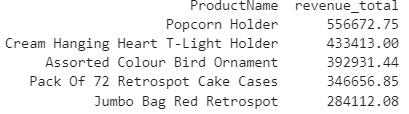

6. Sedangkan terdapat 6 produk yang memiliki performa low selama 9 bulan lebih 

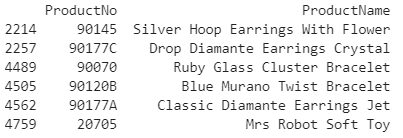

- jika dilihat peerforma produk yang earrings yang merupakan produk barang yang tidak habis pakai mungkin tidak setiap waktu beli namun jika dilihat secara keseluruhan terdapat produk earring atau bracelet yang memiliki revenue tinggi dan 5 besar produk earring atau bracelet yang memeliki revenue lebih tinggi menampilkan satu karakteristik yang mecolok dibandingkan kelima produk dengan performa low diatas yaitu tipe populernya lebih condong ke gaya modern dan berwarna
---

# Retention Cohort Analysis

Analisis kohort adalah metode analisis yang digunakan untuk mempelajari perilaku konsumen atau pengguna dari kelompok yang sama dalam periode waktu tertentu.   
Contoh Kohort : Kohort kustomer yang bergabung pada bulan mei

Analisis retensi adalah analisis untuk melihat seberapa besar persentase pengguna atau pelanggan yang kembali menggunakan produk atau layanan dalam periode waktu tertentu.

Dengan menganalisis kohort dan retensi, perusahaan atau organisasi dapat mengidentifikasi tren dan pola dalam perilaku pengguna atau pelanggan.

Berikut cuplikan matriks retensi yang akan kalian hasilkan pada bagian ini : 

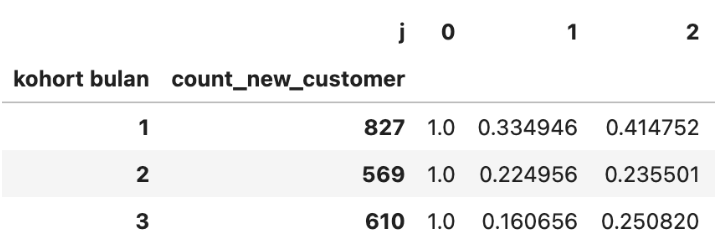

Cara baca :  
Pada bulan januari, ada 827 customer baru.  
33% dari 827 customer melakukan transaksi 1 bulan kemudian.  
41.4% dari 827 customer melakukan transasksi 2 bulan kemduain.  

Hal ini menunjukkan bahwa sekitar sepertiga customer yang melanjutkan transaksi setelah mendaftar pada bulan januari.  

Sedangkan pada kohort bulan februari, ada 569 customer baru dan hanya 22% customer yang kembali bertransaksi sebulan setelahnya

Buatlah matriks kohort retensi per bulan menggunakan data dari 1 januari 2019 hingga 30 november 2019
Petunjuk : 
1. Hitung tanggal berapa transaksi pertama customer. Disini kita menggunakna asumsi bahwa transaksi pertama pada tahun 2019 adalah transaksi pertama customer.
2. Lakukan iterasi untuk setiap bulan. Ambil berapa banyak customer yang mendaftar dan berapa banyak customer yang sama yang melakukan transaksi di bulan bulan berikutnya.

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

In [34]:
# ANALISI COHORT CUSTOMER RETAINED AND NEW CUSTOMER
# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from operator import attrgetter

# machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Filter data untuk rentang tanggal 1 Januari 2019 sampai 30 November 2019
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2019-11-30')
df_sales_filtered = df_sales[(df_sales['Date'] >= start_date) & (df_sales['Date'] <= end_date)].copy()

# Membuat kolom order_month
df_sales_filtered['order_month'] = df_sales_filtered['Date'].dt.to_period('M')

# Hitung tanggal berapa transaksi pertama customer dan seterusnya
df_sales_filtered['cohort'] = df_sales_filtered.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')
df_cohort = df_sales_filtered.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerNo', 'nunique')).reset_index()

# Hitung period_number
df_cohort['period_number'] = (df_cohort['order_month'] - df_cohort['cohort']).apply(lambda x: x.n)

# Melakukan agregasi untuk setiap bulan
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

# Tampilkan pivot table
cohort_pivot

period_number     0      1      2      3      4      5      6      7      8   \
cohort                                                                         
2019-01        827.0  277.0  343.0  309.0  361.0  336.0  310.0  305.0  341.0   
2019-02        569.0  128.0  134.0  182.0  171.0  146.0  161.0  178.0  170.0   
2019-03        610.0   98.0  153.0  134.0  148.0  109.0  168.0  149.0  182.0   
2019-04        397.0   89.0   82.0   87.0   80.0   98.0   98.0  117.0    NaN   
2019-05        374.0   69.0   67.0   67.0   80.0   85.0  102.0    NaN    NaN   
2019-06        309.0   57.0   46.0   66.0   67.0   91.0    NaN    NaN    NaN   
2019-07        242.0   37.0   46.0   53.0   73.0    NaN    NaN    NaN    NaN   
2019-08        192.0   38.0   45.0   45.0    NaN    NaN    NaN    NaN    NaN   
2019-09        312.0   77.0  106.0    NaN    NaN    NaN    NaN    NaN    NaN   
2019-10        353.0   82.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2019-11        334.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

period_number     9      10  
cohort                       
2019-01        337.0  409.0  
2019-02        202.0    NaN  
2019-03          NaN    NaN  
2019-04          NaN    NaN  
2019-05          NaN    NaN  
2019-06          NaN    NaN  
2019-07          NaN    NaN  
2019-08          NaN    NaN  
2019-09          NaN    NaN  
2019-10          NaN    NaN  
2019-11          NaN    NaN

period_number   0         1         2         3         4         5   \
cohort                                                                 
2019-01        1.0  0.334946  0.414752  0.373640  0.436518  0.406288   
2019-02        1.0  0.224956  0.235501  0.319859  0.300527  0.256591   
2019-03        1.0  0.160656  0.250820  0.219672  0.242623  0.178689   
2019-04        1.0  0.224181  0.206549  0.219144  0.201511  0.246851   
2019-05        1.0  0.184492  0.179144  0.179144  0.213904  0.227273   
2019-06        1.0  0.184466  0.148867  0.213592  0.216828  0.294498   
2019-07        1.0  0.152893  0.190083  0.219008  0.301653       NaN   
2019-08        1.0  0.197917  0.234375  0.234375       NaN       NaN   
2019-09        1.0  0.246795  0.339744       NaN       NaN       NaN   
2019-10        1.0  0.232295       NaN       NaN       NaN       NaN   
2019-11        1.0       NaN       NaN       NaN       NaN       NaN   

period_number        6         7         8         9         10

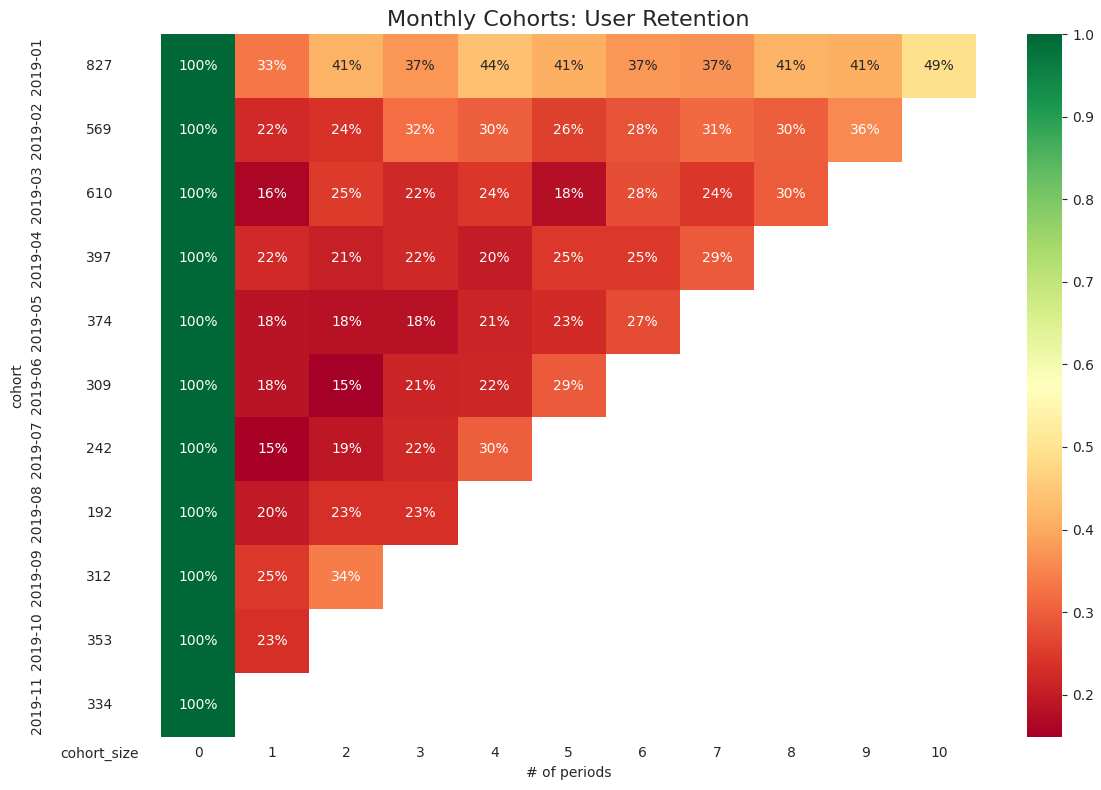

In [35]:
# Melakukan visualisasi analisis retention
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()
    print(retention_matrix)

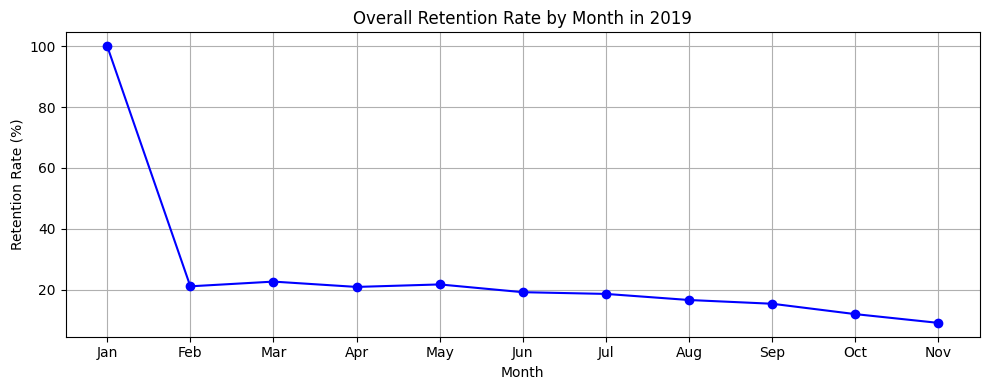

In [36]:
def overall_retention_by_timestep(cohort_pivot):
    # Menghitung jumlah pelanggan yang tetap ada di setiap time step
    overall_retention = cohort_pivot.sum()

    # Menghitung retention rate dalam persentase
    overall_retention_rate = round(overall_retention / overall_retention.max() * 100, 2)

    # Membuat DataFrame untuk hasil overall retention rate
    overall_retention_df = pd.DataFrame({
        'Retained Customers ': overall_retention,
        'Retention Rate %': overall_retention_rate
    })

    return overall_retention_df

# Menggunakan fungsi overall_retention_by_timestep dengan pivot table cohort_pivot
overall_retention_df = overall_retention_by_timestep(cohort_pivot).reset_index()

# Menampilkan dalam bentuk line plot
plt.figure(figsize=(10, 4))
plt.plot(overall_retention_df['period_number'], overall_retention_df['Retention Rate %'], marker='o', linestyle='-', color='b')
plt.title('Overall Retention Rate by Month in 2019')
plt.xlabel('Month')
plt.ylabel('Retention Rate (%)')
plt.xticks(overall_retention_df['period_number'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Filter data untuk rentang tanggal 1 Januari 2019 sampai 30 November 2019
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2019-11-30')
df_filtered = df_sales[(df_sales['Date'] >= start_date) & (df_sales['Date'] <= end_date)]

# Hitung customer active, new joiner, dan retained untuk setiap bulan
df_filtered['order_month'] = df_filtered['Date'].dt.to_period('M')
df_filtered['cohort'] = df_filtered.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')

# Menghitung jumlah customer yang aktif setiap bulan
total_active_customers = df_filtered.groupby('order_month').agg({
    'CustomerNo': 'nunique'
}).reset_index()
total_active_customers.rename(columns={'CustomerNo': 'Total Count Of Active CustomerNo'}, inplace=True)

# Menghitung jumlah customer baru yang bergabung setiap bulan
new_joiner_customers = df_filtered[df_filtered['order_month'] == df_filtered['cohort']].groupby('order_month').agg({
    'CustomerNo': 'nunique'
}).reset_index()
new_joiner_customers.rename(columns={'CustomerNo': 'Total Count Of New Joiner CustomerNo'}, inplace=True)

# Menggabungkan hasil di atas
total_active_customer = pd.merge(total_active_customers, new_joiner_customers, on='order_month', how='left')

# Menghitung jumlah retained customers
total_active_customer['Total Count Of Retained CustomerNo'] = (
    total_active_customer['Total Count Of Active CustomerNo'] - 
    total_active_customer['Total Count Of New Joiner CustomerNo']
)

# Menampilkan hasil dalam bentuk DataFrame
print("Monthly Customer Summary:")
total_active_customer


Monthly Customer Summary:


C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\1912275255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_month'] = df_filtered['Date'].dt.to_period('M')
C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\1912275255.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cohort'] = df_filtered.groupby('CustomerNo')['Date'].transform('min').dt.to_period('M')


order_month  Total Count Of Active CustomerNo  \
0      2019-01                               827   
1      2019-02                               846   
2      2019-03                              1081   
3      2019-04                               938   
4      2019-05                              1159   
5      2019-06                              1101   
6      2019-07                              1057   
7      2019-08                               997   
8      2019-09                              1327   
9      2019-10                              1434   
10     2019-11                              1743   

    Total Count Of New Joiner CustomerNo  Total Count Of Retained CustomerNo  
0                                    827                                   0  
1                                    569                                 277  
2                                    610                                 471  
3                                    397                                 541  
4                                    374                                 785  
5                                    309                                 792  
6                                    242                                 815  
7                                    192                                 805  
8                                    312                                1015  
9                                    353                                1081  
10                                   334                                1409

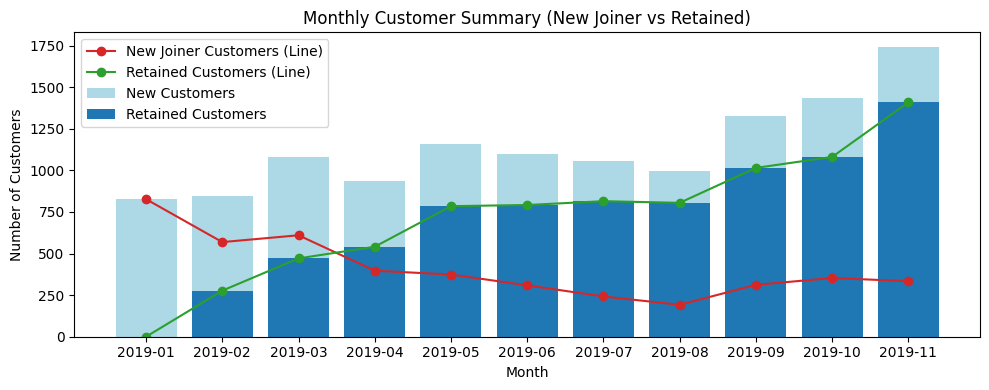

In [38]:
# Mengatur index menjadi order_month untuk memudahkan plotting
total_active_customer.set_index('order_month', inplace=True)

# Membuat figure
plt.figure(figsize=(10, 4))

# Plot bar plot dengan jenis stacked untuk New Joiner Customers dan Retained Customers
bars1 = plt.bar(total_active_customer.index.astype(str), total_active_customer['Total Count Of New Joiner CustomerNo'] + total_active_customer['Total Count Of Retained CustomerNo'], label='New Customers', color='lightblue')
bars2 = plt.bar(total_active_customer.index.astype(str), total_active_customer['Total Count Of Retained CustomerNo'], label='Retained Customers', color='tab:blue')

# Plot line plot untuk Total Count Of New Joiner CustomerNo
plt.plot(total_active_customer.index.astype(str), total_active_customer['Total Count Of New Joiner CustomerNo'], marker='o', linestyle='-', color='tab:red', label='New Joiner Customers (Line)')
plt.plot(total_active_customer.index.astype(str), total_active_customer['Total Count Of Retained CustomerNo'], marker='o', linestyle='-', color='tab:green', label='Retained Customers (Line)')

# Menambahkan label dan judul
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Monthly Customer Summary (New Joiner vs Retained)')
plt.xticks(total_active_customer.index.astype(str), total_active_customer.index.astype(str))
plt.legend()

# Menampilkan plot
plt.tight_layout()
plt.show()

---

## Pertanyaan
1. Bagaimana karakteristik pertumbuhan customer baru? Apakah pertumbuhan terus meningkat atau melambat?

2. Setiap bulannya tim marketing menggunakan metode promosi campaign yang berbeda-beda. Bulan mana yang menghasilkan retention paling tinggi?

---
## Jawaban
1. berdasarkan hasil eksplorasi, pertumbuhan customer baru mengalami penurunan sejak januari 2019 hingga November sebaliknya customer retained (pelanggan loyal/tetap) mengalami peningkatan jumlahnya setiap bulan dari januari hingga November
2. Bulan November adalah bulan yang menghasilkan retained customer paling tinggi disusul bulan Juni dan Juli sedangkan terjadi Penurunan Retention Rate Pada Kohort Tengah-Tengah: Kohort Februari hingga September (kecuali juni-juli), yang menunjukkan bahwa pelanggan yang bergabung pada bulan-bulan tersebut cenderung tetap aktif dalam periode awal, tetapi retention rate mereka kemudian turun.

rekomendasi
- Strategi "New Customer": Perusahaan dapat mengembangkan strategi khusus untuk memasarkan dan menjual produk kepada customer baru dengan penawaran khusus
- Pemantauan dan Optimalkan "Retained Customer": jika hasil tersebut menunjukkan keberhasilan pencapaian KPI, perusahaan dapat mempertimbangkan untuk lebih fokus pada peningkatan quantitas produk yang dibelanjakan oleh retained customer dengan mengeksplorasi dan inovasi untuk menarik customer tetap perusahaan tersebut misalnya melalui promo untuk customer yang berbelanjar minimal pembelian.
- Perusahaan perlu mempertimbangkan strategi retensi khusus untuk kohort yang mengalami penurunan retention rate, yaitu kohort Februari hingga September. Ini bisa melibatkan program loyalitas, peningkatan layanan pelanggan, atau insentif khusus untuk mempertahankan pelanggan dalam jangka panjang.
- Analisis Lebih Lanjut pada Kohort Juni dan Juli: Karena kohort Juni dan Juli mengalami peningkatan retention rate pada bulan November, perusahaan harus memahami faktor-faktor apa yang berkontribusi pada peningkatan tersebut. Apakah ada promosi tertentu atau perubahan dalam pengalaman pelanggan yang perlu ditingkatkan dan diterapkan pada kohort lain?
---

# Time Series Analysis

Time series analysis adalah analisis untuk melihat trend suatu fenomena berdasarkan waktu.

## Pertanyaan 

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.



In [56]:
# Menghitung total penjualan dan jumlah order setiap barang per hari
daily_sales = df_sales.groupby('Date').agg({
    'revenue_total': 'sum', # Menghitung total penjualan
    'TransactionNo': 'nunique',
    'revenue_total': 'mean'
}).reset_index()

# Rename kolom untuk jelasnya
daily_sales = daily_sales.rename(columns={
    'revenue_total': 'revenue_total',
    'TransactionNo': 'order_total'
})

# Melakukan rekap harian total
daily_summary_total = daily_sales.groupby('Date').sum().reset_index()

# Tampilkan rekap harian total
print("\nRekap Harian Total Revenue:")
daily_summary_total.sort_values(by='Date')


Rekap Harian Total Revenue:


Date  revenue_total  order_total
0   2018-12-01     106.769056          127
1   2018-12-02     178.569091          141
2   2018-12-03      96.588773           68
3   2018-12-05      73.335290           88
4   2018-12-06      71.519775          103
..         ...            ...          ...
300 2019-12-05      54.785917          126
301 2019-12-06      60.807056          114
302 2019-12-07     111.129798          105
303 2019-12-08      45.996187          120
304 2019-12-09     684.449239           44

[305 rows x 3 columns]

      month  revenue_total
0   2019-01     4559856.37
1   2019-02     3335017.18
2   2019-03     4398401.60
3   2019-04     3589497.88
4   2019-05     4578965.08
5   2019-06     4494730.81
6   2019-07     4593867.06
7   2019-08     4758356.02
8   2019-09     6628303.06
9   2019-10     7237417.36
10  2019-11     7861197.12
11  2019-12     2514949.28


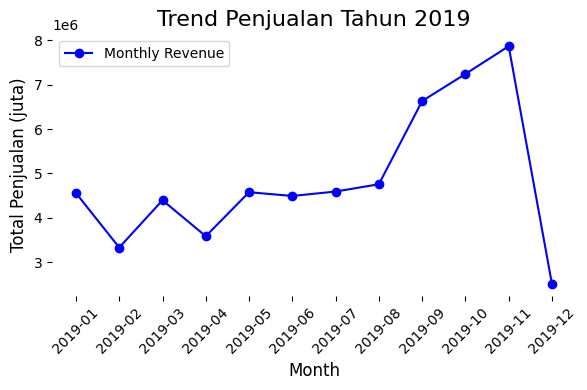

In [40]:
# Menampilkan nama nama kolom tahun 2019
df_sales_19 = df_sales[df_sales['Year'] == 2019]
      
df_sales_19.columns

# Trend Revenue Total per bulan
df_sales_19 = df_sales_19.copy()
df_sales_19['month'] = df_sales_19['Date'].dt.to_period('M') 
monthly_revenue = df_sales_19.groupby('month')['revenue_total'].sum().reset_index()

# Tampilkan hasil rekapitulasi per bulan
print(monthly_revenue)

# Ubah Period menjadi string untuk digunakan sebagai sumbu x
monthly_revenue['month'] = monthly_revenue['month'].dt.strftime('%Y-%m')

# Plotting line chart menggunakan Matplotlib
plt.figure(figsize=(6, 4))
plt.plot(monthly_revenue['month'], monthly_revenue['revenue_total'], marker='o', linestyle='-', color='b', label='Monthly Revenue')
plt.title('Trend Penjualan Tahun 2019', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Penjualan (juta)', fontsize=12)
plt.xticks(rotation=45)

# Menghapus garis grid
plt.grid(False)

# Menghapus frame garis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan legend dan layout yang rapih
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
# Menampilkan Jumlah Customer dan Transaksi serta produk Unik 
print(df_sales.groupby('Year')['CustomerNo'].nunique().reset_index())
print(df_sales.groupby('Year')['TransactionNo'].nunique().reset_index())
print(df_sales.groupby('Year')['ProductNo'].nunique().reset_index())

   Year  CustomerNo
0  2018        1026
1  2019        4572
   Year  TransactionNo
0  2018           1552
1  2019          18238
   Year  ProductNo
0  2018       2700
1  2019       3676


      month  TransactionNo
0   2019-01           1081
1   2019-02           1096
2   2019-03           1442
3   2019-04           1235
4   2019-05           1670
5   2019-06           1528
6   2019-07           1452
7   2019-08           1341
8   2019-09           1818
9   2019-10           2005
10  2019-11           2753
11  2019-12            817


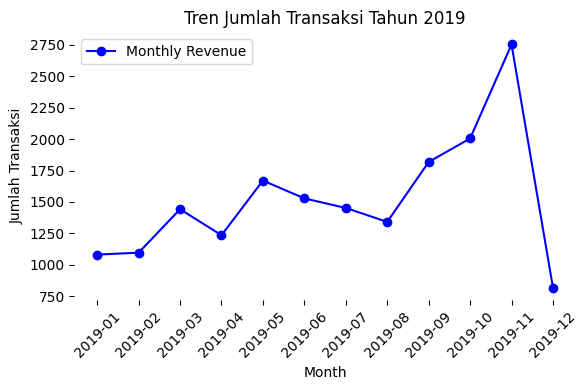

In [42]:
# Trend Transaksi Total per bulan
# Menampilkan nama nama kolom tahun 2019
df_sales_19 = df_sales[df_sales['Year'] == 2019]
df_sales_19 = df_sales_19.copy()
df_sales_19['month'] = df_sales_19['Date'].dt.to_period('M') 
monthly_revenue = df_sales_19.groupby('month')['TransactionNo'].nunique().reset_index()

# Tampilkan hasil rekapitulasi per bulan
print(monthly_revenue)

# Ubah Period menjadi string untuk digunakan sebagai sumbu x
monthly_revenue['month'] = monthly_revenue['month'].dt.strftime('%Y-%m')

# Plotting line chart menggunakan Matplotlib
plt.figure(figsize=(6, 4))
plt.plot(monthly_revenue['month'], monthly_revenue['TransactionNo'], marker='o', linestyle='-', color='b', label='Monthly Revenue')
plt.title('Tren Jumlah Transaksi Tahun 2019')
plt.xlabel('Month')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)

# Menghapus garis grid
plt.grid(False)

# Menghapus frame garis
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Menampilkan legend dan layout yang rapih
plt.legend()
plt.tight_layout()
plt.show()

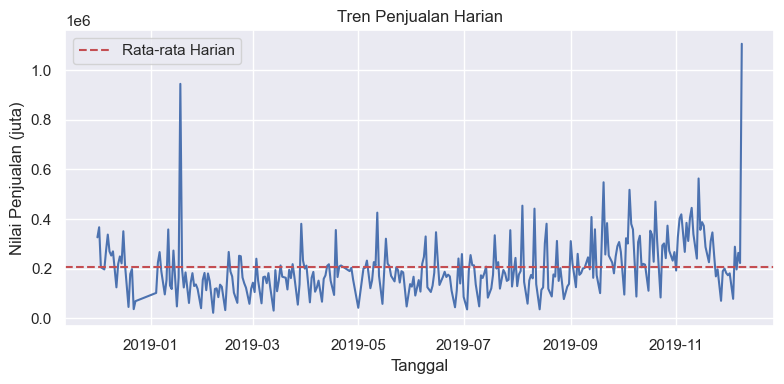

In [43]:
# LINE CHART REVENUE PER HARI
# Kelompokkan data berdasarkan tanggal dan hitung jumlah penjualan per hari
daily_summary_total = df_sales.groupby('Date')['revenue_total'].sum().reset_index().copy()

# Hitung rata-rata harian penjualan
average_daily_revenue = daily_summary_total['revenue_total'].mean()

# Visualisasi dengan line chart menggunakan seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4))  # Perbesar ukuran gambar
ax = sns.lineplot(x='Date', y='revenue_total', data=daily_summary_total)
ax.set_title('Tren Penjualan Harian')
ax.set_xlabel('Tanggal')
ax.set_ylabel('Nilai Penjualan (juta)')
plt.tight_layout()  # Memastikan layout gambar rapi
plt.grid(True)

# Tambahkan garis rata-rata harian
plt.axhline(y=average_daily_revenue, color='r', linestyle='--', label='Rata-rata Harian')
plt.legend()

plt.show()

In [44]:
daily_summary_total.describe()

Date  revenue_total
count                            305   3.050000e+02
mean   2019-06-10 20:03:56.065573888   2.064458e+05
min              2018-12-01 00:00:00   2.289213e+04
25%              2019-03-10 00:00:00   1.361826e+05
50%              2019-06-14 00:00:00   1.853842e+05
75%              2019-09-12 00:00:00   2.526051e+05
max              2019-12-09 00:00:00   1.106070e+06
std                              NaN   1.183527e+05

insight:
1. berdasarkan tren penjualan dan jumlah transaksi terdapat hal yang menarik yaitu pada bulan juli ke agustus, trend nilai penjualannya meningkat namun jika dilihat dari jumlah transaksi yang unik menurun,  Ini bisa berarti bahwa mungkin ada lebih sedikit pelanggan yang melakukan pembelian, tetapi mereka melakukan pembelian dalam jumlah yang lebih besar atau membeli produk yang lebih mahal.
2. Jika dilihat secara bulanan cenderung mengalami peningkatan namun jika dilihat berdasarkan harian tidak jauh berbeda disetiap harinya namun ada hari hari tertentu yang meningkat drastis yaitu tanggal 18 Januari 2019 dan tanggal 9 desember 2019


### Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  

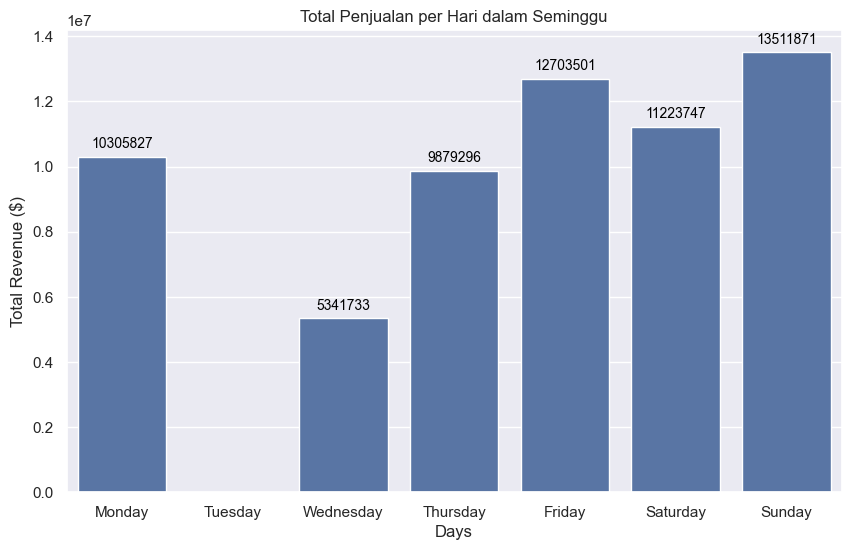

In [45]:
# BARPLOT TOTAL REVENUE PER HARI DALAM SEMINGGU
# Kelompokkan data berdasarkan hari dalam seminggu
daily_summary_total['Day_of_Week'] = daily_summary_total['Date'].dt.day_name().copy()

# Hitung jumlah revenue  per hari dalam seminggu
weekly_summary = daily_summary_total.groupby('Day_of_Week')['revenue_total'].sum().reset_index()

# Urutkan hari dalam seminggu secara kronologis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_summary['Day_of_Week'] = pd.Categorical(weekly_summary['Day_of_Week'], categories=days_order, ordered=True)
weekly_summary = weekly_summary.sort_values('Day_of_Week')

# Visualisasi dengan bar plot menggunakan seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Day_of_Week', y='revenue_total', data=weekly_summary)
ax.set_title('Total Penjualan per Hari dalam Seminggu')
ax.set_xlabel('Days')
ax.set_ylabel('Total Revenue ($)')

# Menambahkan nilai di atas setiap bar dengan posisi yang tepat
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10,
                color='black')

plt.show()


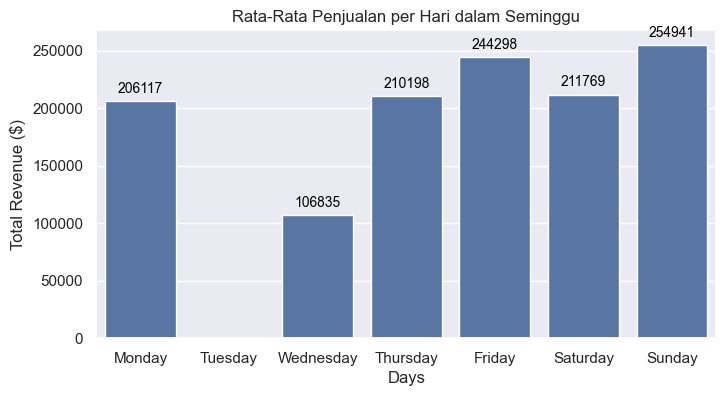

In [46]:
# BARPLOT TOTAL REVENUE PER HARI DALAM SEMINGGU
# Kelompokkan data berdasarkan hari dalam seminggu
daily_summary_total['Day_of_Week'] = daily_summary_total['Date'].dt.day_name().copy()

# Hitung jumlah revenue  per hari dalam seminggu
weekly_summary = daily_summary_total.groupby('Day_of_Week')['revenue_total'].mean().reset_index()

# Urutkan hari dalam seminggu secara kronologis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_summary['Day_of_Week'] = pd.Categorical(weekly_summary['Day_of_Week'], categories=days_order, ordered=True)
weekly_summary = weekly_summary.sort_values('Day_of_Week')

# Visualisasi dengan bar plot menggunakan seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Day_of_Week', y='revenue_total', data=weekly_summary)
ax.set_title('Rata-Rata Penjualan per Hari dalam Seminggu')
ax.set_xlabel('Days')
ax.set_ylabel('Total Revenue ($)')

# Menambahkan nilai di atas setiap bar dengan posisi yang tepat
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10,
                color='black')

plt.show()


In [47]:
daily_summary_total

Date  revenue_total Day_of_Week
0   2018-12-01      326820.08    Saturday
1   2018-12-02      367316.62      Sunday
2   2018-12-03      206313.62      Monday
3   2018-12-05      197565.27   Wednesday
4   2018-12-06      273420.10    Thursday
..         ...            ...         ...
300 2019-12-05      289050.50    Thursday
301 2019-12-06      197440.51      Friday
302 2019-12-07      264266.66    Saturday
303 2019-12-08      223265.49      Sunday
304 2019-12-09     1106069.97      Monday

[305 rows x 3 columns]

In [51]:
import pandas as pd

def check_missing_dates(daily_summary_total):
    # Pastikan kolom 'Date' adalah tipe datetime
    daily_summary_total['Date'] = pd.to_datetime(daily_summary_total['Date'])
    
    # Dapatkan rentang tanggal dari data
    start_date = daily_summary_total['Date'].min()
    end_date = daily_summary_total['Date'].max()
    
    # Buat daftar semua tanggal dalam rentang tersebut
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Buat DataFrame dari daftar tanggal
    all_dates_df = pd.DataFrame(all_dates, columns=['Date'])
    
    # Gabungkan dengan daily_summary_total untuk menemukan tanggal yang hilang
    merged_df = pd.merge(all_dates_df, daily_summary_total, on='Date', how='left', indicator=True)
    
    # Temukan tanggal yang hilang
    missing_dates = merged_df[merged_df['_merge'] == 'left_only']['Date']
    
    # Jika tidak ada tanggal yang hilang, return DataFrame kosong
    if missing_dates.empty:
        return pd.DataFrame(columns=['Date', 'Day_of_Week'])
    
    # Buat DataFrame dari tanggal yang hilang
    missing_dates_df = pd.DataFrame(missing_dates, columns=['Date'])
    
    # Tambahkan kolom hari dalam seminggu
    missing_dates_df['Day_of_Week'] = missing_dates_df['Date'].dt.day_name()
    
    return missing_dates_df


In [52]:
# Contoh penggunaan fungsi
missing_dates_df = check_missing_dates(daily_summary_total)

if missing_dates_df.empty:
    print("Tidak ada tanggal yang hilang.")
else:
    print("Tanggal dan hari yang hilang:")
    print(missing_dates_df)

Tanggal dan hari yang hilang:
          Date Day_of_Week
3   2018-12-04     Tuesday
10  2018-12-11     Tuesday
17  2018-12-18     Tuesday
23  2018-12-24      Monday
24  2018-12-25     Tuesday
..         ...         ...
339 2019-11-05     Tuesday
346 2019-11-12     Tuesday
353 2019-11-19     Tuesday
360 2019-11-26     Tuesday
367 2019-12-03     Tuesday

[69 rows x 2 columns]


In [54]:
# Hitung jumlah tanggal hilang untuk masing-masing jenis hari
hari_counts = missing_dates_df['Day_of_Week'].value_counts()
    
print("\nJumlah tanggal hilang per hari:")
print(hari_counts)


Jumlah tanggal hilang per hari:
Day_of_Week
Tuesday      53
Thursday      6
Monday        4
Wednesday     3
Friday        1
Saturday      1
Sunday        1
Name: count, dtype: int64


insight:
1. tren secara total penjualan dan rata rata penjualan untuk setiap hari dalam seminggu konsisten. namun hari selasa tidak ada transaksi maupun revenue. ketika dilakukan pengecekkan dari 69 rows hampir sebagian besar adalah hari selasa. kembali ke kode awal yang diminta untuk melakukan drop transaction dengan kode mengandung kata C dimana nilai revenue atau quantitasnya negatif, ini bisa berarti dua apakah ada kesalahan interpretasi tarikan data atau C yang dimaksud adalah order yang di cancel atau dibatalkan.

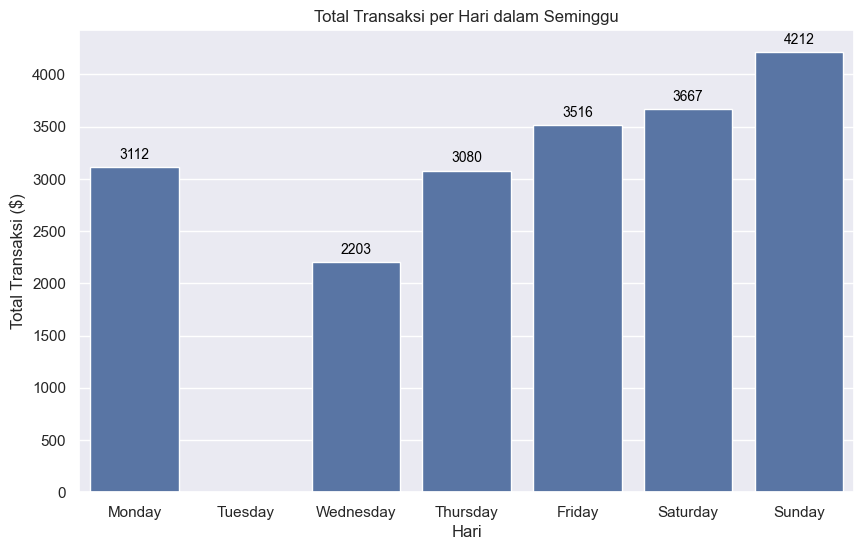

In [57]:
# BARPLOT TOTAL REVENUE PER HARI DALAM SEMINGGU
# Kelompokkan data berdasarkan hari dalam seminggu
daily_summary_total['Day_of_Week'] = daily_summary_total['Date'].dt.day_name()

# Hitung jumlah order per hari dalam seminggu
weekly_summary = daily_summary_total.groupby('Day_of_Week')['order_total'].sum().reset_index()

# Urutkan hari dalam seminggu secara kronologis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_summary['Day_of_Week'] = pd.Categorical(weekly_summary['Day_of_Week'], categories=days_order, ordered=True)
weekly_summary = weekly_summary.sort_values('Day_of_Week')

# Visualisasi dengan bar plot menggunakan seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Day_of_Week', y='order_total', data=weekly_summary)
ax.set_title('Total Transaksi per Hari dalam Seminggu')
ax.set_xlabel('Hari')
ax.set_ylabel('Total Transaksi ($)')

# Menambahkan nilai di atas setiap bar dengan posisi yang tepat
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10,
                color='black')

plt.show()

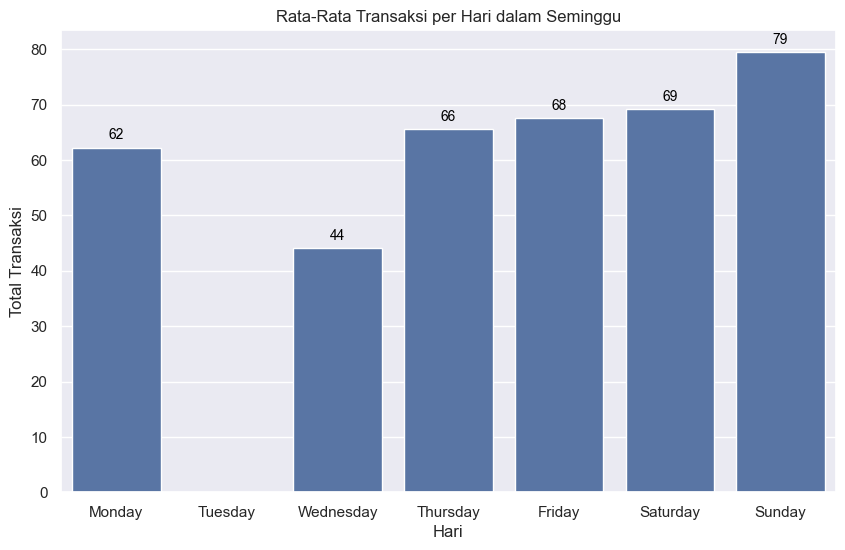

In [58]:
# BARPLOT TOTAL REVENUE PER HARI DALAM SEMINGGU
# Kelompokkan data berdasarkan hari dalam seminggu
daily_summary_total['Day_of_Week'] = daily_summary_total['Date'].dt.day_name()

# Hitung jumlah order per hari dalam seminggu
weekly_summary = daily_summary_total.groupby('Day_of_Week')['order_total'].mean().reset_index()

# Urutkan hari dalam seminggu secara kronologis
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_summary['Day_of_Week'] = pd.Categorical(weekly_summary['Day_of_Week'], categories=days_order, ordered=True)
weekly_summary = weekly_summary.sort_values('Day_of_Week')

# Visualisasi dengan bar plot menggunakan seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Day_of_Week', y='order_total', data=weekly_summary)
ax.set_title('Rata-Rata Transaksi per Hari dalam Seminggu')
ax.set_xlabel('Hari')
ax.set_ylabel('Total Transaksi')

# Menambahkan nilai di atas setiap bar dengan posisi yang tepat
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10,
                color='black')

plt.show()

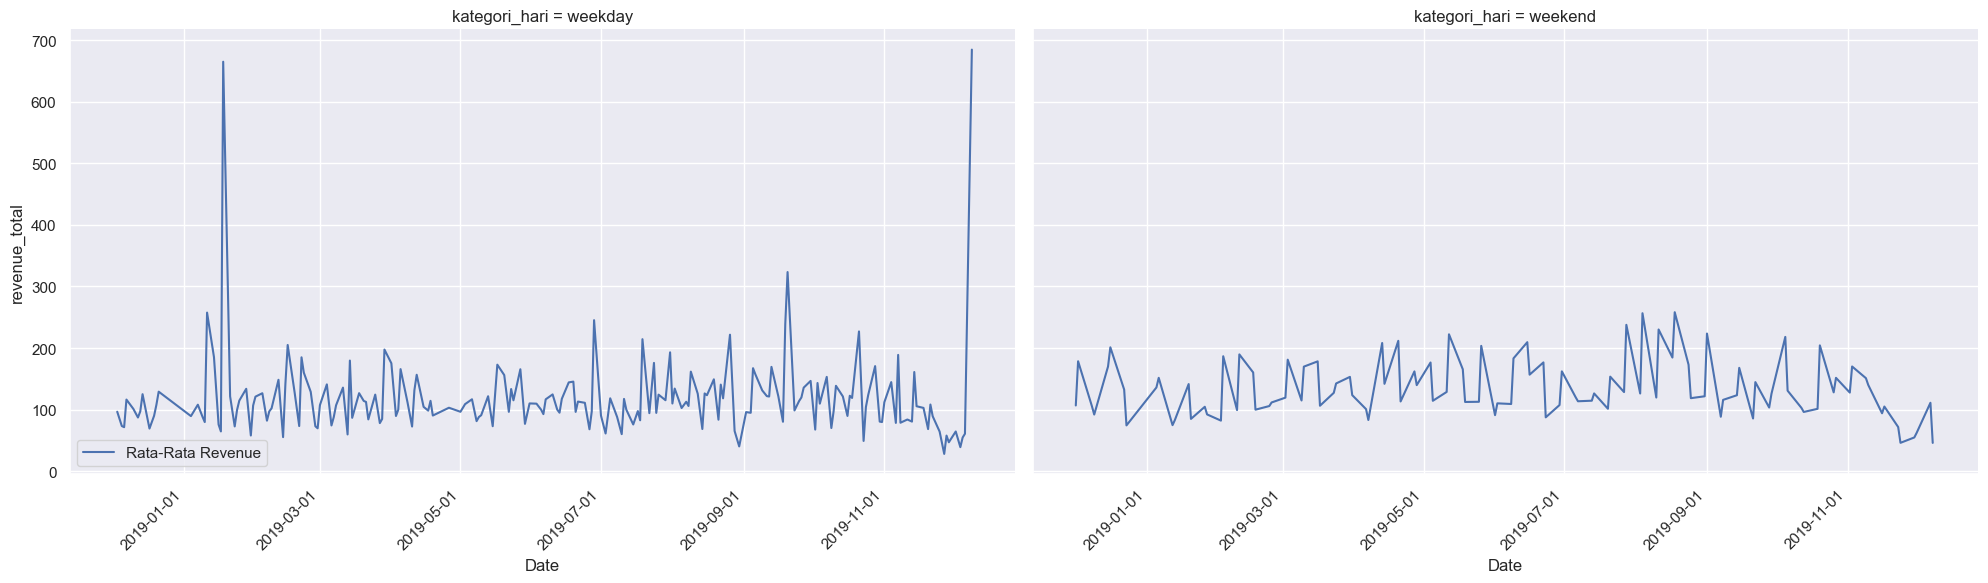

In [59]:
# Menghitung rata-rata revenue_total per kategori hari
daily_summary_total['Date'] = pd.to_datetime(daily_summary_total['Date'])
daily_summary_total['kategori_hari'] = daily_summary_total['Date'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
sum_revenue = daily_summary_total.groupby(['kategori_hari', 'Date'])['revenue_total'].sum().reset_index()

# Membuat plot berdasarkan kategori hari
g = sns.FacetGrid(sum_revenue, col="kategori_hari", height=6, aspect=1.67)
g.map(sns.lineplot, "Date", "revenue_total")

# Menampilkan legenda
g.axes.flat[0].legend(['Rata-Rata Revenue'])
g.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()
plt.show()

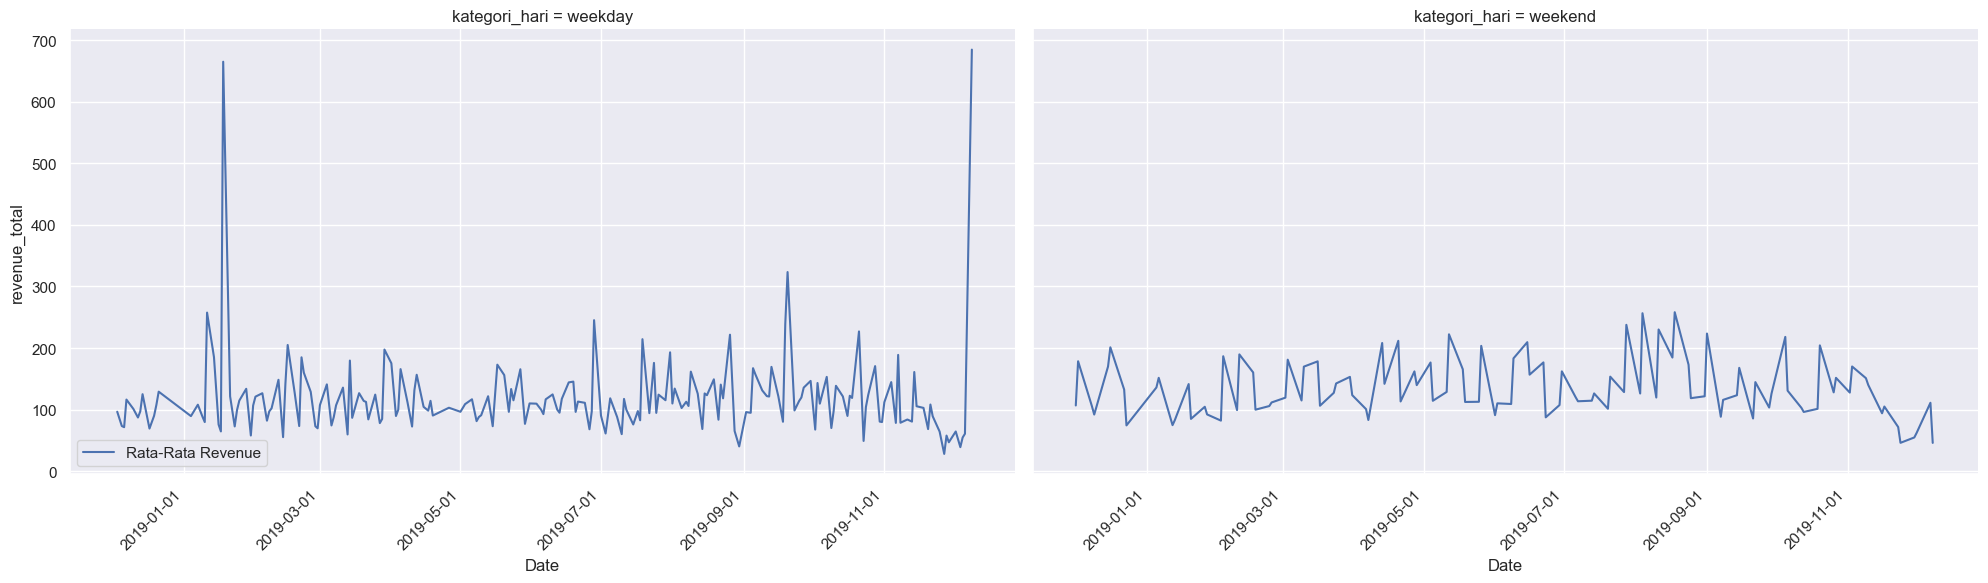

In [60]:
# Menghitung rata-rata revenue_total per kategori hari
daily_summary_total['Date'] = pd.to_datetime(daily_summary_total['Date'])
daily_summary_total['kategori_hari'] = daily_summary_total['Date'].dt.weekday.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
avg_revenue = daily_summary_total.groupby(['kategori_hari', 'Date'])['revenue_total'].mean().reset_index()

# Membuat plot berdasarkan kategori hari
g = sns.FacetGrid(avg_revenue, col="kategori_hari", height=6, aspect=1.67)
g.map(sns.lineplot, "Date", "revenue_total")

# Menampilkan legenda
g.axes.flat[0].legend(['Rata-Rata Revenue'])
g.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()
plt.show()

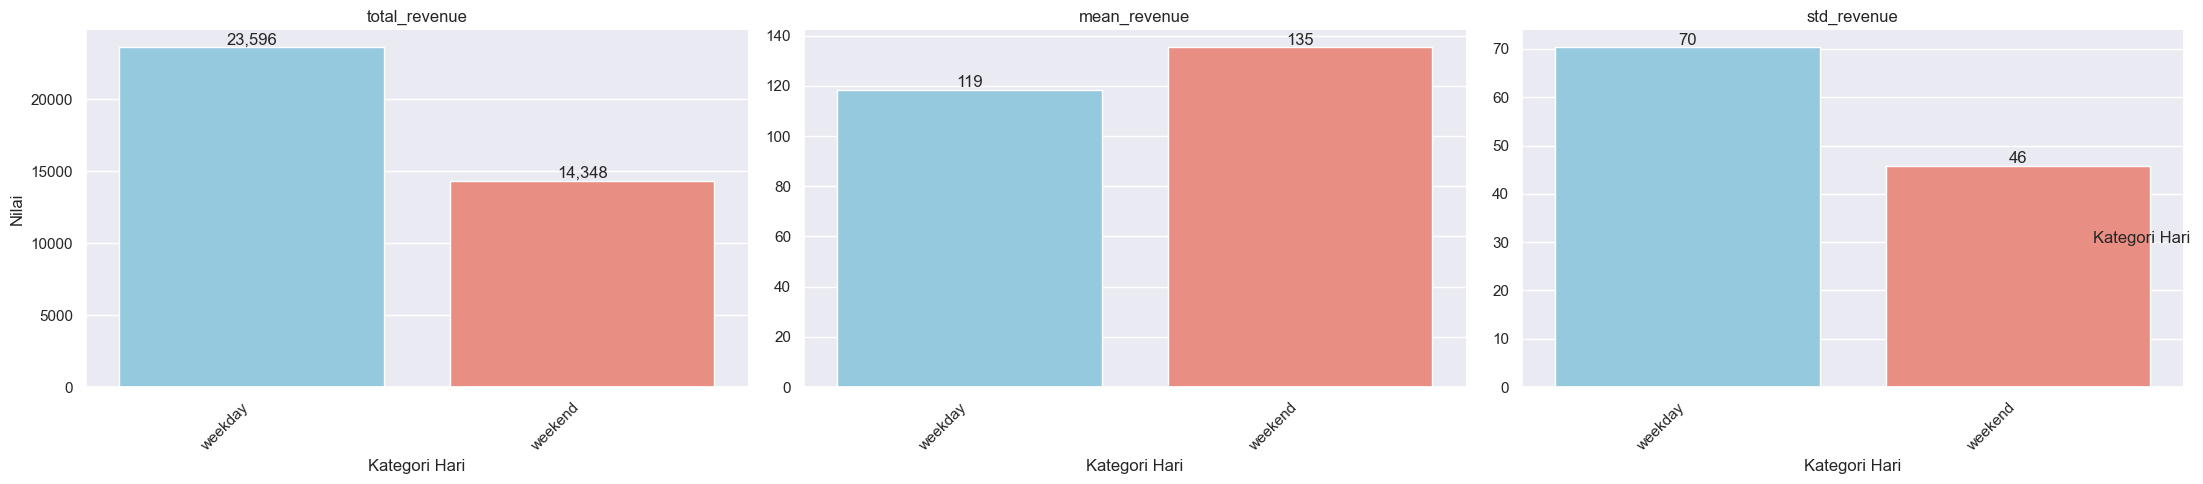

In [61]:
# Menghitung deskripsi statistik
descriptive_stats = daily_summary_total.groupby('kategori_hari')['revenue_total'].agg(
    total_revenue='sum',
    mean_revenue='mean',
    std_revenue='std'
).reset_index()

# Melt DataFrame untuk format yang sesuai dengan FacetGrid
melted_stats = descriptive_stats.melt(id_vars='kategori_hari', 
                                       value_vars=['total_revenue', 'mean_revenue', 'std_revenue'], 
                                       var_name='statistic', 
                                       value_name='value')

# Menetapkan palet warna untuk weekday dan weekend
palette = {
    'weekday': 'skyblue',
    'weekend': 'salmon'
}

# Membuat plot berdasarkan kategori_hari dan statistic
g = sns.FacetGrid(melted_stats, col='statistic', sharey=False, height=5, aspect=1.4)
g.map_dataframe(sns.barplot, x='kategori_hari', y='value', hue='kategori_hari', palette=palette, dodge=False)

# Menambahkan angka di atas barplot
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')

# Menyempurnakan plot
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Kategori Hari", "Nilai")
g.set_xticklabels(rotation=45, ha='right')
g.add_legend(title='Kategori Hari')

plt.tight_layout()
plt.show()

In [72]:
df_sales.describe()

Date          Price       Quantity  \
count                         527765  527765.000000  527765.000000   
mean   2019-07-04 05:58:57.258438400      12.629636      10.594674   
min              2018-12-01 00:00:00       5.130000       1.000000   
25%              2019-03-28 00:00:00      10.990000       1.000000   
50%              2019-07-20 00:00:00      11.940000       3.000000   
75%              2019-10-19 00:00:00      14.090000      11.000000   
max              2019-12-09 00:00:00     660.620000   80995.000000   
std                              NaN       7.933217     156.786646   

          CustomerNo  revenue_total          Month           Year  
count  527764.000000   5.277650e+05  527765.000000  527765.000000  
mean    15231.626733   1.193068e+02       7.562315    2018.921524  
min     12004.000000   5.130000e+00       1.000000    2018.000000  
25%     13813.000000   1.717000e+01       5.000000    2019.000000  
50%     15159.000000   4.383000e+01       8.000000    2019.000000  
75%     16729.000000   1.194000e+02      11.000000    2019.000000  
max     18287.000000   1.002718e+06      12.000000    2019.000000  
std      1716.522182   1.851191e+03       3.509036       0.268920

---

## Pertanyaan 

Pertanyaan 1 :  
Coba totalkan penjualan setiap barang per hari.   
Bagaimana trend penjualan? Apakah ada mengalami kenaikan, penurunan, atau stagnant.

Pertanyaan 2 :  
Lakukan analisis seasonality dengan melihat total order per harinya dari Senin hingga Minggu.  

---

## Jawaban

1. trend penjualan per hari mengalami fluktuasi (naik-turun) namun menunjukkan pola yang cenderung stagnant sedangkan jika dilihat secara bulanan, tren penjualan masih menunjukkan kecenderungan naik hingga November 2019 sedangkan Desember belum bisa disimpulkan karena data yang diberikan hanya sampai tanggal 12 desember saja.
2. Jika dilihat berdasarkan waktu hariannya (Senin-Minggu), Hari Minggu adalah hari yang paling banyak melakukan transaksi dengan revenue terbesar sedangkan hari selasa adalah hari yang paling rendah baik transaksi maupun revenue (karena data tidak tersedia)


---

# Price Elasticity

Price sensitivity atau sensitifitas harga mengacu pada perubahan permintaan pelanggan akibat naik atau turunya harga suatu produk.

Pada bagian ini anda akan diminta untuk melakukan analisis terhadap suatu produk yang penjualannya sangat dipengaruhi oleh harga.

## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

In [62]:
import pandas as pd

# Asumsi df_sales sudah ada

# 1. Mengelompokkan data berdasarkan product_no dan menghitung jumlah harga unik
unique_prices = df_sales.groupby('ProductNo')['Price'].nunique().reset_index()
unique_prices.columns = ['ProductNo', 'UniquePriceCount']

# 2. Menyaring produk dengan setidaknya 10 variasi harga yang berbeda
products_with_10_or_more_prices = unique_prices[unique_prices['UniquePriceCount'] >= 10]

# 3. Menghitung jumlah perubahan harga per produk
def count_price_changes(group):
    sorted_group = group.sort_values(by='Date')
    price_changes = (sorted_group['Price'] != sorted_group['Price'].shift()).sum()
    return price_changes

count_diff_price = df_sales.groupby('ProductNo').apply(count_price_changes).reset_index(name='count_diff_price')

# 4. Menggabungkan data produk dengan informasi perubahan harga
result = pd.merge(products_with_10_or_more_prices, count_diff_price, on='ProductNo', how='inner')

# 5. Menggabungkan dengan data nama produk
result = pd.merge(result, df_sales[['ProductNo', 'ProductName']].drop_duplicates(), on='ProductNo', how='inner')

# 6. Mengurutkan hasil berdasarkan count_diff_price dalam urutan menurun
result = result.sort_values(by='count_diff_price', ascending=False)

# Menampilkan semua produk dengan perubahan harga terbanyak
result[['ProductNo', 'ProductName' ,'count_diff_price']]

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\385005415.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  count_diff_price = df_sales.groupby('ProductNo').apply(count_price_changes).reset_index(name='count_diff_price')


ProductNo                         ProductName  count_diff_price
689    85123A  Cream Hanging Heart T-Light Holder               939
687    85099B             Jumbo Bag Red Retrospot               882
294     22423            Regency Cakestand 3 Tier               729
236     22197                      Popcorn Holder               657
596     47566                       Party Bunting               584
..        ...                                 ...               ...
130     21850       Blue Diamante Pen In Gift Box                21
693    85169C         Eau De Nil Love Bird Candle                21
502     23128         Feltcraft Boy Jean-Paul Kit                20
382     22688         Doormat Peace On Earth Blue                20
698    85179C              Pink Bitty Light Chain                17

[700 rows x 3 columns]

In [63]:
# Summary Deskripsi
result['count_diff_price'].describe()

count    700.000000
mean     153.092857
std      118.401024
min       17.000000
25%       70.000000
50%      118.500000
75%      194.000000
max      939.000000
Name: count_diff_price, dtype: float64

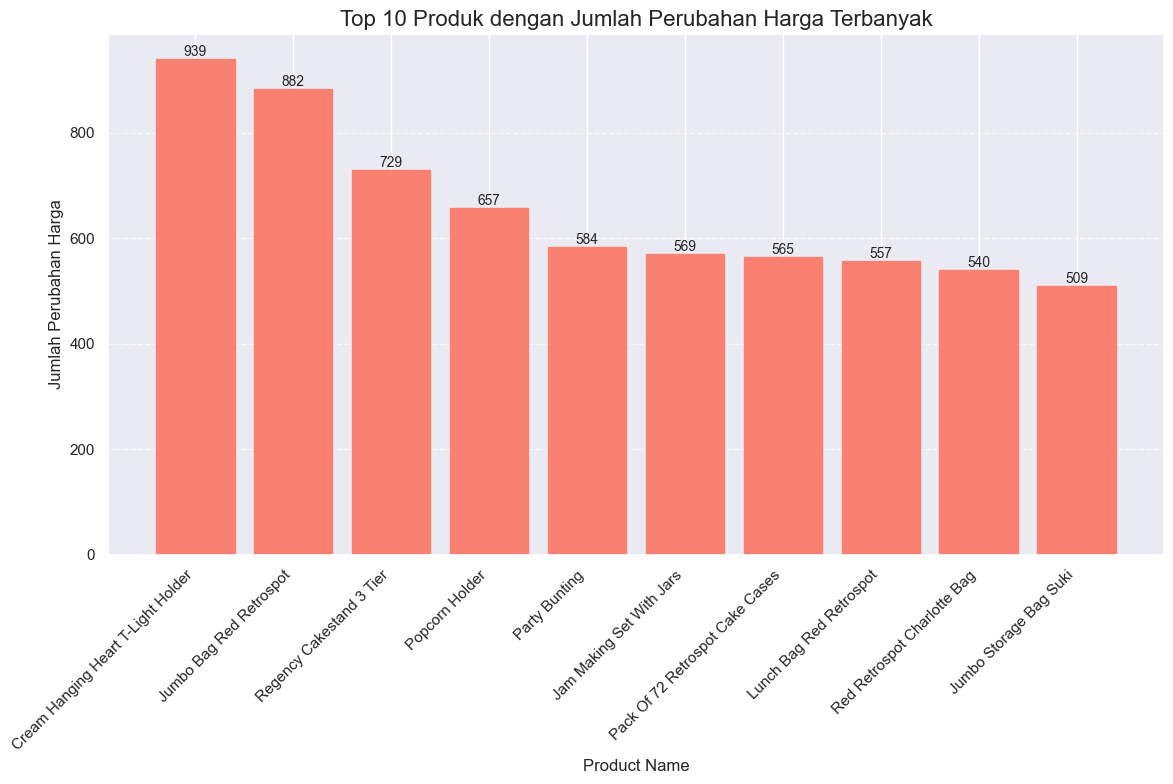

In [64]:
# Mengurutkan hasil berdasarkan count_diff_price dalam urutan menurun
result = result.sort_values(by='count_diff_price', ascending=False)

# Menampilkan 10 produk dengan perubahan harga terbanyak
top_10_products = result.head(10)
# Plot Bar Plot
plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_products['ProductName'], top_10_products['count_diff_price'], color='salmon', edgecolor='salmon')

# Menambahkan angka di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

# Menambahkan judul dan label sumbu
plt.title('Top 10 Produk dengan Jumlah Perubahan Harga Terbanyak', fontsize=16)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Jumlah Perubahan Harga', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Menampilkan grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.tight_layout()
plt.show()

insight:
- Produk dengan kode "85123A" (Cream Hanging Heart T-Light Holder) memiliki perubahan harga paling banyak, mencapai 939 kali. Ini menunjukkan bahwa produk ini memiliki fleksibilitas harga yang tinggi, dan mungkin terlibat dalam berbagai penawaran dan promosi.
- Produk "85099B" (Jumbo Bag Red Retrospot) dan "882" (Regency Cakestand 3 Tier) juga memiliki perubahan harga yang signifikan, dengan masing-masing mencapai lebih dari 100 kali. Ini mungkin menunjukkan tingginya permintaan atau variasi harga yang dilakukan dalam kategori produk ini.- 
- Rata-rata produk dalam dataset ini mengalami perubahan harga sekitar 153 kali. Ini menunjukkan bahwa sebagian besar produk memiliki sejumlah variasi harga yang berkisar dari 70-194.


### Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

In [67]:
result

ProductNo  UniquePriceCount  count_diff_price  \
689    85123A                18               939   
687    85099B                12               882   
294     22423                18               729   
236     22197                14               657   
596     47566                19               584   
..        ...               ...               ...   
130     21850                11                21   
693    85169C                10                21   
502     23128                11                20   
382     22688                11                20   
698    85179C                10                17   

                            ProductName  
689  Cream Hanging Heart T-Light Holder  
687             Jumbo Bag Red Retrospot  
294            Regency Cakestand 3 Tier  
236                      Popcorn Holder  
596                       Party Bunting  
..                                  ...  
130       Blue Diamante Pen In Gift Box  
693         Eau De Nil Love Bird Candle  
502         Feltcraft Boy Jean-Paul Kit  
382         Doormat Peace On Earth Blue  
698              Pink Bitty Light Chain  

[700 rows x 4 columns]

In [71]:
# 1. Filter data sales berdasarkan produk yang terdaftar di result
filtered_sales = df_sales[df_sales['ProductNo'].isin(result['ProductNo'])]

# Menghitung korelasi Pearson antara harga dan volume
pearson_corr = filtered_sales ['Price'].corr(filtered_sales ['Quantity'], method='pearson')
print("\nKorelasi Pearson antara Harga dan Volume:", pearson_corr)

# Menghitung korelasi Spearman antara harga dan volume
spearman_corr = filtered_sales ['Price'].corr(filtered_sales ['Quantity'], method='spearman')
print("Korelasi Spearman antara Harga dan Volume:", spearman_corr)

# Menghitung korelasi Kendall antara harga dan volume
kendall_corr = filtered_sales ['Price'].corr(filtered_sales ['Quantity'], method='kendall')
print("Korelasi Kendall antara Harga dan Volume:", kendall_corr)

# Mengembalikan pengaturan peringatan ke keadaan semula
warnings.resetwarnings()


Korelasi Pearson antara Harga dan Volume: -0.021180064780788495
Korelasi Spearman antara Harga dan Volume: -0.28060184091786783
Korelasi Kendall antara Harga dan Volume: -0.2078829978189134


insight:
    produk yang mengalami perubahan variasi lebih dari 10 memiliki korelasi yang negatif namun sangat kecil. tanda negatif menunukkan kenaikan harga akan menurunkan quantitas. namun perlu dibuktikan apakah berpengaruh signifikan

Bagaimana jika keseluruhan produk??

In [72]:
import warnings

# Mengelompokkan data berdasarkan product_no
grouped = df_sales.groupby('ProductNo')

# Inisialisasi list untuk menyimpan hasil korelasi
correlations = []

# Mengatur peringatan untuk diabaikan
warnings.filterwarnings("ignore")

# Menghitung korelasi antara harga dan kuantitas untuk setiap produk
for name, group in grouped:
    if len(group) >= 2:  # Hanya hitung korelasi jika ada dua atau lebih entri
        correlation = group['Price'].corr(group['Quantity'], method='spearman')
        correlations.append((name, correlation))

# Mengembalikan pengaturan peringatan ke keadaan semula
warnings.resetwarnings()

# Menambahkan kolom korelasi ke dataset
correlation_dict = dict(correlations)
df_sales['korelasi'] = df_sales['ProductNo'].map(correlation_dict)

# Simpan dataset dengan kolom korelasi ke file CSV
df_sales.to_csv('price_elasticity.csv', index=False)

In [75]:
# Menghitung korelasi Pearson antara harga dan volume
pearson_corr = df_sales['Price'].corr(df_sales['Quantity'], method='pearson')
print("\nKorelasi Pearson antara Harga dan Volume:", pearson_corr)

# Menghitung korelasi Spearman antara harga dan volume
spearman_corr = df_sales['Price'].corr(df_sales['Quantity'], method='spearman')
print("Korelasi Spearman antara Harga dan Volume:", spearman_corr)

# Menghitung korelasi Kendall antara harga dan volume
kendall_corr = df_sales['Price'].corr(df_sales['Quantity'], method='kendall')
print("Korelasi Kendall antara Harga dan Volume:", kendall_corr)

# Mengembalikan pengaturan peringatan ke keadaan semula
warnings.resetwarnings()


Korelasi Pearson antara Harga dan Volume: -0.011657657057041524
Korelasi Spearman antara Harga dan Volume: -0.30872838520634893
Korelasi Kendall antara Harga dan Volume: -0.22991144850828235


In [76]:
# Menampilkan ringkasan statistik untuk kolom numerik
numeric_cols = ['Price', 'Quantity', 'revenue_total', 'korelasi']
numeric_summary = df_sales[numeric_cols].describe()

print(numeric_summary)

               Price       Quantity  revenue_total       korelasi
count  527765.000000  527765.000000   5.277650e+05  525830.000000
mean       12.629636      10.594674   1.193068e+02      -0.339384
std         7.933217     156.786646   1.851191e+03       0.185093
min         5.130000       1.000000   5.130000e+00      -1.000000
25%        10.990000       1.000000   1.717000e+01      -0.462933
50%        11.940000       3.000000   4.383000e+01      -0.354275
75%        14.090000      11.000000   1.194000e+02      -0.238351
max       660.620000   80995.000000   1.002718e+06       1.000000


Insight:
secara keseluruhan
- Korelasi Pearson antara harga dan volume adalah -0.0117. Korelasi ini sangat mendekati nol, yang menunjukkan bahwa tidak ada hubungan linier yang kuat antara harga dan volume. Nilai negatif menunjukkan adanya kecenderungan bahwa saat harga naik, volume cenderung turun, meskipun korelasi ini sangat lemah.

- Korelasi Spearman antara harga dan volume adalah -0.3087. Korelasi Spearman mengukur hubungan monotone antara dua variabel, dan nilai ini juga negatif. Ini menunjukkan bahwa ada hubungan yang lebih kuat dibandingkan dengan korelasi Pearson, tetapi hubungan ini masih lemah.

- Korelasi Kendall antara harga dan volume adalah -0.2299. Korelasi Kendall juga mengukur hubungan monotone antara dua variabel, dan nilai ini negatif seperti dalam korelasi Spearman. Korelasi Kendall menunjukkan hubungan yang lebih kuat daripada korelasi Pearson, tetapi masih tidak terlalu kuat.

Note:
Metode Spearman lebih umum digunakan dalam analisis statistik dan penelitian ilmiah. 

- Outlier: Data ini memiliki potensi untuk outlier, terutama pada kolom price, quantity, dan total_revenue. Hal ini terlihat dari perbedaan yang signifikan antara nilai maksimum dan kuartil atas (75%). Nilai maksimum yang jauh lebih besar dari kuartil atas menunjukkan keberadaan nilai ekstrem yang mungkin merupakan outlier. Terutama pada kolom quantity, nilai maksimum yang sangat tinggi (80995) adalah indikasi kuat bahwa ada outlier dalam data ini.

- Distribusi yang Tidak Normal: Distribusi data pada kolom price, quantity, dan total_revenue mungkin tidak normal. Ini terlihat dari perbedaan antara mean dan median (50%). Jika mean lebih besar dari median, itu bisa menjadi indikasi bahwa distribusi data sedikit condong ke kanan (positif skew), dan jika mean lebih kecil dari median, itu bisa menjadi indikasi distribusi data yang sedikit condong ke kiri (negatif skew). Dalam hal ini, distribusi data tampaknya condong ke kanan pada kolom price dan total_revenue, sedangkan condong ke kiri pada kolom quantity.

In [77]:
# Menemukan produk dengan korelasi paling negatif
most_negative_correlation = min(correlations, key=lambda x: x[1])

# Mendapatkan nama produk
product_name = df_sales[df_sales['ProductNo'] == most_negative_correlation[0]]['ProductName'].values[0]

print(f"Produk dengan korelasi paling negatif adalah:")
print(f"Product No: {most_negative_correlation[0]}")
print(f"Product Name: {product_name}")
print(f"Korelasi: {most_negative_correlation[1]}")

Produk dengan korelasi paling negatif adalah:
Product No: 16049
Product Name: Teatime Gel Pens Asst
Korelasi: -1.0


semakin banyak variasi semakin dapat diandalkan antara korelasi dan dampak perubahan harga terhadap quantitas. kita coba lakukan analisis untuk produk yang memiliki variasi harga lebih dari 10 dan memiliki korelasi negatif tinggi yaitu lebih dari -0.7

In [79]:
# Membuat DataFrame dari daftar korelasi
df_correlations = pd.DataFrame(correlations, columns=['ProductNo', 'Korelasi'])

# Filter untuk korelasi positif > 0.7 dan negatif < -0.7
positive_filter = df_correlations['Korelasi'] > 0.7
negative_filter = df_correlations['Korelasi'] < -0.7

df_positive = df_correlations[positive_filter]
df_negative = df_correlations[negative_filter]

# Merge DataFrame berdasarkan ProductNo
df_positive_merged = pd.merge(df_positive, products_with_10_or_more_prices, on='ProductNo', how='inner')
df_negative_merged = pd.merge(df_negative, products_with_10_or_more_prices, on='ProductNo', how='inner')

# Menampilkan hasil
print("Produk dengan Korelasi Positif lebih dari 0.7 dan hasil merge:")
print(df_positive_merged)

print("\nProduk dengan Korelasi Negatif kurang dari -0.7 dan memiliki variasi harga lebih dari 10:")
print(df_negative_merged)

Produk dengan Korelasi Positif lebih dari 0.7 dan hasil merge:
Empty DataFrame
Columns: [ProductNo, Korelasi, UniquePriceCount]
Index: []

Produk dengan Korelasi Negatif kurang dari -0.7 dan memiliki variasi harga lebih dari 10:
  ProductNo  Korelasi  UniquePriceCount
0     22027 -0.722509                10
1     22029 -0.728132                12
2     22712 -0.762424                10


In [80]:
# Daftar ProductNo yang ingin dianalisis
product_nos_to_check = ['22027', '22029', '22712']

# Filter data berdasarkan ProductNo yang diberikan
filtered_df = df_classify[df_classify['ProductNo'].isin(product_nos_to_check)]

# Menghitung frekuensi product_type untuk setiap ProductNo
product_type_counts = filtered_df.groupby(['ProductNo', 'ProductName'])['product_type'].value_counts().unstack(fill_value=0)

# Menampilkan hasil
print("Frekuensi setiap kategori produk untuk produk dengan korelasi > -7")
print(product_type_counts)

Frekuensi setiap kategori produk untuk produk dengan korelasi > -7
product_type                       Normal  Popular  Super Popular
ProductNo ProductName                                            
22027     Tea Party Birthday Card       3        2              7
22029     Spaceboy Birthday Card        0        0             12
22712     Card Dolly Girl               3        1              7


ketiga produk tersebut adalah produk dengan perubahan variasi lebih dari 10 dan memiliki korelasi negatif terbesar.

In [81]:
# Menggunakan loop dan if statement untuk mengurutkan hasil korelasi dari yang paling negatif hingga yang paling positif
negative_correlations = [x for x in correlations if not pd.isna(x[1]) and x[1] < 0]
negative_correlations_sorted = sorted(negative_correlations, key=lambda x: x[1])

# Menampilkan 10 produk dengan korelasi negatif terbesar yang sudah diurutkan
top_10_negative_correlations = negative_correlations_sorted[:10]

print("10 Produk dengan Korelasi Paling Negatif:")
for i, (product_no, correlation) in enumerate(top_10_negative_correlations):
    product_info = df_classify[df_classify['ProductNo'] == product_no]
    if not product_info.empty:
        product_name = product_info['ProductName'].values[0]
        product_type = product_info['product_type'].values[0]
        print(f"{i + 1}. Product No: {product_no} | Product Name: {product_name} | Product Type: {product_type} | Korelasi: {correlation:.4f}")

# Menggunakan loop dan if statement untuk mengurutkan hasil korelasi dari yang paling positif hingga yang paling negatif
positive_correlations = [x for x in correlations if not pd.isna(x[1]) and x[1] > 0]
positive_correlations_sorted = sorted(positive_correlations, key=lambda x: x[1], reverse=True)

# Menampilkan 10 produk dengan korelasi positif terbesar yang sudah diurutkan
top_10_positive_correlations = positive_correlations_sorted[:10]

print("\n10 Produk dengan Korelasi Paling Positif:")
for i, (product_no, correlation) in enumerate(top_10_positive_correlations):
    product_info = df_classify[df_classify['ProductNo'] == product_no]
    if not product_info.empty:
        product_name = product_info['ProductName'].values[0]
        product_type = product_info['product_type'].values[0]
        print(f"{i + 1}. Product No: {product_no} | Product Name: {product_name} | Product Type: {product_type} | Korelasi: {correlation:.4f}")

10 Produk dengan Korelasi Paling Negatif:
1. Product No: 16049 | Product Name: Teatime Gel Pens Asst | Product Type: Normal | Korelasi: -1.0000
2. Product No: 22827 | Product Name: Rustic Seventeen Drawer Sideboard | Product Type: Normal | Korelasi: -1.0000
3. Product No: 22828 | Product Name: Regency Mirror With Shutters | Product Type: Normal | Korelasi: -1.0000
4. Product No: 23441 | Product Name: Hand Painted Hanging Easter Egg | Product Type: Low | Korelasi: -1.0000
5. Product No: 35443 | Product Name: Rasta In Bath W Spliff Ashtray | Product Type: Low | Korelasi: -1.0000
7. Product No: 35809B | Product Name: Enamel Blue Rim Tea Container | Product Type: Normal | Korelasi: -1.0000
8. Product No: 84415B | Product Name: Blue Flock Cushion Cover | Product Type: Low | Korelasi: -1.0000
9. Product No: 84691 | Product Name: Pack 20 Dolly Pegs | Product Type: Normal | Korelasi: -1.0000
10. Product No: 85067 | Product Name: Cream Sweetheart Wall Cabinet | Product Type: Low | Korelasi: -1.

In [82]:
import numpy as np

# Mengatur peringatan untuk diabaikan
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Menghitung korelasi antara harga dan kuantitas untuk setiap produk
for name, group in grouped:
    if len(group) >= 2:  # Hanya hitung korelasi jika ada dua atau lebih entri
        try:
            correlation = group['Price'].corr(group['Quantity'], method='spearman')
            if not np.isnan(correlation):
                correlations.append((name, correlation))
        except RuntimeWarning:
            pass

# Mengembalikan pengaturan peringatan ke keadaan semula
warnings.resetwarnings()

# Mengurutkan hasil korelasi dari yang paling negatif hingga yang paling positif
correlations_sorted = sorted(correlations, key=lambda x: x[1])

# Menghitung jumlah total produk
total_produk = df_sales['ProductNo'].nunique()

print(f"Total Produk dalam Dataset: {total_produk}") 

# Menghitung jumlah produk dengan korelasi -1 dan +1
count_negative_1 = len([x for x in correlations_sorted if abs(x[1] - (-1)) < 1e-9])
count_positive_1 = len([x for x in correlations_sorted if abs(x[1] - 1) < 1e-9])

print(f"Jumlah produk dengan korelasi -1: {count_negative_1}")
print(f"Jumlah produk dengan korelasi +1: {count_positive_1}")

Total Produk dalam Dataset: 3753
Jumlah produk dengan korelasi -1: 64
Jumlah produk dengan korelasi +1: 20


terdapat total 64 produk dengan korelasi -1 dan 20 produk dengan korelasi +1. namun ketika dilakukan merge dengan produk yang memiliki variasi harga lebih dari 10 hanya ada 3 produk yang. artinya sisanya adalah produk dengan dengan variasi harga yang kurang dari 10. sehingga produk dengan korelasi negatif 1 namun memililki variasi perubahan harga kurang dari 10 belum dapat representatif untuk diinterpretasikan

## Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

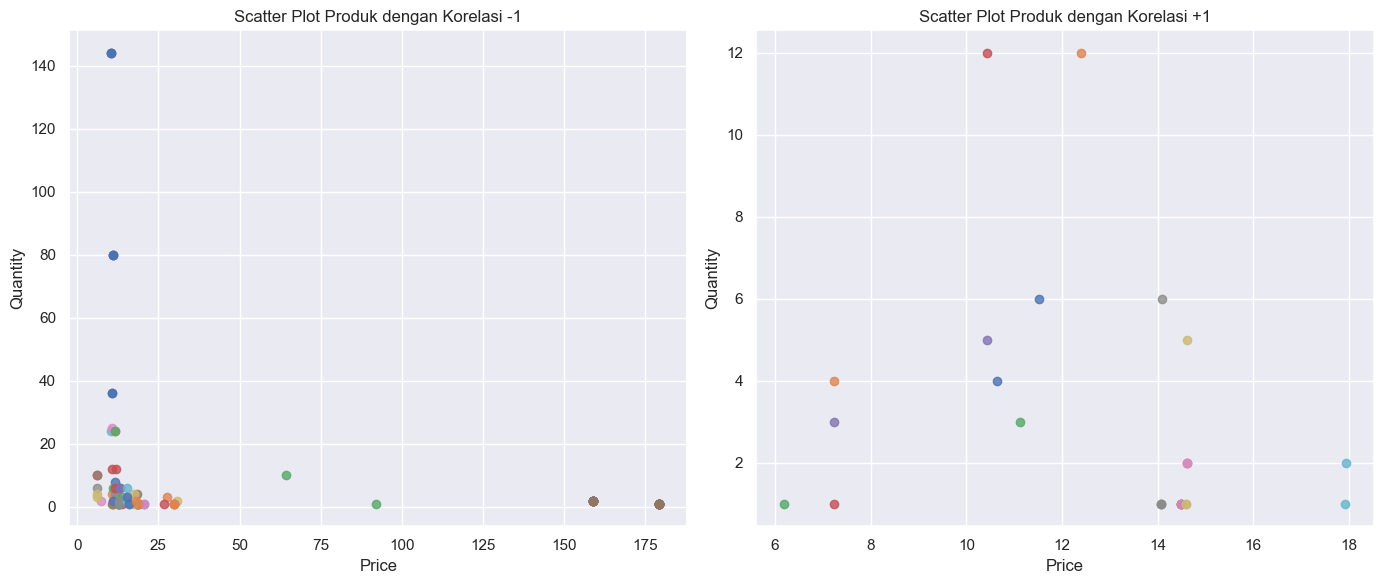

In [83]:
# Menampilkan scatter plot produk dengan korelasi -1 dan +1
# Filter produk dengan korelasi -1 dan +1
products_negative_1 = [x[0] for x in correlations_sorted if abs(x[1] - (-1)) < 1e-9]
products_positive_1 = [x[0] for x in correlations_sorted if abs(x[1] - 1) < 1e-9]

# Filter data berdasarkan produk dengan korelasi -1 dan +1
filtered_data_negative_1 = df_sales[df_sales['ProductNo'].isin(products_negative_1)]
filtered_data_positive_1 = df_sales[df_sales['ProductNo'].isin(products_positive_1)]

# Scatter plot untuk produk dengan korelasi -1
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for product, group in filtered_data_negative_1.groupby('ProductNo'):
    plt.scatter(group['Price'], group['Quantity'], alpha=0.8, label=product)
plt.title('Scatter Plot Produk dengan Korelasi -1')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(True)

# Scatter plot untuk produk dengan korelasi +1
plt.subplot(1, 2, 2)
for product, group in filtered_data_positive_1.groupby('ProductNo'):
    plt.scatter(group['Price'], group['Quantity'], alpha=0.8, label=product)
plt.title('Scatter Plot Produk dengan Korelasi +1')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.grid(True)

# Menambahkan legend jika diperlukan
plt.tight_layout()
plt.show()

### Additional

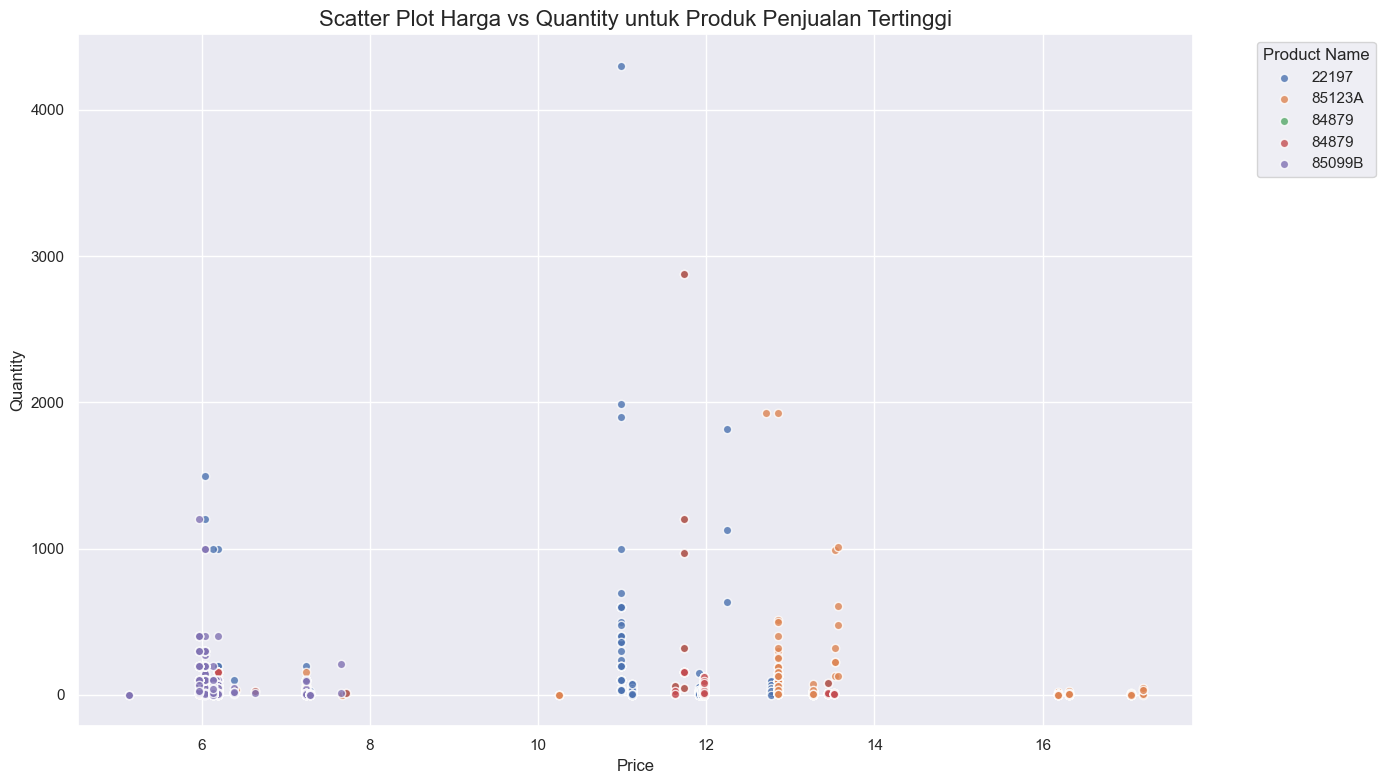

In [84]:
# Daftar nama produk yang ingin ditampilkan
product_no = [
    '22197',
    '85123A',
    '84879',
    '84879',
    '85099B'
]

# Filter data untuk produk yang disebutkan
filtered_data = df_sales[df_sales['ProductNo'].isin(product_no)]

# Plot Scatter untuk produk yang disebutkan
plt.figure(figsize=(14, 8))

# Plot untuk setiap produk
for product_no in product_no:
    product_data = filtered_data[filtered_data['ProductNo'] == product_no]
    plt.scatter(product_data['Price'], product_data['Quantity'], alpha=0.8, label=product_no, edgecolors='w')

# Menambahkan judul dan label sumbu
plt.title('Scatter Plot Harga vs Quantity untuk Produk Penjualan Tertinggi', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Menampilkan grid
plt.grid(True)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [85]:
# Daftar ProductNo yang ingin dianalisis
product_nos = [
    '22197',
    '85123A',
    '84879',
    '85099B'
]

# Filter data untuk ProductNo yang disebutkan
filtered_data = df_sales[df_sales['ProductNo'].isin(product_nos)]

# Menghitung korelasi antara harga dan kuantitas untuk setiap produk
correlations = {}
for product_no in product_nos:
    group = filtered_data[filtered_data['ProductNo'] == product_no]
    if len(group) >= 2:  # Hanya hitung korelasi jika ada dua atau lebih entri
        try:
            correlation = group['Price'].corr(group['Quantity'], method='spearman')
            correlations[product_no] = correlation
        except RuntimeWarning:
            correlations[product_no] = np.nan

# Menampilkan nilai korelasi
for product_no, correlation in correlations.items():
    print(f'ProductNo: {product_no} - Korelasi Harga vs Quantity: {correlation:.4f}')

ProductNo: 22197 - Korelasi Harga vs Quantity: -0.4468
ProductNo: 85123A - Korelasi Harga vs Quantity: -0.4811
ProductNo: 84879 - Korelasi Harga vs Quantity: -0.1932
ProductNo: 85099B - Korelasi Harga vs Quantity: -0.5528


### IMPROVEMENT PRICE ELASTICITY

In [86]:
# Menggunakan pd.cut untuk mengelompokkan elastisitas harga
bins = [-1.1, -0.6, 0.6, 1.1]  # Batasan untuk elastisitas
labels = ['Elastisitas Rendah', 'Elastisitas Sedang', 'Elastisitas Tinggi']

df_sales['elastisitas_group'] = pd.cut(df_sales['korelasi'], bins=bins, labels=labels)

# Menghitung jumlah produk dalam masing-masing kelompok elastisitas
elastisitas_counts = df_sales['elastisitas_group'].value_counts()

# Menghitung persentase produk dalam masing-masing kelompok
total_products = df_sales.shape[0]
elastisitas_percentages = (elastisitas_counts / total_products) * 100

# Menampilkan hasil
print("Jumlah Produk Berdasarkan Kelompok Elastisitas Harga:")
print(elastisitas_counts)

print("\nPersentase Produk dalam Setiap Kelompok Elastisitas Harga:")
print(elastisitas_percentages)

Jumlah Produk Berdasarkan Kelompok Elastisitas Harga:
elastisitas_group
Elastisitas Sedang    496765
Elastisitas Rendah     28767
Elastisitas Tinggi       298
Name: count, dtype: int64

Persentase Produk dalam Setiap Kelompok Elastisitas Harga:
elastisitas_group
Elastisitas Sedang    94.126174
Elastisitas Rendah     5.450721
Elastisitas Tinggi     0.056465
Name: count, dtype: float64


C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3644253518.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 5, f"{v:.2f} K ({elastisitas_percentages[i]:.2f}%)", ha='center')


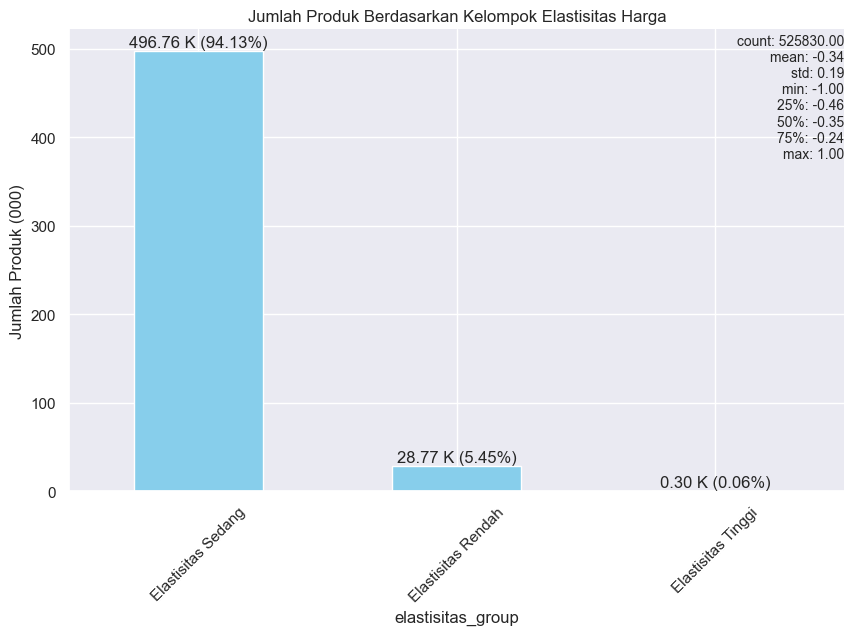

In [87]:
# Menghitung jumlah produk dalam masing-masing kelompok elastisitas
elastisitas_counts = df_sales['elastisitas_group'].value_counts()

# Menghitung persentase produk dalam masing-masing kelompok
total_products = df_sales.shape[0]
elastisitas_percentages = (elastisitas_counts / total_products) * 100

# Konversi nilai ke dalam Ribu ()
elastisitas_counts_kilo = elastisitas_counts / 1000

# Membuat grafik bar
plt.figure(figsize=(10, 6))
ax = elastisitas_counts_kilo.plot(kind='bar', color='skyblue')

# Menambahkan nilai dalam K di atas setiap bar
for i, v in enumerate(elastisitas_counts_kilo):
    ax.text(i, v + 5, f"{v:.2f} K ({elastisitas_percentages[i]:.2f}%)", ha='center')

# Mengatur judul grafik
plt.title('Jumlah Produk Berdasarkan Kelompok Elastisitas Harga')

# Mengatur judul untuk sumbu y
plt.ylabel('Jumlah Produk (000)')

# Menghilangkan garis frame atas dan samping kanan
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Menampilkan deskripsi statistik di kanan atas
desc = df_sales['korelasi'].describe()
desc_text = '\n'.join([f"{key}: {desc[key]:.2f}" for key in desc.keys()])
plt.text(2.5, max(elastisitas_counts_kilo) + 20, desc_text, fontsize=10, ha='right', va='top')

# Mengatur rotasi label sumbu x menjadi 0 derajat
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Menampilkan grafik
plt.show()

insight:
- Elastisitas Sedang (94,13 %):
- Insight: Mayoritas produk dalam dataset memiliki elastisitas negatif sedang-rendah. Ini menunjukkan hubungan negatif antara harga dan kuantitas, namun tidak terlalu kuat. Perubahan harga berpengaruh pada pembelian, tetapi dalam tingkat yang moderat.
- Rekomendasi: Evaluasi harga secara berkala dan pengujian harga mungkin diperlukan untuk memahami bagaimana kenaikan atau penurunan harga memengaruhi penjualan. Perubahan harga harus cermat dan strategis.
---
- Elastisitas Rendah (5,45%):
- Insight: Sebagian produk memiliki elastisitas harga rendah. Mereka kurang responsif terhadap perubahan harga, yang mengindikasikan bahwa perubahan harga mungkin tidak memengaruhi permintaan secara signifikan.
- Rekomendasi: Perlu mempertimbangkan faktor-faktor selain harga yang memengaruhi penjualan, seperti kualitas produk, merek, atau preferensi pelanggan. Strategi harga lebih fleksibel, namun perlu berfokus pada aspek-aspek selain harga.
---
- Elastisitas Tinggi (0,06%):
- Insight: Hanya sedikit produk  yang memiliki elastisitas harga tinggi. Ini artinya produk tersebut sangat responsif terhadap perubahan harga, dan - perubahan harga dapat memiliki dampak signifikan pada permintaan.
- Rekomendasi: Perubahan harga harus dilakukan dengan hati-hati dan dengan pemahaman yang mendalam tentang bagaimana konsumen akan meresponsnya. Strategi harga mungkin melibatkan optimisasi harga untuk maksimalkan keuntungan atau peningkatan jumlah produk yang dibeli.

## Bagaimana kalau kondisi price elasticity ini dikupas berdasarkan kondisi musiman

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\448326903.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_elastisitas = df_2019.groupby(['bulan', 'elastisitas_group'])['ProductNo'].count().unstack()


Jumlah Produk Berdasarkan Kelompok Elastisitas Harga per Bulan (Tahun 2019):
elastisitas_group  Elastisitas Rendah  Elastisitas Sedang  Elastisitas Tinggi
bulan                                                                        
January 2019                     2816               31097                  23
February 2019                    2078               24729                  12
March 2019                       2715               32696                  19
April 2019                       2359               26408                  21
May 2019                         2584               33311                   6
June 2019                        2335               33340                  16
July 2019                        2272               35973                  15
August 2019                      1807               32418                  13
September 2019                   2170               46717                  27
October 2019                     1932               56976        

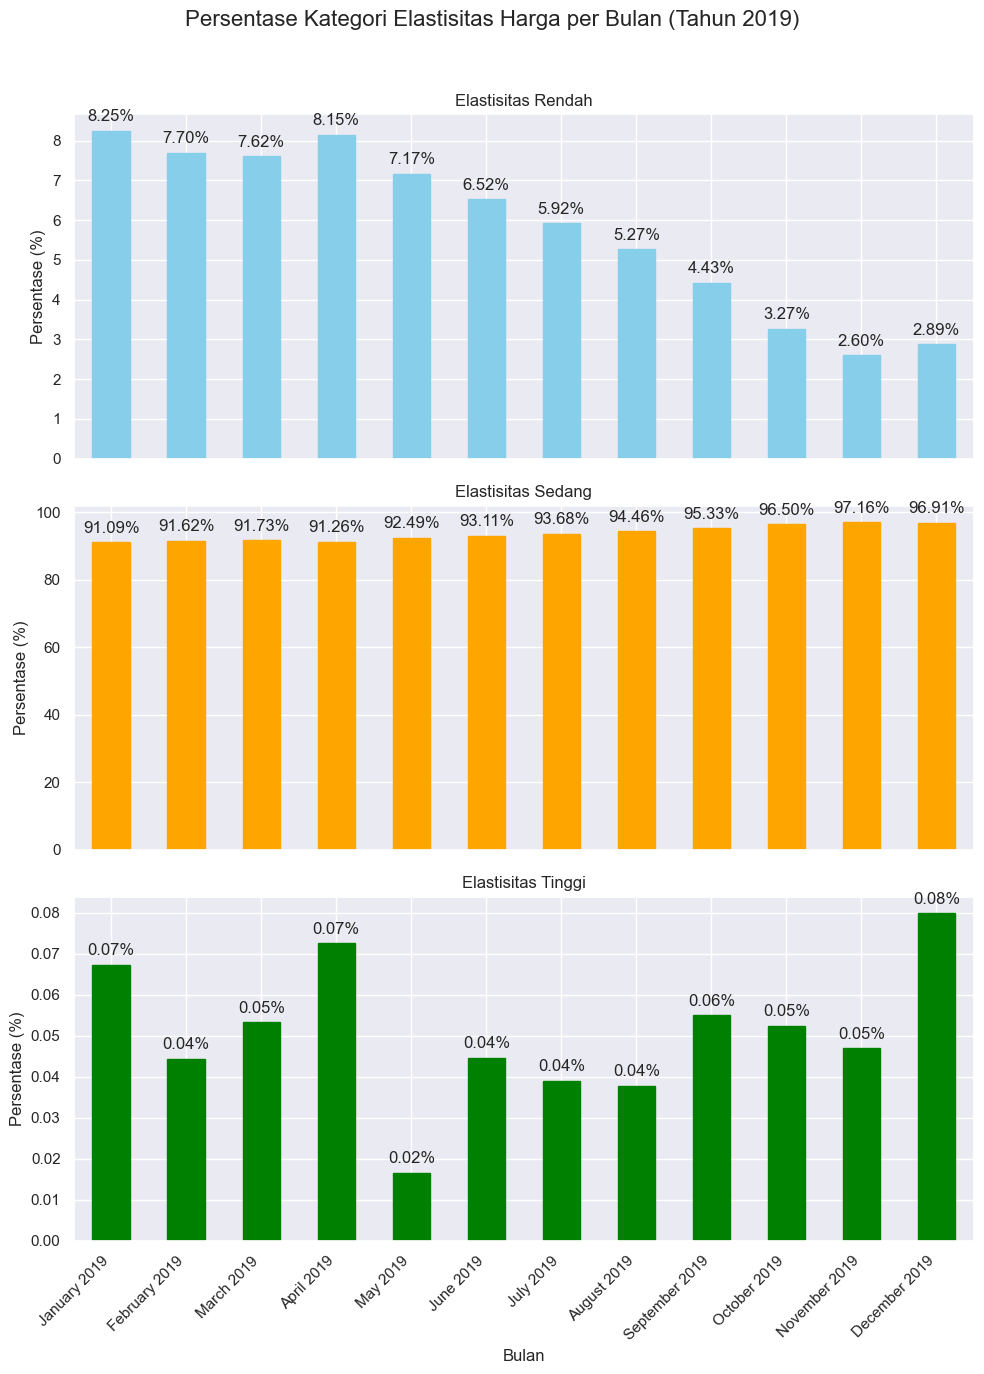

In [88]:
# Filter data hanya untuk tahun 2019
df_2019 = df_sales[(df_sales['Date'] >= '2019-01-01') & (df_sales['Date'] <= '2019-12-31')].copy()

# Menggunakan pd.cut untuk mengelompokkan elastisitas harga
bins = [-1.1, -0.6, 0.6, 1.1]  # Batasan untuk elastisitas
labels = ['Elastisitas Rendah', 'Elastisitas Sedang', 'Elastisitas Tinggi']

df_2019['elastisitas_group'] = pd.cut(df_2019['korelasi'], bins=bins, labels=labels)

# Ekstrak bulan dan tahun dari kolom 'Date'
df_2019['bulan'] = df_2019['Date'].dt.strftime('%B %Y')

# Mengelompokkan berdasarkan bulan, kelompok elastisitas
monthly_elastisitas = df_2019.groupby(['bulan', 'elastisitas_group'])['ProductNo'].count().unstack()

# Menghitung persentase berdasarkan jumlah total produk per bulan
total_products_per_month = df_2019.groupby('bulan')['ProductNo'].count()
monthly_elastisitas_percentages = (monthly_elastisitas.T / total_products_per_month * 100).T

# Mengurutkan berdasarkan bulan
monthly_elastisitas = monthly_elastisitas.reindex(pd.to_datetime(monthly_elastisitas.index, format='%B %Y').sort_values().strftime('%B %Y'))
monthly_elastisitas_percentages = monthly_elastisitas_percentages.reindex(monthly_elastisitas.index)

# Menampilkan hasil
print("Jumlah Produk Berdasarkan Kelompok Elastisitas Harga per Bulan (Tahun 2019):")
print(monthly_elastisitas)

print("\nPersentase Produk dalam Setiap Kelompok Elastisitas Harga per Bulan (Tahun 2019):")
print(monthly_elastisitas_percentages)

# Plotting bar chart terpisah untuk setiap kategori elastisitas
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 14), sharex=True)

# Kategori elastisitas rendah
monthly_elastisitas_percentages['Elastisitas Rendah'].plot(kind='bar', ax=axs[0], color='skyblue', edgecolor='skyblue')
axs[0].set_title('Elastisitas Rendah')
axs[0].set_ylabel('Persentase (%)')
axs[0].set_xticklabels(monthly_elastisitas.index, rotation=45, ha='right')

# Kategori elastisitas sedang
monthly_elastisitas_percentages['Elastisitas Sedang'].plot(kind='bar', ax=axs[1], color='orange', edgecolor='orange')
axs[1].set_title('Elastisitas Sedang')
axs[1].set_ylabel('Persentase (%)')
axs[1].set_xticklabels(monthly_elastisitas.index, rotation=45, ha='right')

# Kategori elastisitas tinggi
monthly_elastisitas_percentages['Elastisitas Tinggi'].plot(kind='bar', ax=axs[2], color='green', edgecolor='green')
axs[2].set_title('Elastisitas Tinggi')
axs[2].set_ylabel('Persentase (%)')
axs[2].set_xticklabels(monthly_elastisitas.index, rotation=45, ha='right')

# Menambahkan angka persentase di atas setiap bar
for ax in axs:
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Menambahkan judul utama dan label sumbu x
plt.suptitle('Persentase Kategori Elastisitas Harga per Bulan (Tahun 2019)', fontsize=16)
plt.xlabel('Bulan')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ruang untuk suptitle

# Menampilkan plot
plt.show()

insight

Peningkatan Elastisitas Harga pada Bulan November dan Desember 2019

Penawaran Diskon Strategis: Penawaran diskon yang ditargetkan dapat merangsang pembelian pada periode di mana elastisitas harga meningkat. Pelanggan akan lebih responsif terhadap harga, sehingga diskon dapat mempengaruhi keputusan mereka.
Variasi Musiman dalam Preferensi Konsumen

Penelitian Pasar yang Lebih Mendalam: Analisis preferensi konsumen selama periode musiman akan membantu dalam memahami bagaimana elastisitas harga berkaitan dengan preferensi pelanggan. Ini akan memungkinkan perusahaan untuk menyesuaikan harga dan penawaran produk sesuai dengan preferensi musiman pelanggan.
Penyesuaian Strategi Pemasaran: Dengan memahami perubahan preferensi konsumen yang berkaitan dengan elastisitas harga, perusahaan dapat merancang strategi pemasaran yang lebih efektif. Ini dapat mencakup peningkatan penekanan pada produk yang memiliki elastisitas tinggi selama periode tertentu.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Misalkan df_sales adalah DataFrame yang sudah ada
# df_sales = pd.read_csv('path_to_your_data.csv')

# Tentukan kuantil untuk pembagian harga menjadi 3 kategori
quantiles = df_sales['Price'].quantile([0, 0.30, 0.85, 1]).values
price_labels = ['Cheap', 'Moderate', 'High']

# Menambahkan kolom kategori harga berdasarkan kuantil
df_sales['Price_Category'] = pd.cut(df_sales['Price'], bins=quantiles, labels=price_labels, include_lowest=True)

# Analisis deskriptif berdasarkan kategori harga
price_category_summary = df_sales.groupby('Price_Category')['Price'].describe()
print("\nAnalisis Deskriptif Berdasarkan Kategori Harga:")
price_category_summary


Analisis Deskriptif Berdasarkan Kategori Harga:


C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3239172263.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_category_summary = df_sales.groupby('Price_Category')['Price'].describe()


count       mean        std    min    25%    50%    75%  \
Price_Category                                                               
Cheap           176769.0   8.893001   2.268582   5.13   6.19  10.65  10.99   
Moderate        272030.0  12.836104   1.156601  11.13  11.92  12.56  13.62   
High             78966.0  20.282998  17.734907  15.33  16.35  18.71  20.46   

                   max  
Price_Category          
Cheap            11.12  
Moderate         15.32  
High            660.62

In [90]:
# Uji ANOVA
anova_result = stats.f_oneway(
    df_sales[df_sales['Price_Category'] == 'Cheap']['revenue_total'],
    df_sales[df_sales['Price_Category'] == 'Moderate']['revenue_total'],
    df_sales[df_sales['Price_Category'] == 'High']['revenue_total']
)

print("\nHasil Uji ANOVA:")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretasi hasil ANOVA
if anova_result.pvalue < 0.05:
    print("Terdapat perbedaan signifikan dalam rata-rata penjualan antara kategori harga.")
else:
    print("Tidak terdapat perbedaan signifikan dalam rata-rata penjualan antara kategori harga.")



Hasil Uji ANOVA:
F-statistic: 58.8322
P-value: 0.0000
Terdapat perbedaan signifikan dalam rata-rata penjualan antara kategori harga.


C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\521366203.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_revenue_by_category = df_sales.groupby('Price_Category')['revenue_total'].sum()


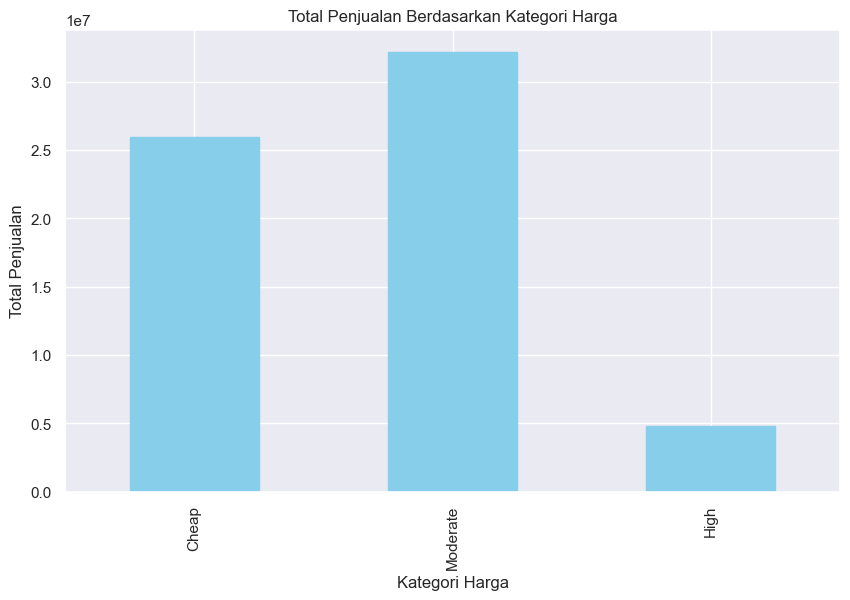

In [92]:
# Visualisasi: Rata-Rata Penjualan Berdasarkan Kategori Harga
plt.figure(figsize=(10, 6))
mean_revenue_by_category = df_sales.groupby('Price_Category')['revenue_total'].sum()
mean_revenue_by_category.plot(kind='bar', color='skyblue', edgecolor='skyblue')
plt.title('Total Penjualan Berdasarkan Kategori Harga')
plt.xlabel('Kategori Harga')
plt.ylabel('Total Penjualan')
plt.grid(True)
plt.show()

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3779471312.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_revenue_by_category = df_sales.groupby('Price_Category')['revenue_total'].mean()


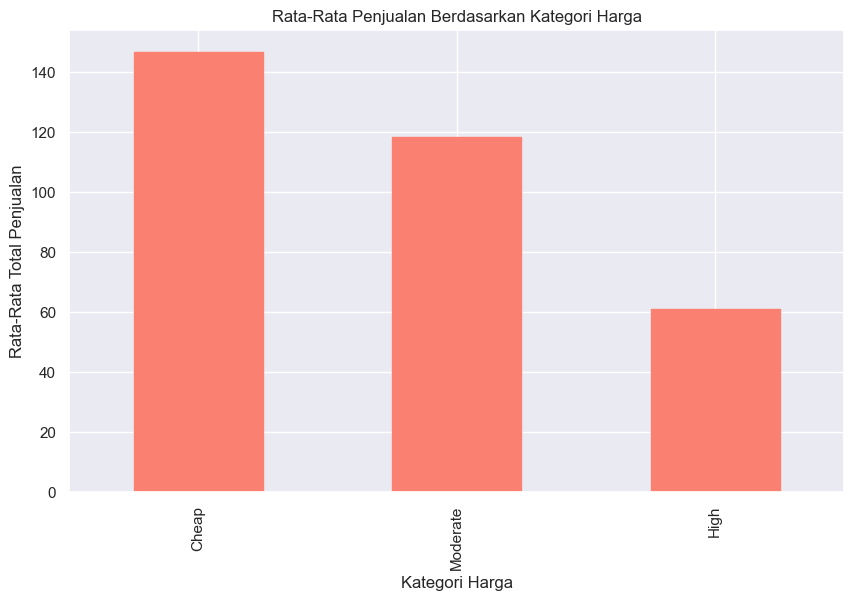

In [93]:
# Visualisasi: Rata-Rata Penjualan Berdasarkan Kategori Harga
plt.figure(figsize=(10, 6))
mean_revenue_by_category = df_sales.groupby('Price_Category')['revenue_total'].mean()
mean_revenue_by_category.plot(kind='bar', color='salmon', edgecolor='salmon')
plt.title('Rata-Rata Penjualan Berdasarkan Kategori Harga')
plt.xlabel('Kategori Harga')
plt.ylabel('Rata-Rata Total Penjualan')
plt.grid(True)
plt.show()

---
## Pertanyaan

Pertanyaan 1 :   
Produk apa yang paling sering mengalami perubahan harga?   
Hitunglah banyaknya harga unik di setiap produk dan ambil daftar produk yang pernah terjual dengan setidaknya 10 variasi harga yang berbeda.

Price Elasticity akan semakin baik dianalisis ketika lebih banyak variasi harga yang muncul.

Pertanyaan 2 :   
Dari semua produk yang terambil dari step 1, hitung lah korelasi antara harga dengan quantity untuk setiap barang.  
Barang manakah yang memiliki korelasi paling negatif?  

Pertanyaan 3 : 
Buatlah scatter plot antara harga dan quantity untuk barang dari soal sebelumnya.  
Apabila produk tersebut mengalami kenaikan harga, kira-kira apa yang akan terjadi dengan penjualan ?

---

Jawaban

1. Terdaapat sebanyak 700 produk yang mengalami perubahan harga sebanyak 10 kali lebih.

2. Barang yang memiliki korelasi paling negatif yaitu

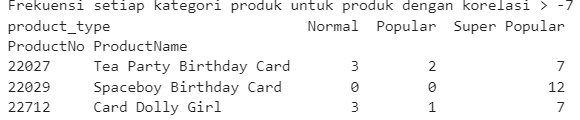
---

# Basket Size Analysis

Ketika seorang pelanggan e-commerce menekan "add to cart", maka barang tersebut akan disimpan dalam sebuah "basket".  
Ketika melakukan checkout, maka semua barang dalam basket tersebut akan diproses dan dikirimkan.  
Ukuran dari basket dapat diukur melalui nilai GMV (Gross merchandise volume) yang merupakan total harga barang yang dibeli.  
Contoh : 
Pada tanggal 1 januari 2012
Tuan A membeli 1 shampoo seharga 15ribu dan 2 sabun seharga 20ribu masing-masing. Maka basket size tuan A adalah 55ribu rupiah.
Nyonya B hanya membeli 1 cemilan seharga 20 ribu, maka basket size dari nyonya B adalah 20 ribu rupiah.
Berarti total GMV ecommerce pada 1 januari 2012 adalah 75ribu rupiah, dengan rata-rata basket size sebesar 37.5 ribu rupiah per basket.

## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

In [94]:
# Mengelompokkan data berdasarkan tanggal dan menghitung rata-rata basket size per harinya
daily_average_basket_size = df_sales.groupby('Date')['revenue_total'].sum() / df_sales.groupby('Date')['TransactionNo'].count()

# Menampilkan hasil rata-rata basket size per harinya
daily_average_basket_size

Date
2018-12-01    106.769056
2018-12-02    178.569091
2018-12-03     96.588773
2018-12-05     73.335290
2018-12-06     71.519775
                 ...    
2019-12-05     54.785917
2019-12-06     60.807056
2019-12-07    111.129798
2019-12-08     45.996187
2019-12-09    684.449239
Length: 305, dtype: float64

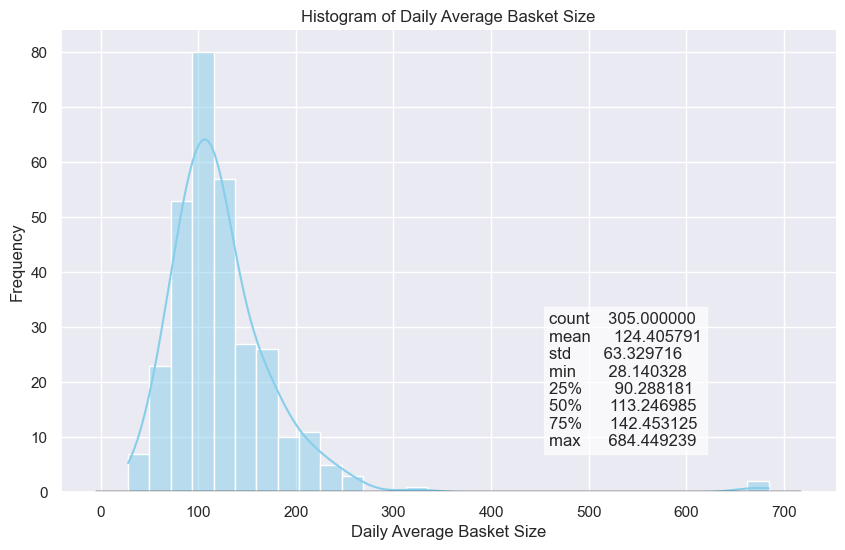

In [95]:
from scipy.stats import norm
# Membuat histogram
plt.figure(figsize=(10, 6))
sns.histplot(daily_average_basket_size, kde=True, color='skyblue', bins=30)

# Menambahkan statistik yang dijelaskan di kanan bawah grafik
plt.title("Histogram of Daily Average Basket Size")
plt.xlabel("Daily Average Basket Size")
plt.ylabel("Frequency")

# Menghitung statistik yang dijelaskan
desc_stats = daily_average_basket_size.describe().to_string()

# Menambahkan kurva distribusi (PDF)
mu, std = norm.fit(daily_average_basket_size)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Menampilkan describe statistik di kanan bawah grafik
plt.text(0.63, 0.1, desc_stats, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.7))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Menampilkan grafik
plt.show()

Additional exploratory:
Menampilkan average basket size harian 10 tertinggi dan 10 terendah

Exploratory tambahan, mari kita lihat didalam 10 besar average basket size harian, berapa banyak porsi dari setiap segmentasi harga produknya lebih banyak kategori yang mana:

In [96]:
# Mengambil 10 teratas dan 10 terendah tanggal dari rata-rata basket size
top_10_dates = daily_average_basket_size.nlargest(10).index
bottom_10_dates = daily_average_basket_size.nsmallest(10).index

# Menghitung jumlah produk dalam setiap kategori harga ('Cheap', 'Moderate', 'High')
# per tanggal untuk 10 teratas
top_category_counts = df_sales[df_sales['Date'].isin(top_10_dates)].groupby(['Date', 'Price_Category']).size().unstack(fill_value=0)

# Menghitung jumlah produk dalam setiap kategori harga ('Very Cheap', 'Cheap', 'Moderate', 'Expensive')
# per tanggal untuk 10 terendah
bottom_category_counts = df_sales[df_sales['Date'].isin(bottom_10_dates)].groupby(['Date', 'Price_Category']).size().unstack(fill_value=0)

# Menampilkan rata-rata basket size harian untuk 10 teratas
print("Top 10 Daily Average Basket Size:")
print(daily_average_basket_size.nlargest(10))

# Menampilkan rata-rata basket size harian untuk 10 terendah
print("\nBottom 10 Daily Average Basket Size:")
print(daily_average_basket_size.nsmallest(10))

# Menampilkan hasil untuk 10 teratas (diurutkan berdasarkan rata-rata basket size harian)
print("\nTop 10 Category Counts per Date (Sorted by Daily Average Basket Size):")
top_category_counts['Average Basket Size'] = daily_average_basket_size
top_category_counts = top_category_counts.sort_values(by='Average Basket Size', ascending=False)
top_category_counts = top_category_counts.drop('Average Basket Size', axis=1)
print(top_category_counts)

# Menampilkan hasil untuk 10 terendah (diurutkan berdasarkan rata-rata basket size harian)
print("\nBottom 10 Category Counts per Date (Sorted by Daily Average Basket Size):")
bottom_category_counts['Average Basket Size'] = daily_average_basket_size
bottom_category_counts = bottom_category_counts.sort_values(by='Average Basket Size', ascending=False)
bottom_category_counts = bottom_category_counts.drop('Average Basket Size', axis=1)
print(bottom_category_counts)

Top 10 Daily Average Basket Size:
Date
2019-12-09    684.449239
2019-01-18    664.810570
2019-09-20    323.348579
2019-08-18    258.142957
2019-01-11    257.528800
2019-08-04    256.501722
2019-06-28    245.230122
2019-09-19    239.036706
2019-07-28    237.671611
2019-08-11    230.117648
dtype: float64

Bottom 10 Daily Average Basket Size:
Date
2019-11-27    28.140328
2019-12-04    39.087727
2019-08-30    40.263269
2019-12-08    45.996187
2019-11-24    46.103469
2019-11-29    47.008767
2019-10-23    49.171436
2019-12-05    54.785917
2019-11-30    54.830153
2019-02-13    55.349163
dtype: float64

Top 10 Category Counts per Date (Sorted by Daily Average Basket Size):
Price_Category  Cheap  Moderate  High
Date                                 
2019-12-09       1512        94    10
2019-01-18        339       771   311
2019-09-20        380      1035   281
2019-08-18        514       798   166
2019-01-11        314       854   224
2019-08-04        595       892   284
2019-06-28        324 

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\2932225402.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_category_counts = df_sales[df_sales['Date'].isin(top_10_dates)].groupby(['Date', 'Price_Category']).size().unstack(fill_value=0)
C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\2932225402.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bottom_category_counts = df_sales[df_sales['Date'].isin(bottom_10_dates)].groupby(['Date', 'Price_Category']).size().unstack(fill_value=0)


In [97]:
from scipy.stats import f_oneway

# Memeriksa perbedaan ukuran basket dari negara yang berbeda menggunakan ANOVA
countries = df_sales['Country'].unique()
anova_results = {}
for country in countries:
    basket_size_by_country = df_sales[df_sales['Country'] == country]['revenue_total']
    anova_results[country] = basket_size_by_country

f_statistic, p_value = f_oneway(*anova_results.values())

# Menampilkan hasil uji ANOVA
print("Hasil Uji ANOVA:")
print("Nilai F-statistic:", f_statistic)
print("Nilai p-value:", p_value)

if p_value < 0.05:
    print("Terdapat perbedaan yang signifikan dalam ukuran basket dari negara yang berbeda.")
else:
    print("Tidak terdapat perbedaan yang signifikan dalam ukuran basket dari negara yang berbeda.")

Hasil Uji ANOVA:
Nilai F-statistic: 20.22018859762882
Nilai p-value: 3.298379938633904e-133
Terdapat perbedaan yang signifikan dalam ukuran basket dari negara yang berbeda.


In [98]:
# Mengelompokkan ukuran basket berdasarkan negara dan menghitung jumlah (count) dan jumlah total (sum)
grouped = df_sales.groupby('Country')['revenue_total'].agg([('jumlah_transaksi', 'count'), ('total_penjualan', 'sum')]).reset_index()

# Menghitung rata-rata (mean) ukuran basket
grouped['mean'] = grouped['total_penjualan'] / grouped['jumlah_transaksi']

# Mengurutkan hasil berdasarkan rata-rata ukuran basket secara menurun
sorted_grouped = grouped.sort_values(by='mean', ascending=False)

# Menampilkan hasil
print("Hasil Pengelompokan Ukuran Basket:")
print(sorted_grouped[['Country', 'jumlah_transaksi', 'total_penjualan', 'mean']])

Hasil Pengelompokan Ukuran Basket:
                 Country  jumlah_transaksi  total_penjualan        mean
32                Sweden               408        401879.89  984.999730
24           Netherlands              2326       2151553.59  925.001543
20                 Japan               337        293155.44  869.897448
0              Australia              1631        995607.91  610.427903
8         Czech Republic                24          7674.44  319.768333
30             Singapore               215         63480.95  295.260233
9                Denmark               408        101083.99  247.754877
22             Lithuania                34          8188.08  240.825882
10                  EIRE              7807       1713410.95  219.471109
25                Norway               927        188612.52  203.465502
5                 Canada               150         30490.91  203.272733
2                Bahrain                17          3226.86  189.815294
16             Hong Kong     

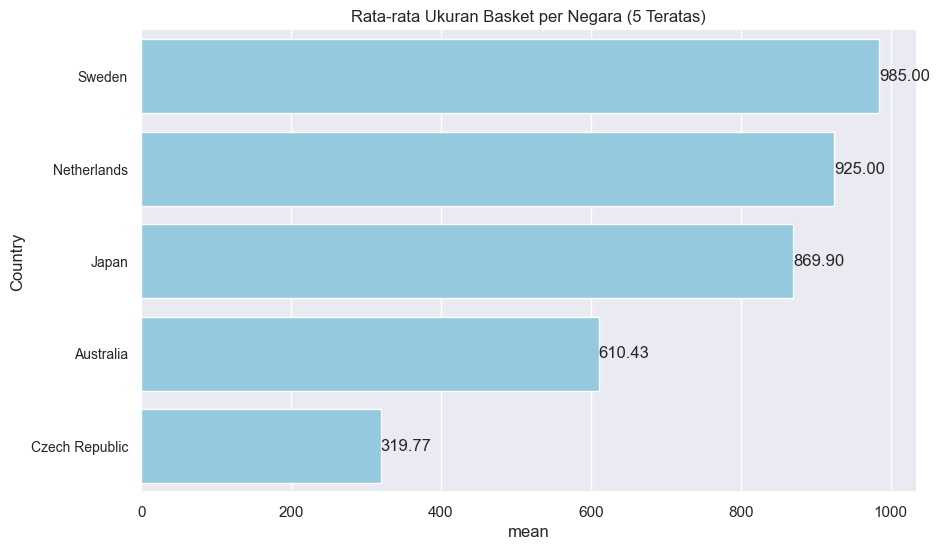

In [99]:
# Mengambil 5 besar negara dengan rata-rata ukuran basket tertinggi
top_5_grouped = sorted_grouped.head(5)

# Membuat grafik bar
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='mean', y='Country', data=top_5_grouped, color='skyblue')

# Menambahkan nilai di tiap bar
for i in ax.patches:
    ax.annotate(f'{i.get_width():.2f}', (i.get_width(), i.get_y() + i.get_height() / 2), ha='left', va='center')

# Menambahkan judul
plt.title("Rata-rata Ukuran Basket per Negara (5 Teratas)")

# Memperbesar ukuran huruf keterangan sumbu y
ax.tick_params(axis='y', labelsize=10)  # Mengganti labelsize menjadi 16 (2 kali dari default)

# Menghilangkan garis frame atas dan samping kanan
sns.despine()

# Menampilkan grafik
plt.show()

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\1394010201.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_grouped['total_penjualan'] = top_5_grouped['total_penjualan'] / 1000000


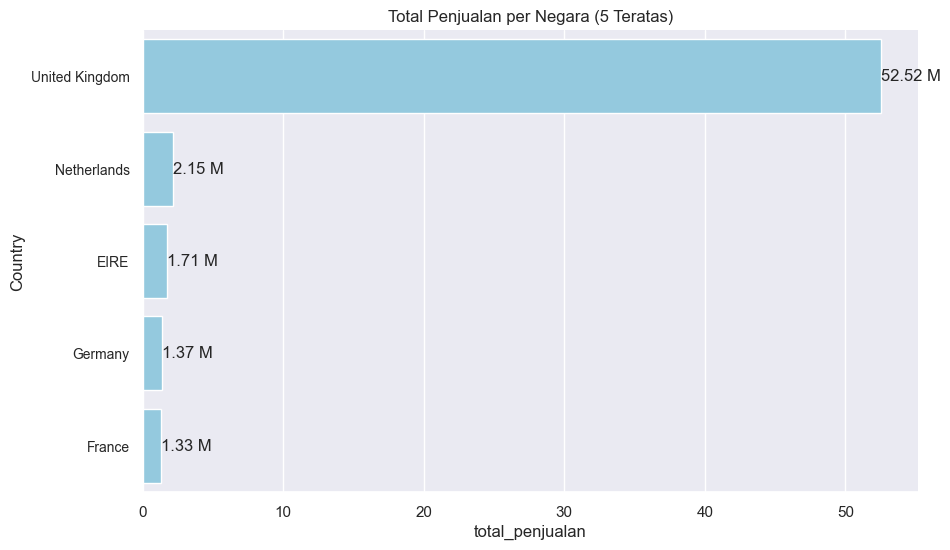

In [100]:
# Mengurutkan hasil berdasarkan total amount secara menurun
sorted_grouped = grouped.sort_values(by='total_penjualan', ascending=False)

# Mengambil 5 negara teratas dengan total amount tertinggi
top_5_grouped = sorted_grouped.head(5)

# Mengonversi total amount menjadi jutaan (million) tanpa peringatan
top_5_grouped['total_penjualan'] = top_5_grouped['total_penjualan'] / 1000000

# Membuat grafik bar
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='total_penjualan', y='Country', data=top_5_grouped, color='skyblue')

# Menambahkan nilai dalam M (million) di tiap bar
for i in ax.patches:
    ax.annotate(f'{i.get_width():.2f} M', (i.get_width(), i.get_y() + i.get_height() / 2), ha='left', va='center')

# Menambahkan judul
plt.title("Total Penjualan per Negara (5 Teratas)")

# Memperbesar ukuran huruf keterangan sumbu y
ax.tick_params(axis='y', labelsize=10)  # Memperbesar ukuran huruf keterangan sumbu y

# Menghilangkan garis frame atas dan samping kanan
sns.despine()

# Menampilkan grafik
plt.show()

# Mengembalikan pengaturan peringatan
warnings.filterwarnings("default")

Insight:

- Hasil Uji ANOVA: Hasil uji ANOVA menghasilkan Nilai p-value yang rendah menunjukkan bahwa terdapat perbedaan yang signifikan dalam ukuran keranjang dari negara yang berbeda dalam dataset.

- Negara dengan Rata-Rata Ukuran Keranjang Tertinggi: Sweden adalah negara dengan rata-rata ukuran keranjang tertinggi, mencapai 984.99. Ini menunjukkan bahwa pelanggan dari Sweden cenderung melakukan pembelian dengan nilai yang lebih tinggi per transaksi.

- Negara dengan Rata-Rata Ukuran Keranjang Terendah: Iceland adalah negara dengan rata-rata ukuran keranjang terendah, yaitu 48.69. Ini menandakan bahwa pelanggan dari Iceland memiliki keranjang dengan nilai lebih rendah per transaksi.

Rekomendasi: 

Segmentasi Berdasarkan Negara: Berdasarkan hasil ANOVA, perusahaan dapat mempertimbangkan untuk melakukan segmentasi pelanggan berdasarkan negara asal mereka. Ini memungkinkan perusahaan untuk merancang strategi pemasaran dan penawaran produk yang lebih sesuai dengan preferensi pelanggan dari negara tertentu.

Analisis Lebih Lanjut: Setelah mengidentifikasi perbedaan yang signifikan, langkah selanjutnya adalah melakukan analisis lebih mendalam untuk memahami penyebab perbedaan tersebut. Apakah perbedaan ini disebabkan oleh preferensi produk tertentu, budaya belanja, atau faktor-faktor lain?

In [371]:
sorted_data

Country  CustomerNo
36        United Kingdom        4080
14               Germany          87
13                France          85
3                Belgium          22
31                 Spain          22
33           Switzerland          20
27              Portugal          17
10                  EIRE          13
19                 Italy          12
12               Finland          11
0              Australia           9
24           Netherlands           8
25                Norway           8
9                Denmark           8
20                 Japan           7
32                Sweden           7
37           Unspecified           7
6        Channel Islands           6
1                Austria           6
7                 Cyprus           6
26                Poland           5
5                 Canada           4
16             Hong Kong           4
18                Israel           4
34                   USA           3
2                Bahrain           2
35  United Arab Emirates           2
23                 Malta           2
4                 Brazil           1
8         Czech Republic           1
17               Iceland           1
30             Singapore           1
29          Saudi Arabia           1
28                   RSA           1
15                Greece           1
22             Lithuania           1
21               Lebanon           1
11    European Community           1

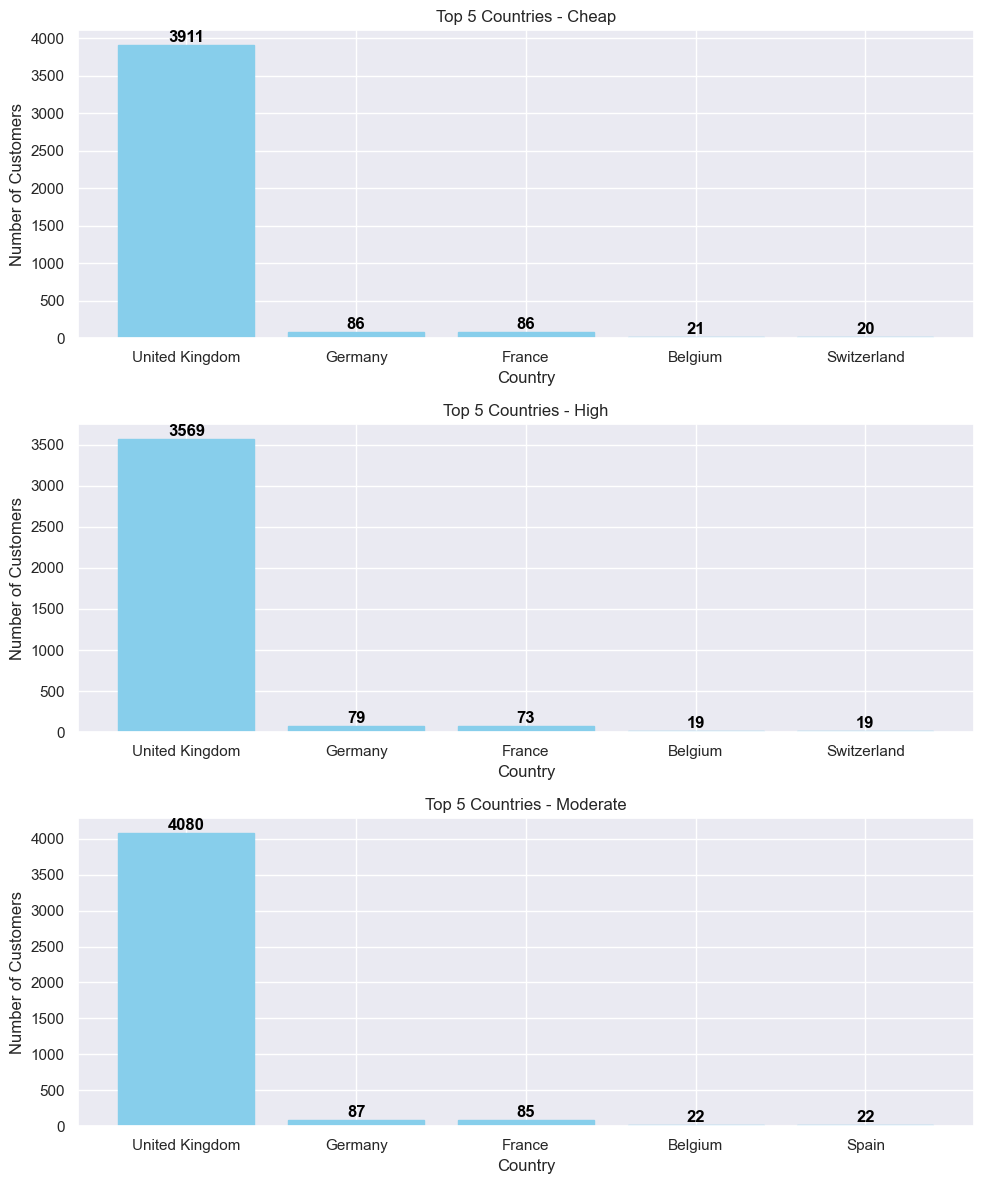

In [102]:
# Kategori harga yang ingin ditampilkan
categories = ['Cheap', 'High', 'Moderate']

# Menyiapkan subplot
fig, axs = plt.subplots(nrows=len(categories), ncols=1, figsize=(10, 12))

# Mengatur subplot untuk setiap kategori
for i, category in enumerate(categories):
    # Mengelompokkan berdasarkan negara dan menghitung jumlah pelanggan unik
    grouped_data = df_sales[df_sales['Price_Category'] == category].groupby('Country')['CustomerNo'].nunique().reset_index()
    
    # Mengurutkan berdasarkan jumlah pelanggan
    sorted_data = grouped_data.sort_values(by='CustomerNo', ascending=False)
    
    # Mengambil 5 besar
    top_5_countries = sorted_data.head(5)
    
    # Menampilkan grafik batang
    bars = axs[i].bar(top_5_countries['Country'], top_5_countries['CustomerNo'], color='skyblue', edgecolor='skyblue')
    axs[i].set_title(f'Top 5 Countries - {category}')
    axs[i].set_xlabel('Country')
    axs[i].set_ylabel('Number of Customers')

    # Menampilkan angka pada setiap batang
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', color='black', fontweight='bold')

# Menyesuaikan tata letak dan menampilkan plot
plt.tight_layout()
plt.show()

insight:

- Negara yang Harus Ditingkatkan Penjualannya:

United Kingdom: Negara ini menjadi fokus utama untuk peningkatan penjualan kategori Moderate dan Cheap. Berdasarkan Top 5 Countries - Moderate dan Cheap, United Kingdom memiliki jumlah pelanggan yang signifikan. Strategi penjualan yang ditujukan kepada pelanggan di United Kingdom dapat berkontribusi positif terhadap peningkatan average basket size harian.

Negara Lain: Selain United Kingdom, perlu juga mempertimbangkan peningkatan penjualan di negara-negara lain yang tercantum dalam Top 5 Countries - Moderate dan Cheap, seperti Germany dan france. Menyesuaikan strategi pemasaran dan penjualan untuk mencapai target peningkatan average basket size harian di negara-negara ini juga merupakan langkah yang penting.

In [ ]:
# Kategori harga yang ingin ditampilkan
categories = ['Cheap', 'High', 'Moderate']

# Menyiapkan subplot
fig, axs = plt.subplots(nrows=len(categories), ncols=1, figsize=(10, 12))

# Mengatur subplot untuk setiap kategori
for i, category in enumerate(categories):
    # Mengelompokkan berdasarkan negara dan menghitung jumlah pelanggan unik
    grouped_data = df_sales[df_sales['Price_Category'] == category].groupby('Country')['CustomerNo'].nunique().reset_index()
    
    # Mengurutkan berdasarkan jumlah pelanggan
    sorted_data = grouped_data.sort_values(by='CustomerNo', ascending=False)
    
    # Mengambil 5 besar
    top_5_countries = sorted_data.head(5)
    
    # Menampilkan grafik batang
    bars = axs[i].bar(top_5_countries['Country'], top_5_countries['CustomerNo'], color='skyblue', edgecolor='skyblue')
    axs[i].set_title(f'Top 5 Countries - {category}')
    axs[i].set_xlabel('Country')
    axs[i].set_ylabel('Number of Customers')

    # Menampilkan angka pada setiap batang
    for bar in bars:
        yval = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', color='black', fontweight='bold')

# Menyesuaikan tata letak dan menampilkan plot
plt.tight_layout()
plt.show()

---
## Pertanyaan
1. Hitung rata-rata basket size dari seluruh transaksi per harinya, apakah konsisten atau ada perubahan ?
2. Apakah ada perbedaan ukuran basket dari negara yang berbeda ?

---
## Jawaban

1. Terdapat perubahan per harinya untuk rata rata revenue per customer sehingga berimplikasi menunjukkan adanya fluktuasi dalam pendapatan dalam bisnis tersebut.
2. Sejalan dengan poin 1, terdapat perbedaan pula ukuran basket size setiap negara. 
3. secara keseluruhan negara, sweden adalah negara dengan rata rata revenue per customer per hari yang tertinggi
4. Namun jika dilihat dari sisi jumlah customer unik, Negara tersebut bukan top 5 dengan customer terbanyak. UK merupakan negara dengan customer terbanyak sehingga negara ini seharusnya dijadikan pertimbangan fokus utama peningkatan penjualan
---

additional, bagaimana jika kita lihat secara bulanan?

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\885993713.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_average_basket_size = df_sales['revenue_total'].resample('M').sum() / df_sales['TransactionNo'].resample('M').count()


monthly_average_basket_size:
count     13.000000
mean     121.169396
std       13.151612
min       94.665315
25%      119.638186
50%      123.560342
75%      127.140499
max      138.654817
dtype: float64




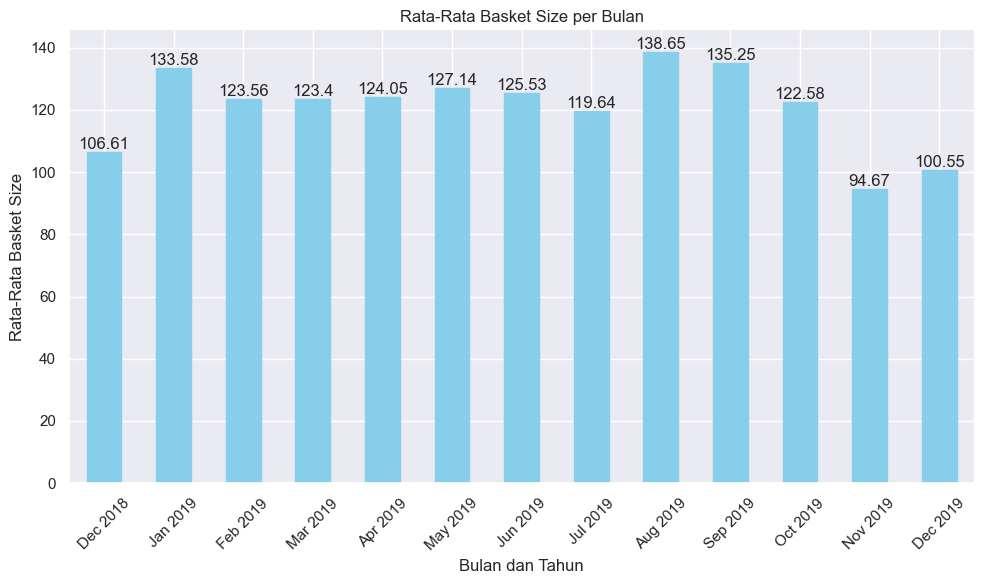

In [105]:
# Mengatur kolom 'date' sebagai indeks
df_sales.set_index('Date', inplace=True)

# Mengelompokkan data berdasarkan bulan dan menghitung rata-rata basket size per bulannya
monthly_average_basket_size = df_sales['revenue_total'].resample('M').sum() / df_sales['TransactionNo'].resample('M').count()

# Membuat grafik bar
plt.figure(figsize=(10, 6))
monthly_average_basket_size.plot(kind='bar', color='skyblue', edgecolor='skyblue')
plt.title('Rata-Rata Basket Size per Bulan')
plt.xlabel('Bulan dan Tahun')
plt.ylabel('Rata-Rata Basket Size')

# Menghilangkan garis frame atas dan garis frame samping kanan
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Menampilkan nilai di atas setiap bar
for index, value in enumerate(monthly_average_basket_size):
    plt.text(index, value, str(round(value, 2)), ha='center', va='bottom')

# Mengambil indeks (tanggal) untuk label bulan dan tahun pada sumbu x
x_labels = [date.strftime('%b %Y') for date in monthly_average_basket_size.index]
plt.xticks(range(len(x_labels)), x_labels, rotation=45)

# Menampilkan describe statistik dari basket size
print("monthly_average_basket_size:")
print(monthly_average_basket_size.describe())
print("\n")

# Menampilkan grafik
plt.tight_layout()
plt.show()

Insight dan Rekomendasi¶
- Rata-Rata Basket Size: Rata-rata basket size selama periode yang diamati adalah sekitar 121.16 dengan deviasi standar sekitar 13.15. Ini menunjukkan adanya variasi dalam ukuran keranjang belanja setiap bulan.

- Perubahan dalam Basket Size: Terdapat fluktuasi dalam basket size selama periode yang diamati. Rata-rata tertinggi tercatat pada Agustus 2019 dengan 139.32, sementara rata-rata terendah adalah pada November 2019 dengan hanya 95.68.

- Analisis Data Lebih Lanjut:
- Disarankan untuk melakukan analisis lebih lanjut untuk memahami faktor-faktor yang mungkin memengaruhi fluktuasi dalam basket size. Ini dapat mencakup analisis tren belanja pelanggan, promosi, atau perubahan dalam penawaran produk.

- Targetkan Pelanggan Setia:Identifikasi dan fokus pada pelanggan yang cenderung mempertahankan basket size tinggi. Ini dapat mencakup program loyalitas atau rekomendasi produk yang lebih baik.

## Pertanyaan Crucial
4. What are the most profitable segment customers?

In [106]:
# ANALISIS RFM CUSTOMER SEGMENTATION
def calculate_rfm(df):
    # Menghitung RFM metrics
    snapshot_date = df['Date'].max() + pd.Timedelta(days=1)  # Tanggal snapshot adalah hari setelah transaksi terakhir
    rfm = df.groupby('CustomerNo').agg({
        'Date': lambda x: (snapshot_date - x.max()).days,  # Recency: jarak waktu dari transaksi terakhir
        'TransactionNo': 'nunique',  # Frequency: jumlah transaksi
        'revenue_total': 'sum'  # Monetary: total pendapatan
    }).reset_index()

    # Rename columns
    rfm.columns = ['CustomerNo', 'Recency', 'Frequency', 'Monetary']

    return rfm

def classify_customers(rfm):
    # Klasifikasi pelanggan berdasarkan quartile RFM
    r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=range(4, 0, -1))
    f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=range(1, 5))
    m_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=range(1, 5))

    rfm['R'] = r_quartiles.astype(int)
    rfm['F'] = f_quartiles.astype(int)
    rfm['M'] = m_quartiles.astype(int)

    # Klasifikasi menjadi 4 jenis pelanggan
    rfm['RFM_Score'] = rfm['R'] + rfm['F'] + rfm['M']
    
    return rfm

In [107]:
# Memanggil fungsi untuk menghitung RFM
df_sales.reset_index('Date', inplace=True)
rfm_data = calculate_rfm(df_sales)


In [108]:
# Menentukan R_Score 1-4
bins = [0, 30, 60, 100, float('inf')]
labels = [4, 3, 2, 1]
rfm_data['R_score'] = pd.cut(rfm_data['Recency'],bins=bins, labels=labels, right=False)
rfm_data.groupby('R_score').agg({'Recency':['min','max','mean','median','count']})

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\866841321.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_data.groupby('R_score').agg({'Recency':['min','max','mean','median','count']})


Recency                              
            min  max        mean median count
R_score                                      
4             1   29   13.178808   12.0  1661
3            30   59   42.746929   41.0   814
2            60   99   76.024768   74.0   646
1           100  374  220.296807  212.0  1597

In [109]:

# Menentukan F_Score 1-4
bins = [0, 15, 30, 80, float('inf')]
labels = [1, 2, 3, 4]
rfm_data['F_score'] = pd.cut(rfm_data['Frequency'],bins=bins, labels=labels, right=False)
rfm_data.groupby('F_score').agg({'Frequency':['min','max','mean','median','count']})

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\2747601238.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_data.groupby('F_score').agg({'Frequency':['min','max','mean','median','count']})


Frequency                              
              min  max        mean median count
F_score                                        
1               1   14    3.190813    2.0  4528
2              15   29   19.703448   19.0   145
3              30   73   41.815789   38.5    38
4              86  207  127.857143   98.0     7

In [110]:
# Menentukan M_Score 1-4
bins = [0, 800, 1800, 3430, float('inf')]
labels = [1, 2, 3, 4]
rfm_data['M_score'] = pd.cut(rfm_data['Monetary'],bins=bins, labels=labels, right=False)
rfm_data.groupby('M_score').agg({'Monetary':['min','max','mean','median','count']})

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\1873011781.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_data.groupby('M_score').agg({'Monetary':['min','max','mean','median','count']})


Monetary                                          
             min         max          mean    median count
M_score                                                   
1           5.97      799.03    384.503644    411.50   450
2         801.12     1799.13   1279.460731   1269.99   698
3        1802.62     3427.87   2543.191684   2510.44   778
4        3440.03  2112282.03  21461.747486  10036.88  2792

In [111]:
# Tambahkan kolom-kolom RFM dan RFM Score ke dalam DataFrame
rfm_data['R_score'] = rfm_data['R_score'].astype(int)
rfm_data['F_score'] = rfm_data['F_score'].astype(int)
rfm_data['M_score'] = rfm_data['M_score'].astype(int)
rfm_data['RFM_Score'] = rfm_data['R_score'] + rfm_data['F_score'] + rfm_data['M_score']

# Klasifikasi RFM Score menjadi kategori RFM Class
rfm_data['RFM_Class'] = pd.cut(rfm_data['RFM_Score'], bins=[0, 3, 6, 9, 12], labels=['Low Customer', 'Normal Customer', 'Customer Loyal', 'Top Customer'])

In [112]:
rfm_data.sort_values(by='RFM_Score')

CustomerNo  Recency  Frequency   Monetary  R_score  F_score  M_score  \
1510     14160.0      285          1      41.00        1        1        1   
1668     14368.0      320          1     527.88        1        1        1   
1670     14371.0      296          1     451.52        1        1        1   
1671     14373.0      359          1     252.70        1        1        1   
1679     14386.0      297          1     699.40        1        1        1   
...          ...      ...        ...        ...      ...      ...      ...   
4384     17841.0        2        125  255508.58        4        4        4   
2406     15311.0        1         91  392033.09        4        4        4   
2085     14911.0        2        198  914633.52        4        4        4   
667      13089.0        3         98  354882.55        4        4        4   
581      12971.0        4         86  100914.98        4        4        4   

      RFM_Score     RFM_Class  
1510          3  Low Customer  
1668          3  Low Customer  
1670          3  Low Customer  
1671          3  Low Customer  
1679          3  Low Customer  
...         ...           ...  
4384         12  Top Customer  
2406         12  Top Customer  
2085         12  Top Customer  
667          12  Top Customer  
581          12  Top Customer  

[4718 rows x 9 columns]

In [113]:
# Gabungkan rfm_data dengan df_sales berdasarkan CustomerNo
df= pd.merge(df_sales, rfm_data, on='CustomerNo', how='inner')

In [122]:
df

Date TransactionNo ProductNo  \
0      2019-12-09        581482     22485   
1      2019-12-09        581475     22596   
2      2019-12-09        581475     23235   
3      2019-12-09        581475     23272   
4      2019-12-09        581475     23239   
...           ...           ...       ...   
527759 2018-12-01        536585     37449   
527760 2018-12-01        536590     22776   
527761 2018-12-01        536590     22622   
527762 2018-12-01        536591     37449   
527763 2018-12-01        536597     22220   

                                ProductName  Price  Quantity  CustomerNo  \
0             Set Of 2 Wooden Market Crates  21.47        12     17490.0   
1       Christmas Star Wish List Chalkboard  10.65        36     13069.0   
2                  Storage Tin Vintage Leaf  11.53        12     13069.0   
3         Tree T-Light Holder Willie Winkie  10.65        12     13069.0   
4         Set Of 4 Knick Knack Tins Poppies  11.94         6     13069.0   
...                                     ...    ...       ...         ...   
527759   Ceramic Cake Stand + Hanging Cakes  20.45         2     17460.0   
527760         Sweetheart 3 Tier Cake Stand  20.45         1     13065.0   
527761       Box Of Vintage Alphabet Blocks  20.45         2     13065.0   
527762   Ceramic Cake Stand + Hanging Cakes  20.45         1     14606.0   
527763     Cake Stand Lovebird 2 Tier White  20.45         1     18011.0   

               Country  revenue_total  Month  ...   elastisitas_group  \
0       United Kingdom         257.64     12  ...  Elastisitas Sedang   
1       United Kingdom         383.40     12  ...  Elastisitas Sedang   
2       United Kingdom         138.36     12  ...  Elastisitas Sedang   
3       United Kingdom         127.80     12  ...  Elastisitas Sedang   
4       United Kingdom          71.64     12  ...  Elastisitas Sedang   
...                ...            ...    ...  ...                 ...   
527759  United Kingdom          40.90     12  ...  Elastisitas Sedang   
527760  United Kingdom          20.45     12  ...  Elastisitas Sedang   
527761  United Kingdom          40.90     12  ...  Elastisitas Sedang   
527762  United Kingdom          20.45     12  ...  Elastisitas Sedang   
527763  United Kingdom          20.45     12  ...  Elastisitas Sedang   

        Price_Category Recency Frequency  Monetary  R_score  F_score  M_score  \
0                 High       1         7  13538.07        4        1        4   
1                Cheap       1        24  63353.94        4        2        4   
2             Moderate       1        24  63353.94        4        2        4   
3                Cheap       1        24  63353.94        4        2        4   
4             Moderate       1        24  63353.94        4        2        4   
...                ...     ...       ...       ...      ...      ...      ...   
527759            High      95         6   3056.58        2        1        3   
527760            High     374         1    969.49        1        1        2   
527761            High     374         1    969.49        1        1        2   
527762            High       2        90  72822.38        4        4        4   
527763            High     374         1    821.04        1        1        2   

        RFM_Score        RFM_Class  
0               9   Customer Loyal  
1              10     Top Customer  
2              10     Top Customer  
3              10     Top Customer  
4              10     Top Customer  
...           ...              ...  
527759          6  Normal Customer  
527760          4  Normal Customer  
527761          4  Normal Customer  
527762         12     Top Customer  
527763          4  Normal Customer  

[527764 rows x 22 columns]

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\2518948690.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue = df.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].mean().reset_index()
C:\Users\jufor\anaconda3\envs\project2024\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jufor\anaconda3\envs\project2024\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwa

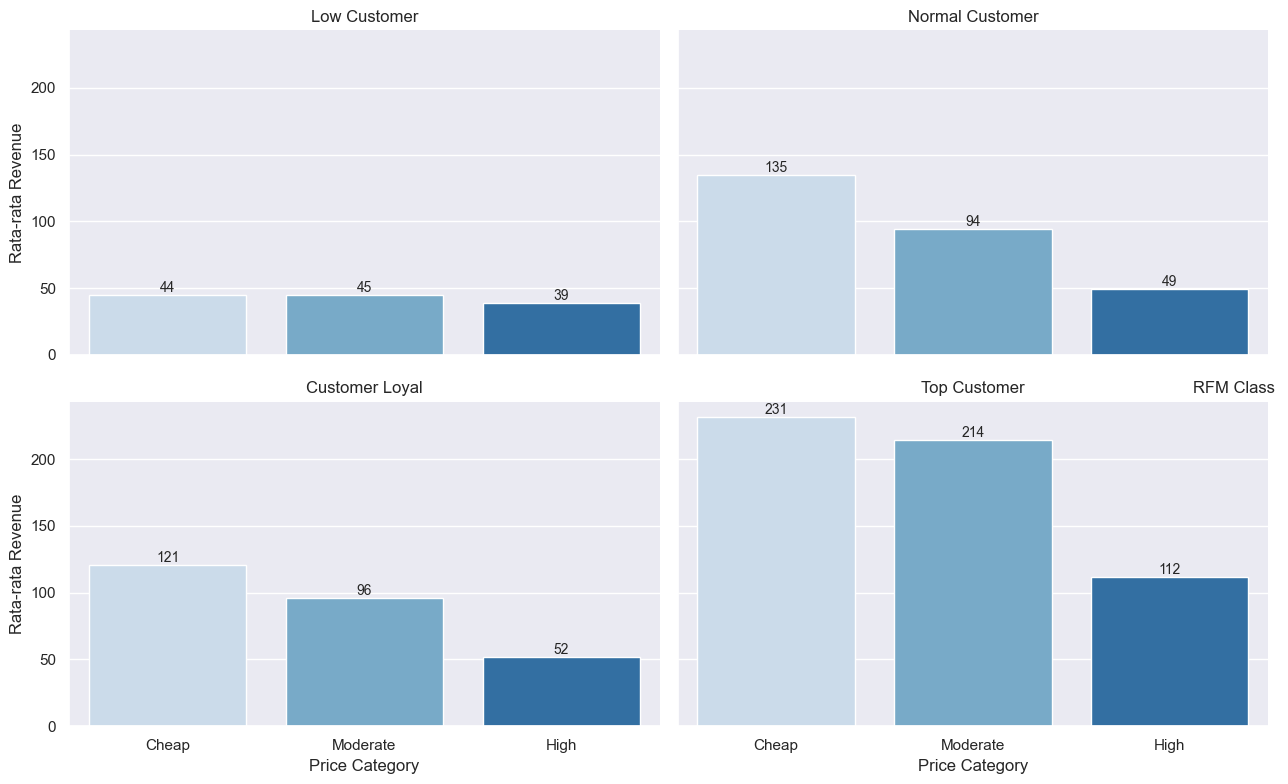

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misalkan df adalah DataFrame yang sudah ada
# df = pd.read_csv('path_to_your_data.csv')

# Menghitung rata-rata revenue_total per RFM_Class dan Price_Category
avg_revenue = df.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].mean().reset_index()

# Membuat FacetGrid
g = sns.FacetGrid(avg_revenue, col='RFM_Class', col_wrap=2, height=4, aspect=1.5)

# Menggambar grafik batang pada setiap subplot dengan palet warna valid
g.map_dataframe(sns.barplot, x='Price_Category', y='revenue_total', palette='Blues')

# Menambahkan label dan judul
g.set_axis_labels('Price Category', 'Rata-rata Revenue')
g.set_titles(col_template="{col_name}")
g.add_legend(title='RFM Class')

# Format angka di atas batang
def format_value(value):
    """ Format nilai dengan simbol 'K' atau dalam juta jika lebih dari 1 juta """
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return f'{value:.0f}'

for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, format_value(height), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
bagaimana dengan rata rata revenue per transaksi?

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527764 entries, 0 to 527763
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               527764 non-null  datetime64[ns]
 1   TransactionNo      527764 non-null  object        
 2   ProductNo          527764 non-null  object        
 3   ProductName        527764 non-null  object        
 4   Price              527764 non-null  float64       
 5   Quantity           527764 non-null  int64         
 6   CustomerNo         527764 non-null  float64       
 7   Country            527764 non-null  object        
 8   revenue_total      527764 non-null  float64       
 9   Month              527764 non-null  int32         
 10  Year               527764 non-null  int32         
 11  korelasi           525829 non-null  float64       
 12  elastisitas_group  525829 non-null  category      
 13  Price_Category     527764 non-null  category

C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3284131419.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_avg_per_transaction = df.groupby(['RFM_Class', 'Price_Category', 'TransactionNo'])['revenue_total'].mean().reset_index()
C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3284131419.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_revenue_per_category = df_avg_per_transaction.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].mean().reset_index()
C:\Users\jufor\anaconda3\envs\project2024\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning

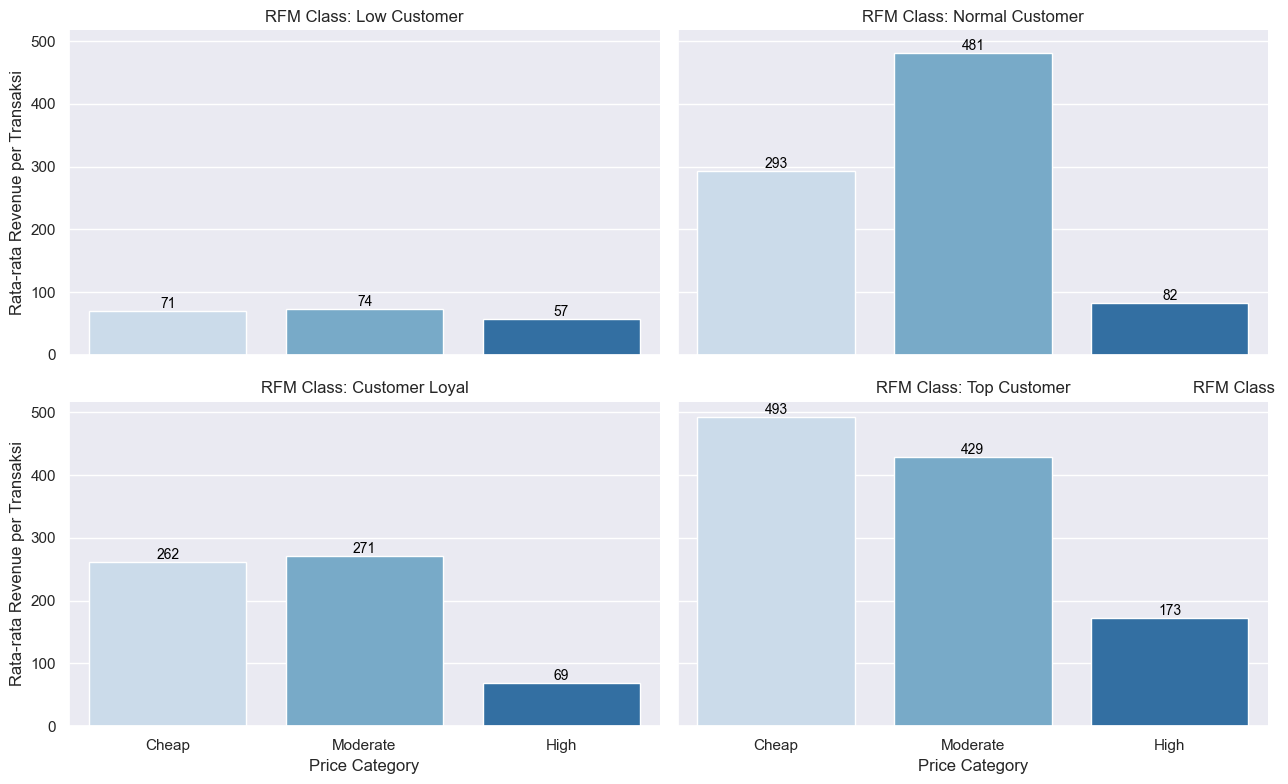

In [121]:
# Menghitung rata-rata revenue_total per transaksi
df_avg_per_transaction = df.groupby(['RFM_Class', 'Price_Category', 'TransactionNo'])['revenue_total'].mean().reset_index()

# Menghitung rata-rata revenue_total per RFM_Class dan Price_Category
avg_revenue_per_category = df_avg_per_transaction.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].mean().reset_index()

# Membuat FacetGrid
g = sns.FacetGrid(avg_revenue_per_category, col='RFM_Class', col_wrap=2, height=4, aspect=1.5)

# Menggambar grafik batang pada setiap subplot dengan palet warna valid
g.map_dataframe(sns.barplot, x='Price_Category', y='revenue_total', palette='Blues')

# Menambahkan label dan judul
g.set_axis_labels('Price Category', 'Rata-rata Revenue per Transaksi')
g.set_titles(col_template="RFM Class: {col_name}")
g.add_legend(title='RFM Class')

# Format angka di atas batang
def format_value(value):
    """ Format nilai dengan simbol 'K' atau dalam juta jika lebih dari 1 juta """
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return f'{value:.0f}'

for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, format_value(height),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

C:\Users\jufor\AppData\Local\Temp\ipykernel_20168\4221858662.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_revenue = df.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].sum().reset_index()
C:\Users\jufor\anaconda3\envs\project2024\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jufor\anaconda3\envs\project2024\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kw

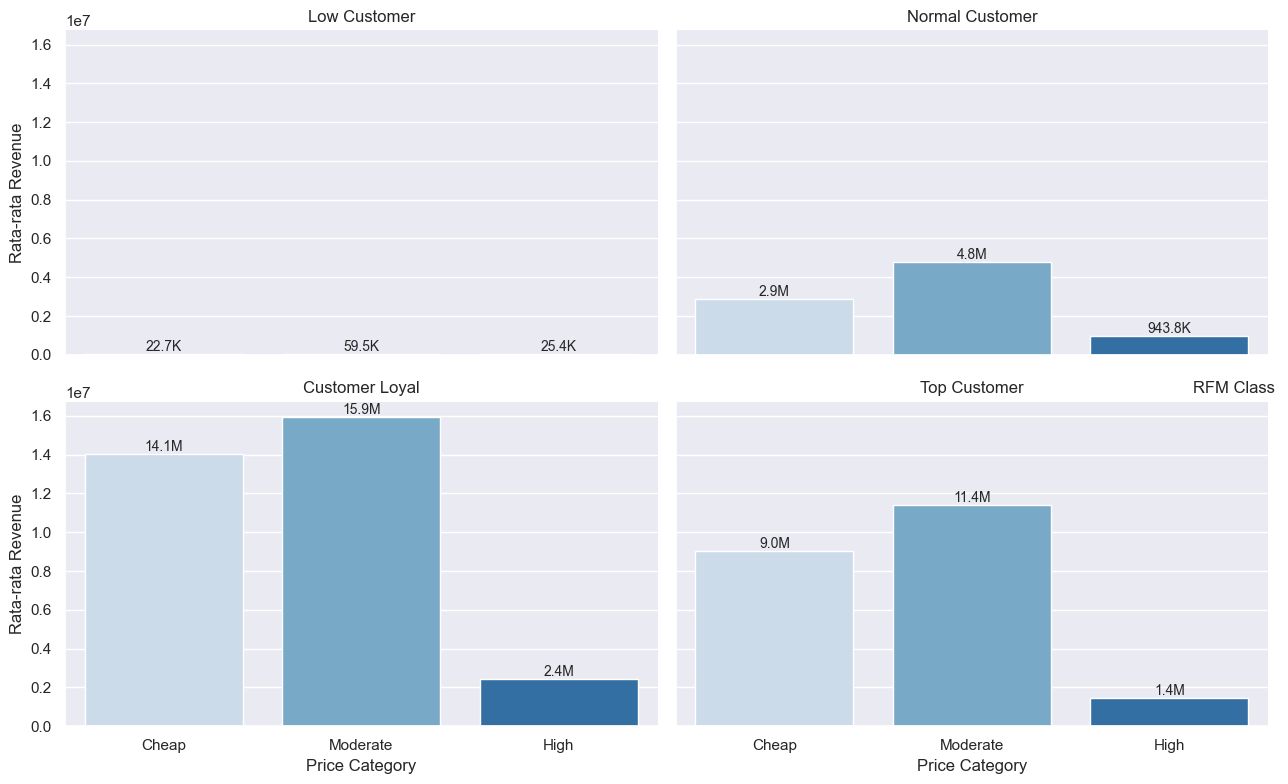

In [435]:
# Menghitung Total Penjualan per RFM_Class dan Price_Category
total_revenue = df.groupby(['RFM_Class', 'Price_Category'])['revenue_total'].sum().reset_index()

# Membuat FacetGrid
g = sns.FacetGrid(total_revenue, col='RFM_Class', col_wrap=2, height=4, aspect=1.5)

# Menggambar grafik batang pada setiap subplot dengan palet warna valid
g.map_dataframe(sns.barplot, x='Price_Category', y='revenue_total', palette='Blues')

# Menambahkan label dan judul
g.set_axis_labels('Price Category', 'Rata-rata Revenue')
g.set_titles(col_template="{col_name}")
g.add_legend(title='RFM Class')

# Format angka di atas batang
def format_value(value):
    """ Format nilai dengan simbol 'K' atau dalam juta jika lebih dari 1 juta """
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return f'{value:.0f}'

for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height, format_value(height), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
bagaimana dengan tipe produk dan kategori harga?

In [137]:
df_classify2

ProductNo                         ProductName  total_transaksi  \
0        85123A  Cream Hanging Heart T-Light Holder              178   
1         22720    Set Of 3 Cake Tins Pantry Design              152   
2         22469               Heart Of Wicker Small              144   
3         22423            Regency Cakestand 3 Tier              133   
4         22457      Natural Slate Heart Chalkboard              124   
...         ...                                 ...              ...   
30486     23420            Pantry Hook Tea Strainer                1   
30487     23411                   Trellis Coat Rack                1   
30488     23327           Hanging Clear Mini Bottle                1   
30489     23324     Rustic Strawberry Jam Pot Large                1   
30490    90214Z           Letter "Z" Bling Key Ring                1   

      vol_category Month_Name  revenue_total revenue_category   product_type  \
0          Popular    January       72435.48          Popular  Super Popular   
1          Popular    January       16578.57          Popular  Super Popular   
2          Popular    January       35279.08          Popular  Super Popular   
3          Popular    January       23747.29          Popular  Super Popular   
4          Popular    January       10671.85          Popular  Super Popular   
...            ...        ...            ...              ...            ...   
30486          Low   December           6.19              Low            Low   
30487          Low   December          37.14           Normal         Normal   
30488          Low   December          23.88              Low            Low   
30489          Low   December          12.38              Low            Low   
30490          Low   December          73.56           Normal         Normal   

       Month  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
30486     12  
30487     12  
30488     12  
30489     12  
30490     12  

[30491 rows x 9 columns]

In [135]:
# Filter data untuk tahun 2019
df_filter_2019 = df[df['Year'] == 2019]
df_classify2 = df_classify[df_classify['Month_Name'].notna()]

# Membuat peta nama bulan ke angka
bulan_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Mengonversi nama bulan ke angka di df_classify
df_classify2['Month'] = df_classify2['Month_Name'].map(bulan_to_number)


# Menggabungkan df dengan df_classify
merged_df = pd.merge(df_filter_2019, df_classify2, on=['ProductNo', 'Month'], how='left')


C:\Users\jufor\AppData\Local\Temp\ipykernel_17488\3116397634.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_summary = merged_df.groupby(['Price_Category', 'product_type'])['revenue_total_x'].sum().reset_index()


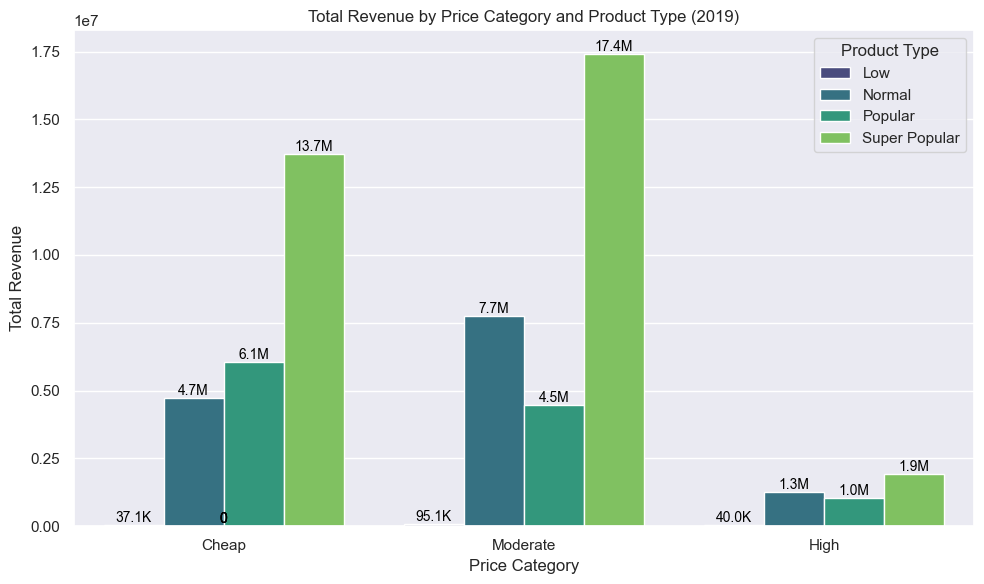

In [141]:

# Menghitung total revenue berdasarkan Price_Category dan product_type
revenue_summary = merged_df.groupby(['Price_Category', 'product_type'])['revenue_total_x'].sum().reset_index()

# Membuat plot
plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_summary, x='Price_Category', y='revenue_total_x', hue='product_type', palette='viridis')

# Menambahkan label dan judul
plt.xlabel('Price Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Price Category and Product Type (2019)')
plt.legend(title='Product Type')

# Format angka di atas batang
def format_value(value):
    """ Format nilai dengan simbol 'K' atau dalam juta jika lebih dari 1 juta """
    if value >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        return f'{value / 1_000:.1f}K'
    else:
        return f'{value:.0f}'

# Menambahkan nilai pada batang
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, height, format_value(height),
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

---

1. How was the sales trend over the months?
2. What are the most frequently purchased products?
3. How many products does the customer purchase in each transaction?
4. What are the most profitable segment customers?
5. Based on your findings, what strategy could you recommend to the business to gain more profit?

---

CONCLUSION & RECOMMEDATION
---
Performa Penjualan 

- Peningkatan Penjualan : Data menunjukkan kecenderungan peningkatan penjualan sepanjang tahun 2019 dimana penjualan mencapai puncak tertinggi pada bulan November, yang mungkin dipengaruhi oleh faktor-faktor seperti persiapan natar/liburan atau penawaran khusus selama periode tersebut. Hal ini mengindikasikan bahwa bisnis mungkin telah berhasil dalam meningkatkan daya tarik produk atau layanan kepada pelanggan.
- Jika puncak penjualan terjadi selama musim liburan, pertimbangkan untuk meningkatkan persediaan, menawarkan penawaran spesial, atau mengatur promosi liburan untuk mengoptimalkan penjualan selama periode ini.
- Analisis lebih lanjut penjualan Hari Selasa. bisa dilihat berdasarkan tingkat kepuasan (namun data tidak tersedia).
- Waktu Weekend khususnya hari Minggu adalah waktu dengan rata rata penjualan tertinggi, perusahan dapat mempertimbangkan mengatur strategi di waktu tersebut untuk meningkatakan layanan atau menerapkan strategi promosi 

---
Product Evaluation

- Pemantauan dan Evaluasi Harga yang Lebih Tepat:  korelasi yang rendah namun disisi lain produk-produk dengan tingkat penjualan terbesar sepanjang tahun 2019 juga merupakan produk dengan top 10 perubahan harga terbanyak, sehingga perusahaan memerlukan pemantauan dan strategi harga yang lebih cermat untuk produk tersebut untuk memaksimalkan keuntungan dan menjawab fluktuasi pasar.

- 3 Produk Elastisitas tinggi dan memiliki kategori popular/super popular/ normal : yaitu Tea Party Birthday Car, Spaceboy Birthday Girl, dan Card Dolly Girl adalah produk dengan tingkat penjualan dan transaksi yang cukup moderat serta cenderung elastis terhadap perubahan harga. perusahaan dapat mempertimbangkan untuk fokus pada strategi harga pada produk tersebut untuk memaksimalkan penjualan 

- Berdasarkan kategori elastisitas harga secara bulanan, rata rata basket size, dan tren penjualan, Perusahaan dapat mengevaluasi strategi yang diterapkan khususnya pada bulan agustus mencakup  promosi, atau perubahan dalam penawaran produk sebab dari segi transaksi mengalami penurunan namun nilai transaksinya meningkat sedangkat dari elastisitas harga lebih mirip ke pola elastisitas harga sedang.

- Perusahaan dapat memfokuskan pada produk dengan harga murah, khususnya pada customer dengan kategori top customer karena memiliki rata rata basket size yang tinggi.Ini dapat mencakup program loyalitas atau rekomendasi produk yang lebih baik. Sedangkan untuk harga moderat bisa menargetkan strategi pada customer Normal melalui strategi promosi

---
Customer Analysis

- Perusahaan perlu mempertimbangkan strategi retensi khusus untuk kohort yang mengalami penurunan retention rate, yaitu kohort Februari hingga September dan New Customer. Ini bisa melibatkan program loyalitas untuk retained customer, atau peningkatan layanan pelanggan untuk customer baru atau insentif khusus untuk mempertahankan pelanggan dalam jangka panjang.
- Analisis Lebih Lanjut pada Kohort Juni dan Juli: Karena kohort Juni dan Juli mengalami peningkatan retention rate pada bulan November, perusahaan harus memahami faktor-faktor apa yang berkontribusi pada peningkatan tersebut. Apakah ada promosi tertentu atau perubahan dalam pengalaman pelanggan yang perlu ditingkatkan dan diterapkan pada kohort lain



---

## Tambahan Analysis
Saya mencoba membuat Prediktif Analisis dengan dataset yang ada, yaitu membuat Forecast Demand satu tahun kedepan dari data aktual

Hasil uji Augmented Dickey-Fuller (ADF):
ADF Statistic: -2.0894724726757574
p-value: 0.24876878979835343
Critical Values:
	1%: -4.137829282407408
	5%: -3.1549724074074077
	10%: -2.7144769444444443
Kesimpulan: Data deret waktu aktual tidak stasioner.


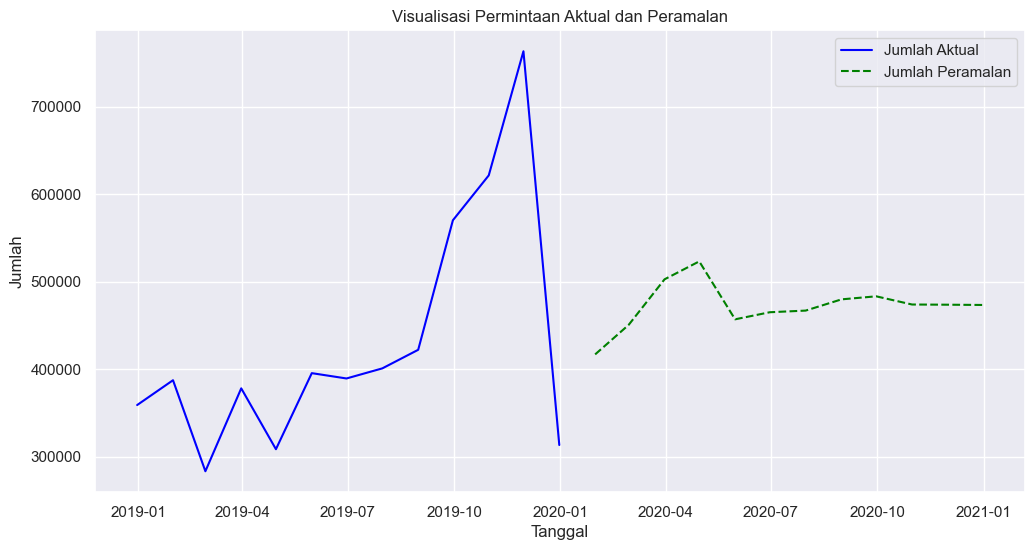


Nilai Peramalan:
2020-01-31    416803.318764
2020-02-29    450584.327964
2020-03-31    502627.684482
2020-04-30    523124.255003
2020-05-31    456904.941458
2020-06-30    464993.988905
2020-07-31    466878.801095
2020-08-31    479721.297745
2020-09-30    483196.389734
2020-10-31    473830.819688
2020-11-30    473616.858055
2020-12-31    473311.730460
Freq: ME, Name: predicted_mean, dtype: float64


In [444]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

# Menghindari peringatan
warnings.filterwarnings("ignore")

# Memilih kolom yang relevan untuk deret waktu
data = df_sales.copy()
data = data[['Date', 'Quantity']]

# Mengonversi kolom tanggal menjadi format datetime
data['Date'] = pd.to_datetime(data['Date'])

# Menetapkan 'Date' sebagai index dan meresample data ke frekuensi bulanan
data.set_index('Date', inplace=True)
data = data.resample('M').sum()

# Mengekstrak deret waktu 'Quantity'
ts = data['Quantity']

# Mendefinisikan fungsi untuk memeriksa stasionaritas menggunakan uji ADF
def check_stationarity(data):
    result = adfuller(data)
    return result

# Memeriksa stasionaritas dari 'Quantity'
result = check_stationarity(ts)

# Menafsirkan hasil uji ADF
print("Hasil uji Augmented Dickey-Fuller (ADF):")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] <= 0.05:
    print("Kesimpulan: Data deret waktu aktual adalah stasioner.")
else:
    print("Kesimpulan: Data deret waktu aktual tidak stasioner.")

# Menyesuaikan model ARIMA pada deret waktu
model = ARIMA(ts, order=(5, 1, 0))
model_fit = model.fit()

# Peramalan permintaan di masa depan untuk periode tertentu
periode_peramalan = 12  # Peramalan untuk 12 bulan
forecasted_values = model_fit.forecast(steps=periode_peramalan)

# Menghasilkan tanggal peramalan yang sesuai dengan nilai peramalan
tanggal_terakhir = ts.index[-1]
tanggal_peramalan = [tanggal_terakhir + pd.DateOffset(months=i) for i in range(1, periode_peramalan + 1)]

# Menggabungkan nilai peramalan dengan data aktual untuk visualisasi
data_peramalan = pd.DataFrame({'Quantity': forecasted_values}, index=tanggal_peramalan)
data_combined = pd.concat([data, data_peramalan])

# Visualisasikan permintaan aktual dan peramalan
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Quantity'], label='Jumlah Aktual', color='blue')
plt.plot(data_peramalan.index, data_peramalan['Quantity'], label='Jumlah Peramalan', color='green', linestyle='--')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')
plt.title('Visualisasi Permintaan Aktual dan Peramalan')
plt.legend()
plt.grid(True)
plt.show()

# Cetak nilai peramalan permintaan
print('\nNilai Peramalan:')
print(forecasted_values)


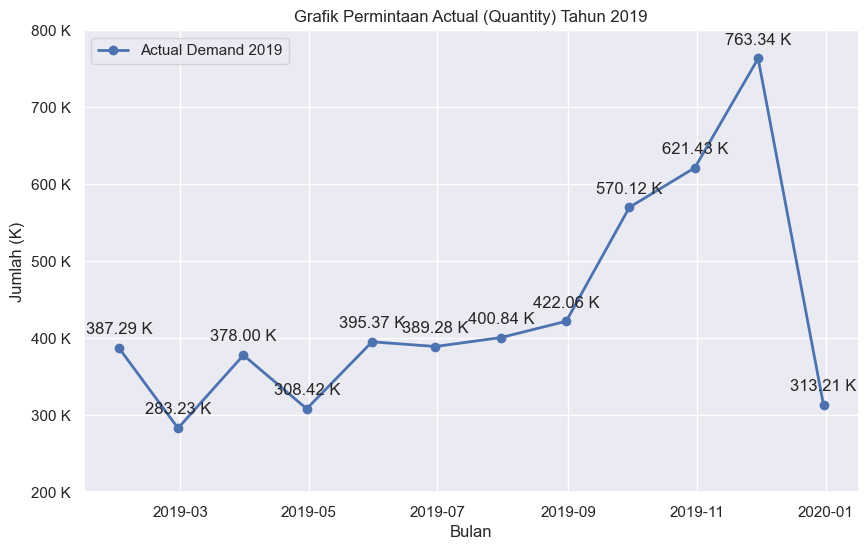

In [449]:
# Filter data untuk tahun 2019
data_2019 = df_sales[(df_sales['Date'] >= '2019-01-01') & (df_sales['Date'] <= '2019-12-31')]

# Group data per bulan dan hitung total quantity
monthly_quantity = data_2019.resample('M', on='Date')['Quantity'].sum()

# Buat grafik
plt.figure(figsize=(10, 6))
plt.plot(monthly_quantity.index, monthly_quantity.values, label='Actual Demand 2019', marker='o', markersize=6, linewidth=2)
plt.title('Grafik Permintaan Actual (Quantity) Tahun 2019')
plt.xlabel('Bulan')
plt.ylabel('Jumlah (K)')
plt.legend()
yticks = [int(y / 1000) for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], [f'{y} K' for y in yticks])
for i, txt in enumerate(monthly_quantity.values):
    plt.annotate(f'{txt/1000:.2f} K', (monthly_quantity.index[i], txt), textcoords="offset points", xytext=(0,10), ha='center')
plt.xticks(rotation=0)
plt.show()

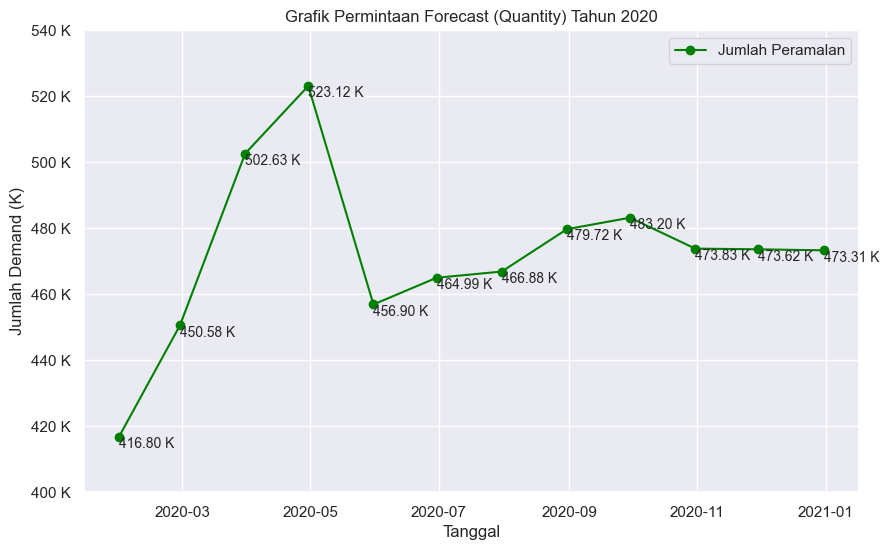

In [450]:
# Visualisasikan permintaan aktual dan peramalan
plt.figure(figsize=(10, 6))
plt.plot(tanggal_peramalan, forecasted_values, label='Jumlah Peramalan', color='green', marker='o', markersize=6)
plt.legend()
plt.title('Grafik Permintaan Forecast (Quantity) Tahun 2020')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Demand (K)')
yticks = [int(y / 1000) for y in plt.yticks()[0]]
plt.yticks(plt.yticks()[0], [f'{y} K' for y in yticks])
for i, txt in enumerate(forecasted_values):
    plt.annotate(f'{txt/1000:.2f} K', (tanggal_peramalan[i], forecasted_values[i]), textcoords="offset points", xytext=(0, -8), ha='left', fontsize=10)
plt.xticks(rotation=0)
plt.show()